In [1]:
import numpy as np 
import pandas as pd 
import joblib 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
from sklearn.model_selection import train_test_split
from os.path import join 
from sklearn.metrics import f1_score, recall_score, roc_auc_score, accuracy_score, roc_curve, r2_score
from sklearn.decomposition import PCA 
from sklearn.neural_network import MLPClassifier
from kan import KAN 
from torch.nn import Softmax, CrossEntropyLoss, MSELoss, L1Loss 
from torch import Tensor, cuda 
from torch import device as d 
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt 

/sc/arion/work/koenid03/conda/envs/GPUClone2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = d('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
rhi = pd.read_csv('/sc/arion/projects/tauomics/danielk/clinical_data/parkman_rhi_tsvs/parkman_rhi_clinical_full.tsv', sep='\t')
rhi['Slide_ID'] = rhi['Slide_ID'].str.replace('.svs', '', regex=False)

In [4]:
slide_ids = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/outputs/umap_clustering_interpretation_of_dino/bag_slide_ids.pkl')

In [5]:
cluster_save_data = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/outputs/umap_clustering_interpretation_of_dino/clusters_pred=0,1.pkl')
cluster_labels = cluster_save_data['labels']
n_clusters = len(np.unique(cluster_labels))

In [6]:
slide_decomposition_mapper = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/outputs/umap_clustering_interpretation_of_dino/cluster_decomps_pred=0,1.pkl')
decompositions = np.zeros((len(slide_ids), n_clusters*384*2))
for i, slide_id in enumerate(tqdm(slide_ids)): 
    decompositions[i] = slide_decomposition_mapper[slide_id]

100%|██████████████████████████████████████████████████████████████████| 793/793 [00:00<00:00, 69176.66it/s]


In [7]:
rhi['cte'] = (rhi['CTE'] == 'Yes').astype(int)

rhi['bri'] = (rhi['tbri'] >= 65).astype(int)
rhi['tmi'] = (rhi['tmi'] >= 65).astype(int)
rhi['aes'] = (rhi['aestot'] >= 34).astype(int)
rhi['gds'] = (rhi['GDStot'] >= 5).astype(int)
rhi['bis'] = (rhi['bistot'] >= 80).astype(int)
rhi['suicide'] = (rhi['cod'] == 'Suicide').astype(int)

In [8]:
rhi['under_30'] = (rhi['agedeath'] <= 30).astype(int)

In [9]:
rhi['under_30_cte'] = ((rhi['under_30']==1) & (rhi['cte']==1)).astype(int)
rhi['under_30_bri'] = ((rhi['under_30']==1) & (rhi['bri']==1)).astype(int)
rhi['under_30_tmi'] = ((rhi['under_30']==1) & (rhi['tmi']==1)).astype(int)
rhi['under_30_aes'] = ((rhi['under_30']==1) & (rhi['aes']==1)).astype(int)
rhi['under_30_gds'] = ((rhi['under_30']==1) & (rhi['gds']==1)).astype(int)
rhi['under_30_bis'] = ((rhi['under_30']==1) & (rhi['bis']==1)).astype(int)

In [10]:
rhi['no_cte_bri'] = ((rhi['cte']==0) & (rhi['bri']==1)).astype(int)
rhi['no_cte_tmi'] = ((rhi['cte']==0) & (rhi['tmi']==1)).astype(int)
rhi['no_cte_aes'] = ((rhi['cte']==0) & (rhi['aes']==1)).astype(int)
rhi['no_cte_gds'] = ((rhi['cte']==0) & (rhi['gds']==1)).astype(int)
rhi['no_cte_bis'] = ((rhi['cte']==0) & (rhi['bis']==1)).astype(int)

In [11]:
rhi['totyears'] = rhi[[c for c in rhi.columns if 'yrs' in c]].sum(axis=1)

In [12]:
def prg_gain_transform(x, pi): 
    if x == pi == 1: 
        return 1 
    return (x - pi) / ((1 - pi) * x)

def f1_gain_score(labels, preds): 
    pi = np.sum(labels) / len(labels)
    return prg_gain_transform(f1_score(labels, preds), pi)

def get_stats(lbls, ps): 
    auc = roc_auc_score(lbls, ps)
    fpr, tpr, thresholds = roc_curve(lbls, ps)
    youdens_j = tpr - fpr
    max_index = np.argmax(youdens_j)
    optimal_threshold = thresholds[max_index]
    max_youdens_j = youdens_j[max_index]
    preds = (ps >= optimal_threshold).astype(int)
    f1 = f1_gain_score(lbls, preds)
    acc = accuracy_score(lbls, preds)
    return auc, f1, acc 

def slide_to_label(df, column): 
    sub_df = df[['Slide_ID', column]].dropna()
    return dict(zip(sub_df['Slide_ID'].to_numpy(), sub_df[column].to_numpy()))

In [13]:
def p_value_to_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [18]:
def run_kan_limit_column(column, limit_column, limit_value=1, width=[100, 2], clusters=[0, 1, 2, 3, 4], steps=5, max_k=20): 
    #trying with only certain clusters 
    cluster_to_try = clusters
    indices = np.concatenate([range((c+1)*384*2, (c+2)*384*2) for c in cluster_to_try])
    sub_decomposition = decompositions[:, indices]

    sub_rhi = rhi[rhi[limit_column]==limit_value]
    sub_rhi = sub_rhi[['Slide_ID', column]].dropna()
    slide_label_map = slide_to_label(sub_rhi, column)
    ls = np.array([slide_label_map[s] for s in slide_ids if s in slide_label_map])

    inner_slides = np.array([i for i, s in enumerate(slide_ids) if s in slide_label_map])
    sub_decompositions = sub_decomposition[inner_slides,:]

    out_df = []
    best_model = None
    best_auc = 0 
    pca = PCA(n_components=width[0])
    sub_decompositions = pca.fit_transform(sub_decompositions)
    previous_ls = None 
    states = np.random.randint(low=0, high=1000000, size=max_k)
    for k in range(0, max_k): 
        print(k, 'of', max_k)
        X_train, X_test, y_train, y_test = train_test_split(sub_decompositions, range(len(ls)), test_size=0.3, 
                                                            stratify=ls, random_state=states[k])

        dataset = {}
        dataset['train_input'] = Tensor(X_train).to(device)
        dataset['train_label'] = Tensor(ls[y_train]).long().to(device)
        dataset['test_input'] = Tensor(X_test).to(device)
        dataset['test_label'] = Tensor(ls[y_test]).long().to(device)
        
        assert not np.array_equal(previous_ls, ls[y_test])
        previous_ls = ls[y_test]
        
        model = KAN(width=width, device=device)
        results = model.train(dataset, steps=steps, loss_fn=CrossEntropyLoss(), device=device)
        m = Softmax(dim=1)
        probs = m(model(dataset['test_input']))
        preds = probs.argmax(dim=1)
        probs = probs[:, 1]

        auc, f1, acc = get_stats(ls[y_test], probs.cpu().data.numpy())
        print(auc, f1, acc)

        if auc > best_auc: 
            best_auc = auc 
            best_model = model 
        out_df.append(
            {
                'k': k, 
                'AUC': auc, 
                'F1': f1, 
                'Acc': acc
            }
        )
        
    out_df = pd.DataFrame(out_df)
    print(np.mean(out_df['AUC']))
    print(np.mean(out_df['F1']))
    stat, p_value = wilcoxon(out_df['AUC'] - 0.5)
    print(f'Statistics={stat}, p={p_value}')

    melted_df = pd.melt(out_df, id_vars=['k'], value_vars=['AUC', 'F1'], var_name='Metric', value_name='Score')

    fig, ax = plt.subplots(1, 1, figsize=(3, 8))
    sns.boxplot(data=melted_df, x='Metric', y='Score', color='white')
    sns.stripplot(melted_df, y='Score', x='Metric', color='black')
    plt.tight_layout()
    plt.show()
    return out_df, p_value, best_model 

In [27]:
def ntile_it(labels, n): 
    indices = np.argsort(labels)
    de_index = np.argsort(indices)
    nsize = int(np.ceil(len(labels) / n)) 
    new_labels_sorted = np.concatenate([np.array([_n]*nsize) for _n in range(n)])[:len(labels)]
    new_labels = new_labels_sorted[de_index]
    return new_labels, {_n: np.max(labels[np.where(new_labels==_n)[0]]) for _n in range(n)}

def run_kan_con(column, width=[100, 1], clusters=[0, 1, 2, 3, 4], steps=5, max_k=20): 
    #trying with only certain clusters 
    cluster_to_try = clusters
    indices = np.concatenate([range((c+1)*384*2, (c+2)*384*2) for c in cluster_to_try])
    sub_decomposition = decompositions[:, indices]

#     sub_rhi = rhi[rhi['agedeath']<=30].copy()
    sub_rhi = rhi.copy()
    sub_rhi = sub_rhi[['Slide_ID', column]].dropna()
    slide_label_map = slide_to_label(sub_rhi, column)
    old_ls = np.array([slide_label_map[s] for s in slide_ids if s in slide_label_map])
    ls, thresholds = ntile_it(old_ls, 4)

    inner_slides = np.array([i for i, s in enumerate(slide_ids) if s in slide_label_map])
    sub_decompositions = sub_decomposition[inner_slides,:]

    out_df = []
    best_model = None
    best_r2 = 0 
    pca = PCA(n_components=width[0])
    sub_decompositions = pca.fit_transform(sub_decompositions)
    previous_ls = None 
    states = np.random.randint(low=0, high=1000000, size=max_k)
    for k in range(0, max_k): 
        print(k, 'of', max_k)
        X_train, X_test, y_train, y_test = train_test_split(sub_decompositions, range(len(ls)), test_size=0.3, 
                                                            random_state=states[k])

        dataset = {}
        dataset['train_input'] = Tensor(X_train).to(device)
        dataset['train_label'] = Tensor(ls[y_train]).view(-1, 1).to(device)
        dataset['test_input'] = Tensor(X_test).to(device)
        dataset['test_label'] = Tensor(ls[y_test]).view(-1, 1).to(device)
        
        assert not np.array_equal(previous_ls, ls[y_test])
        previous_ls = ls[y_test]
        
        model = KAN(width=width, device=device)
        results = model.train(dataset, steps=steps, loss_fn=L1Loss(), device=device)
        preds = model(dataset['test_input'])
        
        mse = np.mean((ls[y_test] - preds.detach().cpu().numpy().flatten()) ** 2)
        r2 = r2_score(ls[y_test], preds.detach().cpu().numpy().flatten())
        
        print(mse, r2)
        
        if r2 > best_r2: 
            best_r2 = r2 
            best_model = model 
        out_df.append(
            {
                'k': k, 
                'R2': r2, 
                'MSE': mse 
            }
        )
        
    out_df = pd.DataFrame(out_df)
    print(np.mean(out_df['R2']))
    stat, p_value = wilcoxon(out_df['MSE'])
    print(f'Statistics={stat}, p={p_value}')

    melted_df = pd.melt(out_df, id_vars=['k'], value_vars=['R2', 'MSE'], var_name='Metric', value_name='Score')

    fig, ax = plt.subplots(1, 1, figsize=(3, 8))
    sns.boxplot(data=melted_df, x='Metric', y='Score', color='white')
    sns.stripplot(melted_df, y='Score', x='Metric', color='black')
    plt.tight_layout()
    plt.show()
    return out_df, p_value, best_model 

u30_rhi_df, u30_rhi_p, u30_rhi_model = run_kan_con('aestot', width=[64, 5, 1], steps=10, max_k=5)

0 of 5


train loss: 6.74e-01 | test loss: 1.08e+00 | reg: 2.44e+01 : 100%|██| 10/10 [00:49<00:00,  5.00s/it]


1.9439089450365645 -0.5758834318873258
1 of 5


description:   0%|                                                           | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [40]:
model = KAN(width=[5, 3, 1])
model.train
model.plot()

AttributeError: 'KAN' object has no attribute 'acts'

In [34]:
np.unique((rhi['agedeath']<=105), return_counts=True)

(array([False,  True]), array([ 36, 676]))

In [16]:
np.unique((rhi['agedeath']<=30), return_counts=True)

(array([False,  True]), array([629,  83]))

In [39]:
np.unique((rhi['CTE']).fillna('woops'), return_counts=True)

(array(['No', 'Yes', 'woops'], dtype=object), array([262, 414,  36]))

In [14]:
def run_kan_predict_both(c1, c2, width=[100, 4], clusters=[0, 1, 2, 3, 4], steps=5, max_k=20): 
    #trying with only certain clusters 
    cluster_to_try = clusters
    indices = np.concatenate([range((c+1)*384*2, (c+2)*384*2) for c in cluster_to_try])
    sub_decomposition = decompositions[:, indices]

#     c3 = {
#         'aes': 'aestot'
#     }[c1]
#     sub_rhi = rhi[['Slide_ID', c1, c2, c3]].dropna()
    sub_rhi = rhi[['Slide_ID', c1, c2]].dropna()
    slide_label_map = slide_to_label(sub_rhi, c1)
    ls1 = np.array([slide_label_map[s] for s in slide_ids if s in slide_label_map])
    
    slide_label_map = slide_to_label(sub_rhi, c2)
    ls2 = np.array([slide_label_map[s] for s in slide_ids if s in slide_label_map])
    
    ls = 2*ls2 + ls1 # ls1 can be reobtained by modulo 2 

    inner_slides = np.array([i for i, s in enumerate(slide_ids) if s in slide_label_map])
    sub_decompositions = sub_decomposition[inner_slides,:]

    out_df = []
    best_model = None
    best_auc = 0 
    pca = PCA(n_components=width[0])
    sub_decompositions = pca.fit_transform(sub_decompositions)
    previous_ls = None 
    states = np.random.randint(low=0, high=1000000, size=max_k)
    for k in range(0, max_k): 
        print(k, 'of', max_k)
        X_train, X_test, y_train, y_test = train_test_split(sub_decompositions, range(len(ls)), test_size=0.3, 
                                                            stratify=ls, random_state=states[k])

        dataset = {}
        dataset['train_input'] = Tensor(X_train).to(device)
        dataset['train_label'] = Tensor(ls[y_train]).long().to(device)
        dataset['test_input'] = Tensor(X_test).to(device)
        dataset['test_label'] = Tensor(ls[y_test]).long().to(device)
        
        assert not np.array_equal(previous_ls, ls[y_test])
        previous_ls = ls[y_test]
        
        model = KAN(width=width, device=device)
        results = model.train(dataset, steps=steps, loss_fn=CrossEntropyLoss(), device=device)
        m = Softmax(dim=1)
        probs = m(model(dataset['test_input']))
        preds = probs.argmax(dim=1)
        probs = probs[:, 3] # probability of ls2 & ls1 is always 3, assume the positive label is both positive 

        # fix labels 2 for analysis of label 1 within fixed 2: 
        indices = np.where(ls2[y_test] == 1)[0]
        labels_to_3 = (ls[y_test]==3).astype(int)
        auc_low, f1_low, acc_low = get_stats(labels_to_3[indices], probs.cpu().data.numpy()[indices])
        auc, f1, acc = get_stats(labels_to_3, probs.cpu().data.numpy())
        
        print(auc, f1, acc)
        print(auc_low, f1_low, acc_low)

        if auc > best_auc: 
            best_auc = auc 
            best_model = model 
        out_df.append(
            {
                'k': k, 
                'AUC fixed': auc_low, 
                'F1 fixed': f1_low, 
                'Acc fixed': acc_low, 
                'AUC': auc, 
                'F1': f1, 
                'Acc': acc 
            }
        )
        
    out_df = pd.DataFrame(out_df)
    print(np.mean(out_df['AUC']))
    print(np.mean(out_df['F1']))
    stat, p_value = wilcoxon(out_df['AUC'] - 0.5)
    print(f'Statistics={stat}, p={p_value}')
    stat, p_value = wilcoxon(out_df['AUC fixed'] - 0.5)
    print(f'Statistics={stat}, p={p_value}')

    melted_df = pd.melt(out_df, id_vars=['k'], value_vars=['AUC', 'F1', 'Acc', 'AUC fixed', 'F1 fixed', 'Acc fixed'], var_name='Metric', value_name='Score')

    fig, ax = plt.subplots(1, 1, figsize=(3, 8))
    sns.boxplot(data=melted_df, x='Metric', y='Score', color='white')
    sns.stripplot(melted_df, y='Score', x='Metric', color='black')
    plt.tight_layout()
    plt.show()
    return out_df, p_value, best_model 

In [25]:
rhi['over_30'] = (rhi['agedeath'] > 30).astype(int)
print(np.sum(rhi['over_30']))

593


0 of 20


train loss: 6.74e-01 | test loss: 1.10e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.6170734857290456 0.3581248591390577 0.6363636363636364
1 of 20


train loss: 6.78e-01 | test loss: 1.01e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.6378664600284127 0.3380662609871532 0.625
2 of 20


train loss: 6.75e-01 | test loss: 1.05e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.93s/it]


0.6271471006069997 0.4191505941944282 0.6193181818181818
3 of 20


train loss: 6.76e-01 | test loss: 1.03e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.85s/it]


0.5776830685780705 0.5084340946409911 0.5795454545454546
4 of 20


train loss: 6.82e-01 | test loss: 1.01e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.5712256231434845 0.48850574712643663 0.5852272727272727
5 of 20


train loss: 6.62e-01 | test loss: 1.10e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:07<00:00,  2.63s/it]


0.5775539196693789 -0.3639846743295023 0.5909090909090909
6 of 20


train loss: 6.80e-01 | test loss: 1.10e+00 | reg: 1.52e+01 : 100%|████| 3/3 [00:08<00:00,  2.78s/it]


0.5734211545912437 0.3628755797539826 0.5965909090909091
7 of 20


train loss: 6.96e-01 | test loss: 9.66e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.6039002970424899 0.30161361626878863 0.5965909090909091
8 of 20


train loss: 6.73e-01 | test loss: 1.02e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.90s/it]


0.5851737052821904 0.2157088122605362 0.6079545454545454
9 of 20


train loss: 6.93e-01 | test loss: 9.64e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:07<00:00,  2.63s/it]


0.6162985922768952 0.3581248591390577 0.6363636363636364
10 of 20


train loss: 6.86e-01 | test loss: 9.79e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.68s/it]


0.6147488053725946 0.4730059212817833 0.6136363636363636
11 of 20


train loss: 6.73e-01 | test loss: 1.00e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.80s/it]


0.6470360325455251 0.5190427174472465 0.6420454545454546
12 of 20


train loss: 6.98e-01 | test loss: 9.03e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.642386671832623 0.3073515325670497 0.6306818181818182
13 of 20


train loss: 6.85e-01 | test loss: 9.96e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.6042877437685652 0.36760710553813974 0.6136363636363636
14 of 20


train loss: 6.67e-01 | test loss: 1.11e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.77s/it]


0.5305437169055921 0.5072189514998597 0.5511363636363636
15 of 20


train loss: 7.08e-01 | test loss: 8.94e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.72s/it]


0.6689913470231176 0.43270637408568424 0.6534090909090909
16 of 20


train loss: 6.81e-01 | test loss: 9.94e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:07<00:00,  2.62s/it]


0.6317964613199019 0.36063218390804597 0.6306818181818182
17 of 20


train loss: 6.43e-01 | test loss: 1.23e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.89s/it]


0.5420379697791554 0.31800766283524884 0.5681818181818182
18 of 20


train loss: 6.88e-01 | test loss: 1.02e+00 | reg: 1.52e+01 : 100%|████| 3/3 [00:08<00:00,  2.91s/it]


0.5691592406044168 0.5836674685912856 0.6022727272727273
19 of 20


train loss: 6.67e-01 | test loss: 1.06e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.88s/it]


0.5983468939687459 0.33970741901776375 0.5965909090909091
0.6018339145034224
0.3597783542976518
Statistics=0.0, p=1.9073486328125e-06


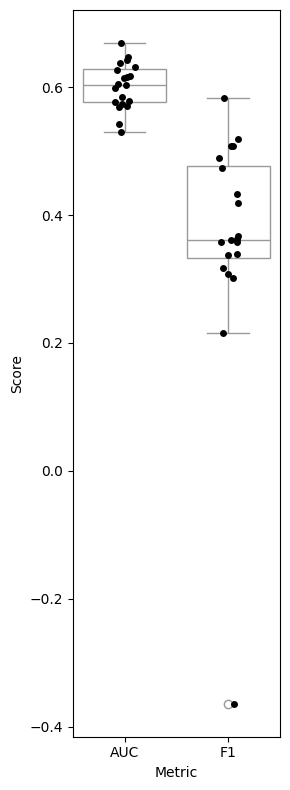

save this model to ./model_ckpt/over30_aes_model
0 of 20


train loss: 6.25e-02 | test loss: 2.34e+00 | reg: 2.24e+01 : 100%|████| 3/3 [00:08<00:00,  2.78s/it]


0.712171661117277 0.6792452830188679 0.45454545454545453
1 of 20


train loss: 1.53e-01 | test loss: 1.48e+00 | reg: 1.77e+01 : 100%|████| 3/3 [00:08<00:00,  2.90s/it]


0.6703662597114317 0.716255442670537 0.6079545454545454
2 of 20


train loss: 1.84e-01 | test loss: 1.28e+00 | reg: 1.72e+01 : 100%|████| 3/3 [00:08<00:00,  2.82s/it]


0.8305586385497594 0.8519593613933235 0.7954545454545454
3 of 20


train loss: 1.80e-01 | test loss: 1.49e+00 | reg: 1.71e+01 : 100%|████| 3/3 [00:07<00:00,  2.65s/it]


0.7203107658157601 0.8173480083857443 0.7670454545454546
4 of 20


train loss: 5.24e-02 | test loss: 2.65e+00 | reg: 2.17e+01 : 100%|████| 3/3 [00:08<00:00,  2.79s/it]


0.5464298927118016 0.7148846960167714 0.7272727272727273
5 of 20


train loss: 8.38e-02 | test loss: 1.85e+00 | reg: 2.01e+01 : 100%|████| 3/3 [00:08<00:00,  2.72s/it]


0.6892341842397336 0.689937106918239 0.5056818181818182
6 of 20


train loss: 1.34e-01 | test loss: 1.30e+00 | reg: 1.81e+01 : 100%|████| 3/3 [00:08<00:00,  2.69s/it]


0.6925638179800222 0.8195754716981132 0.8465909090909091
7 of 20


train loss: 1.68e-01 | test loss: 1.61e+00 | reg: 1.85e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.6936736958934517 0.8574423480083856 0.8636363636363636
8 of 20


train loss: 2.01e-01 | test loss: 9.87e-01 | reg: 1.70e+01 : 100%|████| 3/3 [00:08<00:00,  2.79s/it]


0.8446170921198668 0.9331761006289307 0.9147727272727273
9 of 20


train loss: 2.30e-01 | test loss: 9.37e-01 | reg: 1.67e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.805401405845357 0.7754716981132075 0.6420454545454546
10 of 20


train loss: 1.56e-01 | test loss: 1.15e+00 | reg: 1.71e+01 : 100%|████| 3/3 [00:08<00:00,  2.89s/it]


0.7691453940066593 0.7694575471698113 0.6079545454545454
11 of 20


train loss: 1.29e-01 | test loss: 1.64e+00 | reg: 1.83e+01 : 100%|████| 3/3 [00:08<00:00,  2.92s/it]


0.6577876433592305 0.6627963231736816 0.5340909090909091
12 of 20


train loss: 2.07e-01 | test loss: 9.93e-01 | reg: 1.68e+01 : 100%|████| 3/3 [00:08<00:00,  2.78s/it]


0.8322234554199038 0.8701707097933512 0.8068181818181818
13 of 20


train loss: 8.91e-02 | test loss: 1.68e+00 | reg: 1.89e+01 : 100%|████| 3/3 [00:08<00:00,  2.74s/it]


0.7351091379948206 0.7540880503144655 0.6079545454545454
14 of 20


train loss: 2.20e-01 | test loss: 1.02e+00 | reg: 1.67e+01 : 100%|████| 3/3 [00:08<00:00,  2.69s/it]


0.7602663706992231 0.8201829616923958 0.7897727272727273
15 of 20


train loss: 2.31e-01 | test loss: 1.04e+00 | reg: 1.63e+01 : 100%|████| 3/3 [00:08<00:00,  2.95s/it]


0.7521272660007399 0.8039832285115303 0.75
16 of 20


train loss: 1.30e-01 | test loss: 1.87e+00 | reg: 1.85e+01 : 100%|████| 3/3 [00:07<00:00,  2.66s/it]


0.6783203847576766 0.8075471698113206 0.7954545454545454
17 of 20


train loss: 1.81e-01 | test loss: 1.32e+00 | reg: 1.80e+01 : 100%|████| 3/3 [00:08<00:00,  2.82s/it]


0.7924528301886793 0.8833619210977702 0.8636363636363636
18 of 20


train loss: 1.40e-01 | test loss: 1.51e+00 | reg: 1.80e+01 : 100%|████| 3/3 [00:08<00:00,  2.91s/it]


0.6903440621531631 0.7026336477987422 0.4943181818181818
19 of 20


train loss: 7.25e-02 | test loss: 2.09e+00 | reg: 2.04e+01 : 100%|████| 3/3 [00:08<00:00,  2.89s/it]


0.6701812800591935 0.8574423480083856 0.9090909090909091
0.7271642619311874
0.7893479712111786
Statistics=0.0, p=1.9073486328125e-06


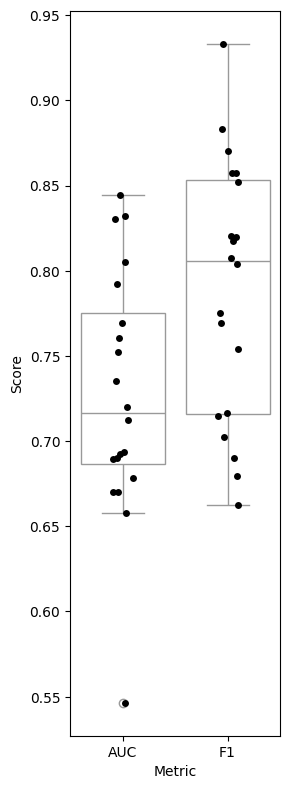

save this model to ./model_ckpt/over30_suicide_model
0 of 20


train loss: 6.95e-01 | test loss: 1.03e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.46334026334026335 -0.35982905982906 0.5113636363636364
1 of 20


train loss: 6.77e-01 | test loss: 1.20e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.4406098406098406 0.5019230769230767 0.6420454545454546
2 of 20


train loss: 6.91e-01 | test loss: 1.02e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.85s/it]


0.4997920997920998 -0.6688811188811189 0.5113636363636364
3 of 20


train loss: 7.05e-01 | test loss: 9.87e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.75s/it]


0.5288981288981289 0.2798887859128822 0.6022727272727273
4 of 20


train loss: 7.01e-01 | test loss: 1.09e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:07<00:00,  2.66s/it]


0.4909216909216909 0.34762316335350046 0.6136363636363636
5 of 20


train loss: 6.92e-01 | test loss: 1.03e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.89s/it]


0.5027027027027027 0.4876923076923077 0.6420454545454546
6 of 20


train loss: 6.97e-01 | test loss: 1.04e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.80s/it]


0.5384615384615384 0.15801282051282028 0.5965909090909091
7 of 20


train loss: 7.03e-01 | test loss: 1.00e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.5090783090783091 -0.07419354838709705 0.5568181818181818
8 of 20


train loss: 7.04e-01 | test loss: 9.93e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.69s/it]


0.5492723492723494 0.18076923076923046 0.5965909090909091
9 of 20


train loss: 6.75e-01 | test loss: 1.08e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.72s/it]


0.4530838530838531 0.4475113122171944 0.625
10 of 20


train loss: 6.98e-01 | test loss: 1.02e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.71s/it]


0.46029106029106026 -13.942307692307697 0.4034090909090909
11 of 20


train loss: 7.08e-01 | test loss: 1.01e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.5760221760221761 0.4491315136476426 0.6590909090909091
12 of 20


train loss: 7.06e-01 | test loss: 1.01e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.80s/it]


0.5064449064449064 -0.4230769230769236 0.5170454545454546
13 of 20


train loss: 7.06e-01 | test loss: 1.01e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.73s/it]


0.5665973665973666 -1.1346153846153852 0.5170454545454546
14 of 20


train loss: 6.86e-01 | test loss: 1.09e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.517948717948718 -0.2655219780219785 0.5284090909090909
15 of 20


train loss: 6.98e-01 | test loss: 9.53e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.5057519057519058 -0.8742964352720454 0.48863636363636365
16 of 20


train loss: 6.82e-01 | test loss: 1.16e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.78s/it]


0.45197505197505194 0.28515205724508036 0.5909090909090909
17 of 20


train loss: 7.12e-01 | test loss: 9.04e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.5936243936243936 -0.04981084489281247 0.5738636363636364
18 of 20


train loss: 6.97e-01 | test loss: 1.12e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.74s/it]


0.4584892584892584 -1.561538461538462 0.45454545454545453
19 of 20


train loss: 7.09e-01 | test loss: 1.01e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.88s/it]

0.5103257103257104 -0.7270979020979024 0.4943181818181818
0.5061815661815662
-0.8471732540323375
Statistics=87.5, p=0.5458755493164062


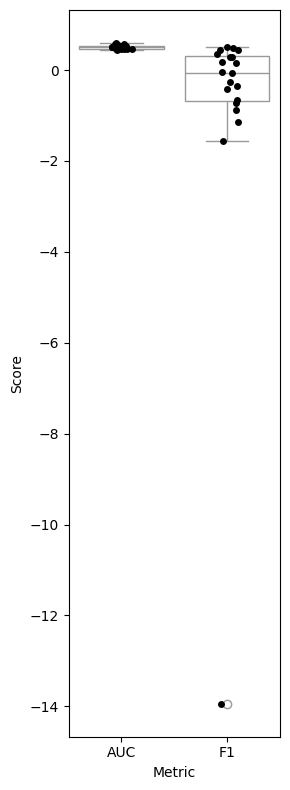

save this model to ./model_ckpt/over30_cte_model
0 of 20


train loss: 6.97e-01 | test loss: 1.10e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.87s/it]


0.4169385358214799 0.518987341772152 0.5681818181818182
1 of 20


train loss: 7.29e-01 | test loss: 1.01e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.5457392666057679 0.4647841609866925 0.6136363636363636
2 of 20


train loss: 7.11e-01 | test loss: 1.07e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.46731045282526423 0.4304560012200701 0.5625
3 of 20


train loss: 7.12e-01 | test loss: 1.02e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.5394754012788725 -0.06769400110071572 0.5454545454545454
4 of 20


train loss: 7.22e-01 | test loss: 9.99e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.87s/it]


0.5508286571838705 0.14050632911392408 0.5625
5 of 20


train loss: 7.34e-01 | test loss: 9.69e-01 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.5119404932793945 -0.289240506329114 0.5227272727272727
6 of 20


train loss: 6.90e-01 | test loss: 1.10e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.5115490016964636 -0.5167535368577811 0.5227272727272727
7 of 20


train loss: 7.19e-01 | test loss: 1.08e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.75s/it]


0.5547435730131801 -0.19553630912724834 0.5795454545454546
8 of 20


train loss: 7.13e-01 | test loss: 1.05e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.49001696463526034 0.5153231179213856 0.5738636363636364
9 of 20


train loss: 7.33e-01 | test loss: 9.71e-01 | reg: 1.48e+01 : 100%|████| 3/3 [00:07<00:00,  2.65s/it]


0.5352994910609422 -0.7359231776516804 0.5340909090909091
10 of 20


train loss: 7.11e-01 | test loss: 1.07e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.99s/it]


0.5175518726347383 -0.3472222222222223 0.5511363636363636
11 of 20


train loss: 7.19e-01 | test loss: 1.08e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.74s/it]


0.4977162990995693 -0.7189873417721518 0.5227272727272727
12 of 20


train loss: 7.08e-01 | test loss: 1.08e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.89s/it]


0.4889729870807778 0.13392857142857123 0.5511363636363636
13 of 20


train loss: 7.10e-01 | test loss: 1.13e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:09<00:00,  3.18s/it]


0.43533864021923524 -0.5435804701627489 0.5
14 of 20


train loss: 7.01e-01 | test loss: 1.17e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.95s/it]


0.4530862586454391 0.3362983236400958 0.5454545454545454
15 of 20


train loss: 7.27e-01 | test loss: 1.04e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.73s/it]


0.49536734960198353 0.4767692750287688 0.5738636363636364
16 of 20


train loss: 7.17e-01 | test loss: 1.05e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.87s/it]


0.5255122014876681 0.029999999999999822 0.5511363636363636
17 of 20


train loss: 7.16e-01 | test loss: 1.10e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.99s/it]


0.510505024141981 0.11200271247739582 0.5397727272727273
18 of 20


train loss: 7.26e-01 | test loss: 1.05e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.76s/it]


0.4887119926921571 0.26695635745324 0.5454545454545454
19 of 20


train loss: 7.15e-01 | test loss: 1.05e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.75s/it]


0.4721388490147462 0.5247039608003266 0.5909090909090909
0.5004371656009395
0.026788929330947973
Statistics=95.0, p=0.7285060882568359


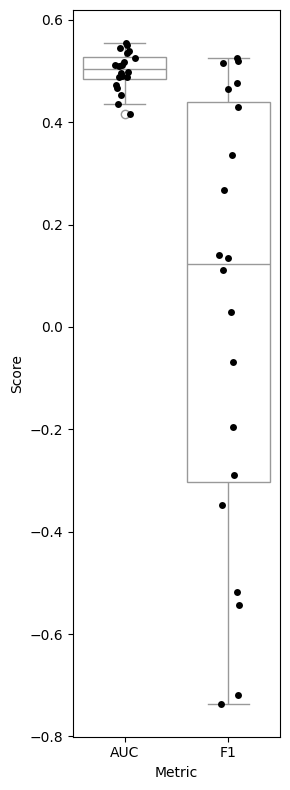

save this model to ./model_ckpt/over30_bri_model
0 of 20


train loss: 5.79e-01 | test loss: 1.00e+00 | reg: 1.52e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.5179252479023646 0.4916387959866222 0.45454545454545453
1 of 20


train loss: 5.84e-01 | test loss: 9.23e-01 | reg: 1.52e+01 : 100%|████| 3/3 [00:08<00:00,  2.76s/it]


0.6273836765827613 0.6819090454772614 0.6193181818181818
2 of 20


train loss: 5.77e-01 | test loss: 8.71e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.80s/it]


0.5549199084668193 0.5615942028985507 0.3125
3 of 20


train loss: 5.88e-01 | test loss: 9.86e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.5402364607170099 0.5525362318840579 0.48295454545454547
4 of 20


train loss: 5.90e-01 | test loss: 9.03e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.74s/it]


0.5947749809305872 0.6144927536231884 0.6022727272727273
5 of 20


train loss: 5.29e-01 | test loss: 1.19e+00 | reg: 1.56e+01 : 100%|████| 3/3 [00:07<00:00,  2.64s/it]


0.5768497330282227 0.5727136431784108 0.48863636363636365
6 of 20


train loss: 5.75e-01 | test loss: 9.73e-01 | reg: 1.53e+01 : 100%|████| 3/3 [00:08<00:00,  2.70s/it]


0.5732265446224256 0.5665593129361246 0.5170454545454546
7 of 20


train loss: 5.29e-01 | test loss: 1.38e+00 | reg: 1.56e+01 : 100%|████| 3/3 [00:08<00:00,  2.78s/it]


0.5171624713958811 0.5814492753623188 0.5681818181818182
8 of 20


train loss: 5.81e-01 | test loss: 9.83e-01 | reg: 1.53e+01 : 100%|████| 3/3 [00:08<00:00,  2.72s/it]


0.5228832951945079 0.5066425120772946 0.5113636363636364
9 of 20


train loss: 5.81e-01 | test loss: 9.50e-01 | reg: 1.52e+01 : 100%|████| 3/3 [00:07<00:00,  2.66s/it]


0.5694126620900076 0.5611413043478262 0.42045454545454547
10 of 20


train loss: 5.67e-01 | test loss: 1.00e+00 | reg: 1.52e+01 : 100%|████| 3/3 [00:07<00:00,  2.63s/it]


0.5530129672006102 0.48861283643892334 0.7045454545454546
11 of 20


train loss: 5.75e-01 | test loss: 1.01e+00 | reg: 1.53e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.5493897787948132 0.5869565217391305 0.5738636363636364
12 of 20


train loss: 5.74e-01 | test loss: 9.12e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.91s/it]


0.5154462242562929 0.5788576300085251 0.4090909090909091
13 of 20


train loss: 5.85e-01 | test loss: 9.18e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.80s/it]


0.6056445461479787 0.5797101449275361 0.6704545454545454
14 of 20


train loss: 5.82e-01 | test loss: 1.07e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:07<00:00,  2.56s/it]


0.5108695652173912 0.5310235507246377 0.3806818181818182
15 of 20


train loss: 5.83e-01 | test loss: 9.85e-01 | reg: 1.52e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.5104881769641495 0.5104669887278583 0.45454545454545453
16 of 20


train loss: 5.57e-01 | test loss: 1.10e+00 | reg: 1.55e+01 : 100%|████| 3/3 [00:08<00:00,  2.75s/it]


0.5307017543859649 0.5594202898550725 0.5454545454545454
17 of 20


train loss: 5.86e-01 | test loss: 9.04e-01 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.77s/it]


0.5371853546910755 0.5287068004459309 0.4943181818181818
18 of 20


train loss: 5.82e-01 | test loss: 9.30e-01 | reg: 1.52e+01 : 100%|████| 3/3 [00:08<00:00,  2.76s/it]


0.5791380625476735 0.6099033816425121 0.5170454545454546
19 of 20


train loss: 5.49e-01 | test loss: 1.08e+00 | reg: 1.54e+01 : 100%|████| 3/3 [00:08<00:00,  2.87s/it]


0.5156369183829138 0.36454849498327757 0.6590909090909091
0.5501144164759726
0.5514441858632531
Statistics=0.0, p=1.9073486328125e-06


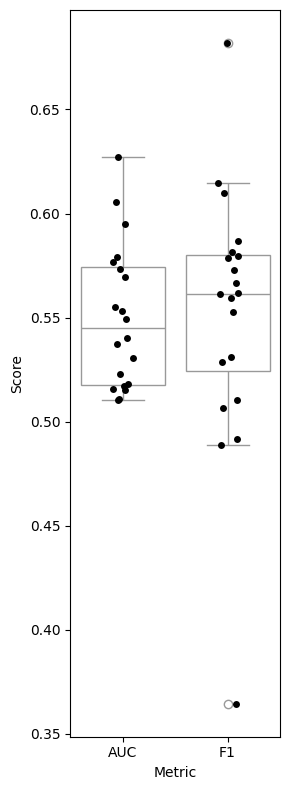

save this model to ./model_ckpt/over30_bis_model
0 of 20


train loss: 6.86e-01 | test loss: 1.07e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.87s/it]


0.5446209479529898 0.5545441615701893 0.5909090909090909
1 of 20


train loss: 6.83e-01 | test loss: 1.05e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.81s/it]


0.5522407335658013 0.5359835016356139 0.5738636363636364
2 of 20


train loss: 6.94e-01 | test loss: 9.85e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.73s/it]


0.6193981660854966 0.4239566613162119 0.625
3 of 20


train loss: 6.97e-01 | test loss: 9.19e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.86s/it]


0.6474234792716002 0.5112359550561798 0.6477272727272727
4 of 20


train loss: 6.55e-01 | test loss: 1.26e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.91s/it]


0.5098798915149166 0.27146491414034357 0.5511363636363636
5 of 20


train loss: 6.78e-01 | test loss: 1.04e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:09<00:00,  3.07s/it]


0.5527573292005682 0.517752808988764 0.5795454545454546
6 of 20


train loss: 6.79e-01 | test loss: 1.08e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.77s/it]


0.5647681777088983 0.40168539325842706 0.5965909090909091
7 of 20


train loss: 6.84e-01 | test loss: 1.07e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.68s/it]


0.5552111584657109 0.4914211964773763 0.5625
8 of 20


train loss: 6.94e-01 | test loss: 9.76e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:07<00:00,  2.65s/it]


0.6049334883120238 0.6185256234584818 0.6363636363636364
9 of 20


train loss: 6.89e-01 | test loss: 1.03e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.74s/it]


0.6089371044814671 0.4283945915063797 0.6079545454545454
10 of 20


train loss: 6.92e-01 | test loss: 9.67e-01 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.70s/it]


0.5791037065736795 0.593678083118993 0.6079545454545454
11 of 20


train loss: 6.80e-01 | test loss: 1.01e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:07<00:00,  2.64s/it]


0.5868526410951828 0.48867761452031117 0.6136363636363636
12 of 20


train loss: 7.11e-01 | test loss: 8.75e-01 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.72s/it]


0.6421283740152396 0.5723314606741573 0.6420454545454546
13 of 20


train loss: 6.90e-01 | test loss: 1.01e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.71s/it]


0.5718713676869431 0.5246267508080652 0.5965909090909091
14 of 20


train loss: 6.74e-01 | test loss: 1.07e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.84s/it]


0.5163373369495028 0.5112359550561798 0.5397727272727273
15 of 20


train loss: 6.86e-01 | test loss: 9.82e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.90s/it]


0.6434198631021567 0.5670947030497592 0.6477272727272727
16 of 20


train loss: 6.78e-01 | test loss: 9.76e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.85s/it]


0.597830298333979 0.45514827776754474 0.6136363636363636
17 of 20


train loss: 6.82e-01 | test loss: 1.05e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:09<00:00,  3.14s/it]


0.6172026346377373 0.5035990168539327 0.6306818181818182
18 of 20


train loss: 6.73e-01 | test loss: 1.05e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.98s/it]


0.5851737052821904 0.47305126404494374 0.6079545454545454
19 of 20


train loss: 6.95e-01 | test loss: 9.64e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:10<00:00,  3.36s/it]


0.6195273149941883 0.471819499818775 0.6193181818181818
0.5859808859615137
0.4958113716560315
Statistics=0.0, p=1.9073486328125e-06


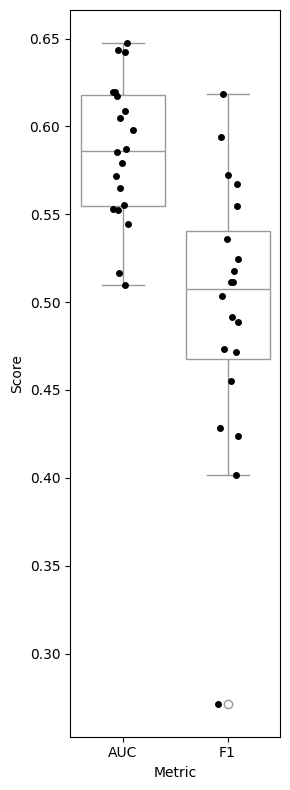

save this model to ./model_ckpt/over30_gds_model
0 of 20


train loss: 7.18e-01 | test loss: 1.02e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.98s/it]


0.5335169880624426 0.39010989010989 0.5795454545454546
1 of 20


train loss: 6.95e-01 | test loss: 1.03e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:09<00:00,  3.02s/it]


0.5095106913288732 0.3892857142857142 0.5681818181818182
2 of 20


train loss: 6.97e-01 | test loss: 1.05e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:09<00:00,  3.31s/it]


0.5230224321133412 -0.550420168067227 0.5340909090909091
3 of 20


train loss: 7.19e-01 | test loss: 9.72e-01 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.82s/it]


0.5836284927194019 0.09243697478991578 0.5909090909090909
4 of 20


train loss: 7.18e-01 | test loss: 9.99e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.92s/it]


0.5478158205430933 -0.20918367346938765 0.5511363636363636
5 of 20


train loss: 7.11e-01 | test loss: 1.06e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.97s/it]


0.5419126328217239 -0.010204081632652844 0.5625
6 of 20


train loss: 7.05e-01 | test loss: 1.06e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  3.00s/it]


0.5070182342909615 -0.7626728110599077 0.5170454545454546
7 of 20


train loss: 7.10e-01 | test loss: 1.05e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.92s/it]


0.48707857798766885 -1.4316770186335406 0.5056818181818182
8 of 20


train loss: 6.86e-01 | test loss: 1.14e+00 | reg: 1.51e+01 : 100%|████| 3/3 [00:08<00:00,  2.74s/it]


0.488128033582579 -3.1326530612244894 0.48863636363636365
9 of 20


train loss: 7.07e-01 | test loss: 9.90e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.92s/it]


0.5600157418339237 0.3479591836734693 0.5965909090909091
10 of 20


train loss: 6.99e-01 | test loss: 1.07e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:09<00:00,  3.01s/it]


0.5093795093795094 0.12832929782082309 0.5454545454545454
11 of 20


train loss: 7.01e-01 | test loss: 1.11e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:08<00:00,  2.72s/it]


0.5143644234553326 -0.028571428571428466 0.5454545454545454
12 of 20


train loss: 7.02e-01 | test loss: 1.02e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.78s/it]


0.5503082775810049 0.36619718309859145 0.6022727272727273
13 of 20


train loss: 7.04e-01 | test loss: 1.08e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.83s/it]


0.5003279548734094 0.13214285714285695 0.5397727272727273
14 of 20


train loss: 6.79e-01 | test loss: 1.15e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:09<00:00,  3.04s/it]


0.5030827758100486 0.41202090592334495 0.5738636363636364
15 of 20


train loss: 6.91e-01 | test loss: 1.07e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:08<00:00,  2.88s/it]


0.49665486029122397 -1.6632653061224487 0.5056818181818182
16 of 20


train loss: 7.09e-01 | test loss: 1.05e+00 | reg: 1.48e+01 : 100%|████| 3/3 [00:09<00:00,  3.06s/it]


0.4506099960645415 -30.178571428571423 0.44886363636363635
17 of 20


train loss: 6.93e-01 | test loss: 1.06e+00 | reg: 1.50e+01 : 100%|████| 3/3 [00:09<00:00,  3.18s/it]


0.5040010494555949 -0.2126623376623378 0.5284090909090909
18 of 20


train loss: 6.93e-01 | test loss: 1.05e+00 | reg: 1.49e+01 : 100%|████| 3/3 [00:09<00:00,  3.00s/it]


0.4839302112029385 -2.4033613445378155 0.48863636363636365
19 of 20


train loss: 7.19e-01 | test loss: 9.70e-01 | reg: 1.49e+01 : 100%|████| 3/3 [00:08<00:00,  2.98s/it]


0.564869473960383 0.48421926910299007 0.6079545454545454
0.5179588088678998
-1.8920270691802528
Statistics=47.0, p=0.029575347900390625


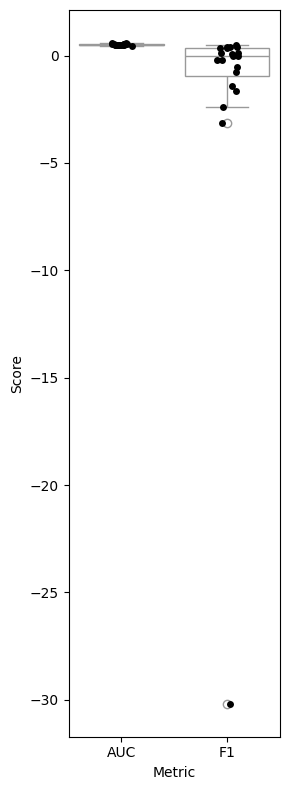

save this model to ./model_ckpt/over30_tmi_model


PicklingError: Can't pickle <function Symbolic_KANLayer.__init__.<locals>.<listcomp>.<listcomp>.<lambda> at 0x7f47f94227a0>: it's not found as kan.Symbolic_KANLayer.Symbolic_KANLayer.__init__.<locals>.<listcomp>.<listcomp>.<lambda>

In [28]:
models = {}
dfs = {}
ps = {}
for test in ['aes', 'suicide', 'cte', 'bri', 'bis', 'gds', 'tmi']: 
    o30_df, o30_p, o30_model = run_kan_limit_column(test, 'over_30', limit_value=1, width=[100, 2], steps=3, max_k=20)
    models[test] = o30_model 
    dfs[test] = o30_df 
    ps[test] = o30_p 
    o30_model.save_ckpt(f'over30_{test}_model')
    
joblib.dump({'models': models, 'dfs': dfs, 'ps': ps}, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/over30_kan_results.pkl')

In [29]:
out_data = {'dfs': dfs, 'ps': ps}
joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/over30_kan_results.pkl')

['/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/over30_kan_results.pkl']

In [ ]:
u30_df, u30_p, u30_model = run_kan_predict_both('cte', 'under_30', width=[16, 8, 4], steps=3, max_k=5)

0 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.6620603015075377 0.7618090452261307 0.6255924170616114
0.5576923076923077 0.40659340659340676 0.64
1 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.7751256281407035 0.7999086340794884 0.6540284360189573
0.7051282051282051 0.641025641025641 0.72
2 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.7688442211055276 0.7971676564641388 0.6492890995260664
0.6666666666666666 0.3846153846153846 0.68
3 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.7093802345058626 0.7176793056190042 0.5118483412322274
0.717948717948718 0.5961538461538461 0.72
4 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.740787269681742 0.7889447236180904 0.6350710900473934
0.6346153846153846 0.3846153846153846 0.68
5 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.6926298157453936 0.7738693467336684 0.7156398104265402
0.608974358974359 0.6223776223776224 0.64
6 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.7252931323283082 0.8157453936348409 0.7393364928909952
0.6794871794871795 0.5384615384615384 0.68
7 of 20


train loss: 9.97e-01 | test loss: 1.03e+00 | reg: 2.10e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.5489949748743719 0.6984924623115578 0.7156398104265402
0.5256410256410257 -0.5384615384615383 0.6
8 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.6783919597989949 0.7185929648241207 0.6018957345971564
0.5512820512820513 0.16923076923076918 0.64
9 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.24s/it]


0.7307370184254607 0.7678391959798995 0.6350710900473934
0.6153846153846154 0.30769230769230765 0.64
10 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.638609715242881 0.7219430485762144 0.6066350710900474
0.5192307692307692 -0.5384615384615383 0.6
11 of 20


train loss: 9.99e-01 | test loss: 1.02e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.592964824120603 0.7286432160804021 0.6161137440758294
0.4807692307692307 0.43589743589743596 0.56
12 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.7173366834170855 0.7642759250799451 0.5924170616113744
0.6987179487179487 0.6538461538461539 0.76
13 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:04<00:00,  1.41s/it]


0.6427973199329984 0.7587939698492463 0.6966824644549763
0.5512820512820512 0.16923076923076918 0.64
14 of 20


train loss: 9.96e-01 | test loss: 1.03e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.23s/it]


0.6365159128978224 0.7018425460636516 0.5781990521327014
0.6217948717948718 0.6643356643356643 0.68
15 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.5954773869346733 0.7211055276381909 0.6492890995260664
0.46153846153846156 0.5384615384615384 0.56
16 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.7805695142378559 0.7763819095477387 0.5781990521327014
0.717948717948718 0.5384615384615384 0.76
17 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6796482412060302 0.8304020100502513 0.7867298578199052
0.7243589743589743 0.6538461538461539 0.76
18 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.6901172529313233 0.7752398355413431 0.6113744075829384
0.4487179487179487 -0.5384615384615383 0.6
19 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.7127303182579565 0.7618090452261307 0.6255924170616114
0.6602564102564102 0.6538461538461539 0.64
0.6859505862646567
0.7590242881072027
Statistics=0.0, p=1.9073486328125e-06
Statistics=12.5, p=0.0001678466796875


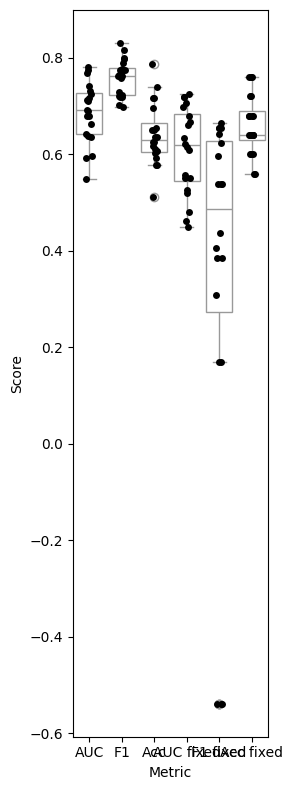

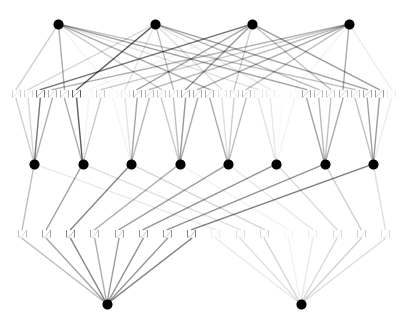

In [46]:
u30_df, u30_p, u30_model = run_kan_predict_both('cte', 'under_30', width=[2, 8, 4], steps=3, max_k=20)
u30_model.plot()

In [52]:
np.mean(u30_df['AUC fixed'])

0.6073717948717949

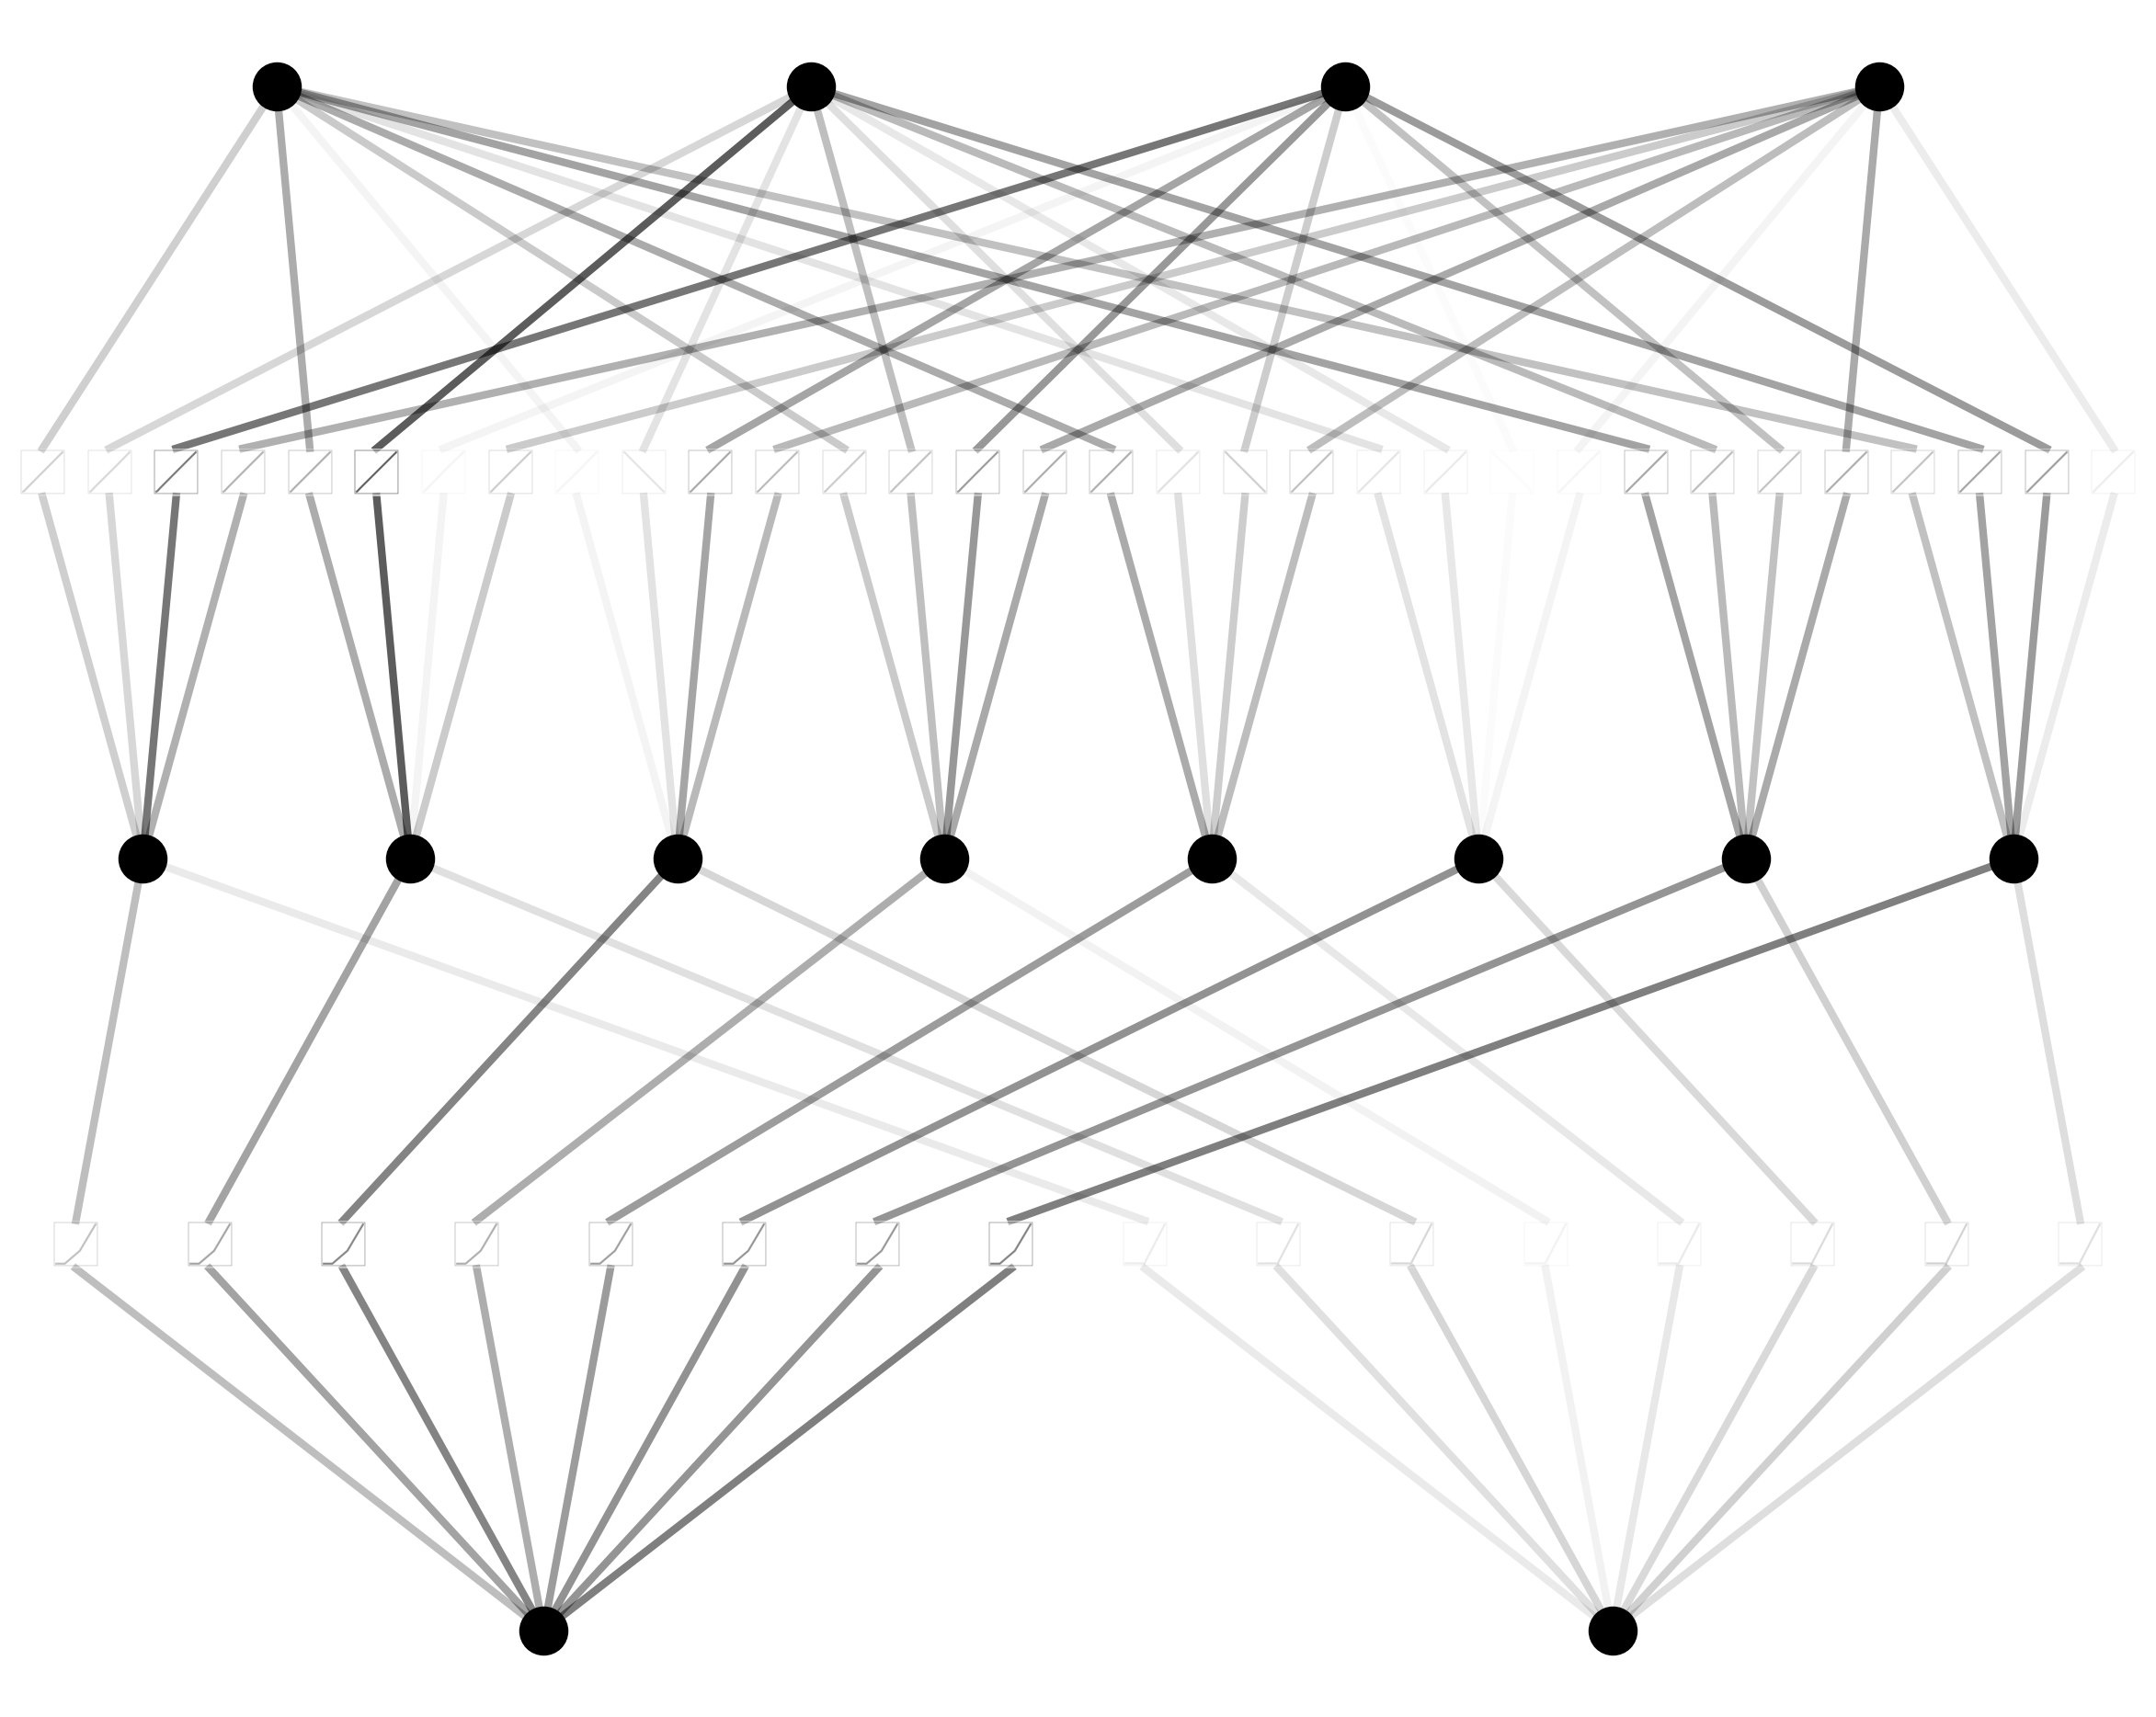

In [51]:
# u30_model.prune()
u30_model.plot(mask=True, scale=3.0)

0 of 20


train loss: 9.16e-01 | test loss: 9.34e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.45447154471544715 0.5853658536585366 0.1943127962085308
0.5277777777777778 0.6666666666666666 0.5
1 of 20


train loss: 9.16e-01 | test loss: 9.28e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:04<00:00,  1.42s/it]


0.5520325203252032 0.9195121951219511 0.9478672985781991
0.6296296296296297 0.7222222222222222 0.7916666666666666
2 of 20


train loss: 9.20e-01 | test loss: 9.26e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.4479674796747967 0.8682926829268293 0.957345971563981
0.6851851851851852 0.7916666666666667 0.7916666666666666
3 of 20


train loss: 9.25e-01 | test loss: 9.13e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.43333333333333335 0.9121951219512195 0.943127962085308
0.3425925925925925 0.5 0.75
4 of 20


train loss: 9.24e-01 | test loss: 9.18e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.28048780487804875 0.5121951219512195 0.052132701421800945
0.31481481481481477 0.25000000000000006 0.625
5 of 20


train loss: 9.14e-01 | test loss: 9.34e-01 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.5357723577235772 0.6634146341463414 0.5639810426540285
0.4537037037037037 0.5 0.625
6 of 20


train loss: 9.19e-01 | test loss: 9.28e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.526829268292683 0.9414634146341463 0.9620853080568721
0.6203703703703703 0.6666666666666666 0.5
7 of 20


train loss: 9.17e-01 | test loss: 9.28e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.2959349593495936 0.5219512195121951 0.07109004739336493
0.48148148148148145 0.6 0.5
8 of 20


train loss: 9.07e-01 | test loss: 9.51e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]


0.4170731707317073 0.824390243902439 0.943127962085308
0.39814814814814814 0.1666666666666666 0.7916666666666666
9 of 20


train loss: 9.22e-01 | test loss: 9.16e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.45121951219512185 0.746341463414634 0.7535545023696683
0.5740740740740741 0.6666666666666666 0.75
10 of 20


train loss: 9.19e-01 | test loss: 9.20e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.3886178861788617 0.8902439024390244 0.9289099526066351
0.5555555555555556 0.5833333333333333 0.7916666666666666
11 of 20


train loss: 9.16e-01 | test loss: 9.39e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.19430894308943092 0.5170731707317073 0.061611374407582936
0.3981481481481482 0.5666666666666667 0.4583333333333333
12 of 20


train loss: 9.19e-01 | test loss: 9.26e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.40731707317073174 0.8975609756097561 0.966824644549763
0.5277777777777778 0.6 0.5
13 of 20


train loss: 9.16e-01 | test loss: 9.25e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.39999999999999997 0.5609756097560975 0.14691943127962084
0.36111111111111116 0.5555555555555556 0.3333333333333333
14 of 20


train loss: 9.22e-01 | test loss: 9.16e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.3772357723577236 0.5829268292682926 0.7298578199052133
0.2962962962962963 0.5277777777777778 0.2916666666666667
15 of 20


train loss: 9.04e-01 | test loss: 9.56e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.589430894308943 0.8170731707317072 0.7630331753554502
0.6203703703703703 0.75 0.75
16 of 20


train loss: 9.23e-01 | test loss: 9.25e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.532520325203252 0.5951219512195122 0.2132701421800948
0.7407407407407407 0.75 0.75
17 of 20


train loss: 9.17e-01 | test loss: 9.27e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.4146341463414634 0.5756097560975608 0.17535545023696683
0.6018518518518519 0.6944444444444445 0.5416666666666666
18 of 20


train loss: 9.17e-01 | test loss: 9.24e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.5081300813008129 0.7804878048780488 0.8578199052132701
0.4444444444444444 0.41666666666666674 0.7083333333333334
19 of 20


train loss: 9.23e-01 | test loss: 9.07e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.6089430894308943 0.8536585365853658 0.8104265402843602
0.5185185185185186 0.6666666666666666 0.6666666666666666
0.4408130081300813
0.7282926829268292
Statistics=44.0, p=0.021484375
Statistics=99.5, p=0.8694877624511719


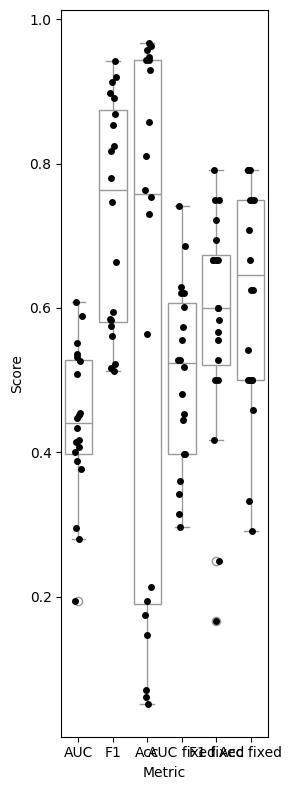

0 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:04<00:00,  1.45s/it]


0.6694169416941693 0.7054455445544555 0.43601895734597157
0.3851851851851852 0.5666666666666668 0.4583333333333333
1 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:04<00:00,  1.40s/it]


0.627062706270627 0.6686262376237624 0.43601895734597157
0.4518518518518519 0.10000000000000009 0.625
2 of 20


train loss: 1.00e+00 | test loss: 1.03e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:04<00:00,  1.46s/it]


0.6694169416941694 0.774045261669024 0.6635071090047393
0.6148148148148148 0.30000000000000004 0.7083333333333334
3 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.25s/it]


0.5715071507150715 0.6806930693069307 0.5924170616113744
0.5185185185185185 0.4 0.75
4 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.6281628162816281 0.7995049504950495 0.7440758293838863
0.4814814814814814 -0.2000000000000001 0.6666666666666666
5 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.6584158415841583 0.7623762376237624 0.6966824644549763
0.6074074074074074 0.58 0.7083333333333334
6 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6358635863586358 0.6944837340876945 0.5450236966824644
0.45925925925925926 0.30000000000000004 0.7083333333333334
7 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.7249724972497249 0.8366336633663366 0.7914691943127962
0.6148148148148148 0.6 0.6666666666666666
8 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.23s/it]


0.5962596259625962 0.7263083451202264 0.5924170616113744
0.3851851851851852 0.5666666666666668 0.4583333333333333
9 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]


0.6232123212321232 0.7167609618104669 0.5781990521327014
0.5481481481481482 0.45999999999999996 0.625
10 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.671067106710671 0.739038189533239 0.6113744075829384
0.5333333333333333 0.4 0.6666666666666666
11 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.5495049504950495 0.6472772277227722 0.5497630331753555
0.40740740740740744 0.5666666666666668 0.4583333333333333
12 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.4625962596259626 0.6881188118811882 0.6682464454976303
0.37777777777777777 -1.4 0.6666666666666666
13 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.10e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.4108910891089109 0.7029702970297029 0.8104265402843602
0.3111111111111111 -1.4 0.6666666666666666
14 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.13e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.6133113311331133 0.7326732673267328 0.6587677725118484
0.4666666666666667 0.10000000000000009 0.625
15 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]
/tmp/ipykernel_115959/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)


0.48514851485148514 0.6658415841584159 0.6445497630331753
0.3555555555555555 -inf 0.625
16 of 20


train loss: 1.01e+00 | test loss: 1.03e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.504950495049505 0.6702970297029703 0.6492890995260664
0.4296296296296296 -1.4 0.6666666666666666
17 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.5687568756875687 0.7103960396039605 0.6919431279620853
0.4888888888888889 0.30000000000000004 0.7083333333333334
18 of 20


train loss: 1.01e+00 | test loss: 1.02e+00 | reg: 2.11e+01 : 100%|████| 3/3 [00:03<00:00,  1.11s/it]


0.5473047304730473 0.7048267326732675 0.7488151658767772
0.37777777777777777 -1.6999999999999997 0.625
19 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6331133113311331 0.6584158415841584 0.3459715639810427
0.3407407407407407 0.5666666666666668 0.4583333333333333
0.5925467546754676
0.7142366513437058
Statistics=13.0, p=0.0001678466796875
Statistics=52.5, p=0.04844093322753906


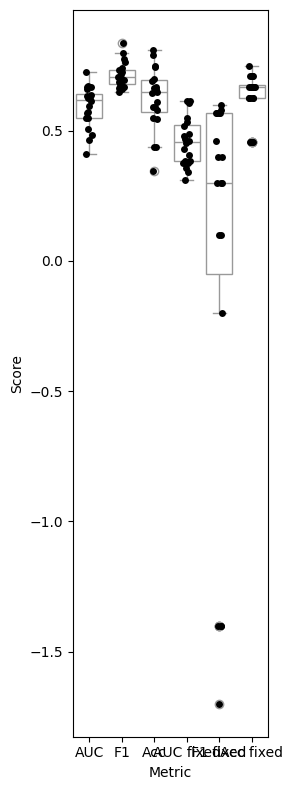

0 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.6182266009852216 0.7674876847290639 0.7203791469194313
0.5703125 0.5 0.75
1 of 20


train loss: 9.97e-01 | test loss: 1.03e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.5708128078817734 0.7832512315270935 0.7393364928909952
0.546875 0.6000000000000001 0.6666666666666666
2 of 20


train loss: 1.01e+00 | test loss: 1.00e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.6945812807881773 0.7607318789584798 0.5971563981042654
0.4921875 -0.7499999999999999 0.7083333333333334
3 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.6533251231527093 0.779967159277504 0.6824644549763034
0.6484375 0.7083333333333333 0.7083333333333334
4 of 20


train loss: 1.01e+00 | test loss: 1.00e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6582512315270936 0.7733990147783251 0.6729857819905213
0.5546875 0.4166666666666667 0.7083333333333334
5 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.6681034482758621 0.749472202674173 0.5781990521327014
0.609375 0.6875000000000001 0.5833333333333334
6 of 20


train loss: 1.01e+00 | test loss: 1.00e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6884236453201971 0.7382125263898662 0.5592417061611374
0.484375 0.0 0.6666666666666666
7 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.7955665024630542 0.8226600985221675 0.6587677725118484
0.671875 0.7499999999999999 0.7083333333333334
8 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6958128078817734 0.9343185550082101 0.95260663507109
0.6015625 0.5833333333333333 0.7916666666666666
9 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.7038177339901477 0.7733990147783251 0.6729857819905213
0.59375 0.5833333333333333 0.7916666666666666
10 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.5024630541871922 0.6374384236453201 0.5639810426540285
0.234375 0.53125 0.375
11 of 20


train loss: 1.01e+00 | test loss: 1.00e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.7426108374384236 0.8085855031667839 0.6777251184834123
0.6953125 0.7499999999999999 0.75
12 of 20


train loss: 1.00e+00 | test loss: 1.02e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.7383004926108375 0.8660098522167488 0.8388625592417062
0.7265625 0.7499999999999999 0.7916666666666666
13 of 20


train loss: 1.00e+00 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:04<00:00,  1.44s/it]


0.48337438423645324 0.7438423645320196 0.9383886255924171
0.3671875 -0.7499999999999999 0.7083333333333334
14 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:04<00:00,  1.46s/it]


0.5406403940886699 0.6748768472906403 0.6872037914691943
0.4140625 -0.7499999999999999 0.7083333333333334
15 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.10e+01 : 100%|████| 3/3 [00:04<00:00,  1.46s/it]


0.7475369458128079 0.8001407459535537 0.6635071090047393
0.625 0.5 0.75
16 of 20


train loss: 1.01e+00 | test loss: 1.00e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:04<00:00,  1.35s/it]


0.7924876847290641 0.8142153413089372 0.6872037914691943
0.546875 0.5 0.6666666666666666
17 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:04<00:00,  1.40s/it]


0.7438423645320197 0.7832512315270935 0.6350710900473934
0.6328125 0.6249999999999999 0.75
18 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:04<00:00,  1.47s/it]


0.708128078817734 0.8226600985221675 0.6587677725118484
0.515625 0.7499999999999999 0.6666666666666666
19 of 20


train loss: 1.01e+00 | test loss: 1.01e+00 | reg: 2.09e+01 : 100%|████| 3/3 [00:04<00:00,  1.43s/it]


0.6108374384236452 0.7438423645320196 0.6303317535545023
0.4296875 0.5714285714285714 0.5
0.6678571428571429
0.7788881069669247
Statistics=2.0, p=5.7220458984375e-06
Statistics=54.5, p=0.06372261047363281


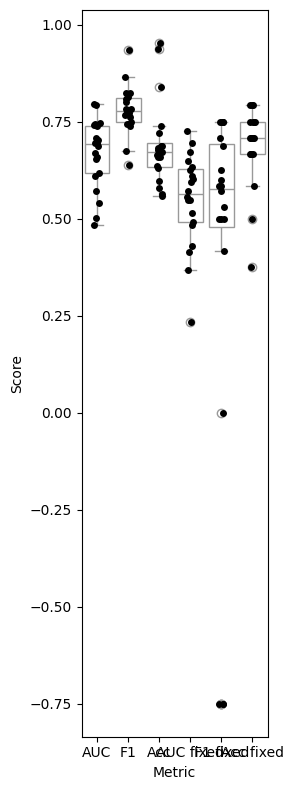

0 of 20


train loss: 9.99e-01 | test loss: 9.88e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:04<00:00,  1.48s/it]


0.5423542354235423 0.6658415841584159 0.5734597156398105
0.362962962962963 -0.2000000000000001 0.6666666666666666
1 of 20


train loss: 9.94e-01 | test loss: 1.00e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:04<00:00,  1.39s/it]


0.6831683168316832 0.7517680339462518 0.6303317535545023
0.5111111111111111 0.6 0.5
2 of 20


train loss: 9.94e-01 | test loss: 1.00e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.5720572057205722 0.7215346534653465 0.6445497630331753
0.5259259259259259 0.5499999999999999 0.75
3 of 20


train loss: 9.95e-01 | test loss: 1.00e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.504950495049505 0.6212871287128713 0.5971563981042654
0.31851851851851853 -1.6999999999999997 0.625
4 of 20


train loss: 9.95e-01 | test loss: 1.00e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]


0.7233223322332233 0.8477722772277227 0.8056872037914692
0.6296296296296297 0.625 0.7916666666666666
5 of 20


train loss: 9.94e-01 | test loss: 9.96e-01 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.11s/it]


0.5869086908690869 0.7103960396039605 0.6303317535545023
0.43703703703703706 0.10000000000000009 0.625
6 of 20


train loss: 9.99e-01 | test loss: 9.88e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.7299229922992299 0.7867751060820368 0.6824644549763034
0.5333333333333333 0.45999999999999996 0.625
7 of 20


train loss: 9.97e-01 | test loss: 9.95e-01 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.6886688668866887 0.7475247524752476 0.6777251184834123
0.5629629629629629 0.19999999999999993 0.6666666666666666
8 of 20


train loss: 9.99e-01 | test loss: 1.02e+00 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.3773377337733773 0.7623762376237624 0.8483412322274881
0.3185185185185185 -1.4 0.6666666666666666
9 of 20


train loss: 9.96e-01 | test loss: 9.98e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:04<00:00,  1.58s/it]


0.5066006600660067 0.7271039603960396 0.7677725118483413
0.3333333333333333 -1.6999999999999997 0.625
10 of 20


train loss: 9.96e-01 | test loss: 1.00e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:04<00:00,  1.58s/it]


0.5968096809680968 0.6435643564356436 0.3175355450236967
0.4222222222222222 0.10000000000000009 0.625
11 of 20


train loss: 9.88e-01 | test loss: 1.02e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:04<00:00,  1.34s/it]


0.4235423542354235 0.6658415841584159 0.8578199052132701
0.3111111111111111 0.5333333333333333 0.4166666666666667
12 of 20


train loss: 9.94e-01 | test loss: 9.99e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:04<00:00,  1.44s/it]


0.6875687568756875 0.7167609618104669 0.5781990521327014
0.4814814814814815 0.4 0.6666666666666666
13 of 20


train loss: 9.93e-01 | test loss: 1.01e+00 | reg: 2.04e+01 : 100%|████| 3/3 [00:04<00:00,  1.39s/it]


0.4356435643564356 0.5247524752475248 0.09004739336492891
0.3037037037037037 -1.4 0.6666666666666666
14 of 20


train loss: 9.97e-01 | test loss: 9.93e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:04<00:00,  1.42s/it]


0.7486248624862487 0.8078589108910891 0.6729857819905213
0.6666666666666666 0.6625 0.625
15 of 20


train loss: 9.99e-01 | test loss: 9.89e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.693069306930693 0.770862800565771 0.6587677725118484
0.5111111111111112 -0.049999999999999954 0.7083333333333334
16 of 20


train loss: 9.94e-01 | test loss: 1.00e+00 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.6721672167216721 0.7676803394625177 0.6540284360189573
0.6444444444444445 0.64 0.75
17 of 20


train loss: 9.93e-01 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.539053905390539 0.7014851485148516 0.6824644549763034
0.5555555555555556 0.5874999999999999 0.5416666666666666
18 of 20


train loss: 9.96e-01 | test loss: 9.96e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.533003300330033 0.7148514851485149 0.6966824644549763
0.4444444444444445 0.19999999999999993 0.6666666666666666
19 of 20


train loss: 9.92e-01 | test loss: 1.00e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]
/tmp/ipykernel_115959/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)


0.4460946094609461 0.599009900990099 0.6587677725118484
0.28888888888888886 -inf 0.625
0.5845434543454345
0.7127523868458274
Statistics=34.0, p=0.006389617919921875
Statistics=65.0, p=0.14290618896484375


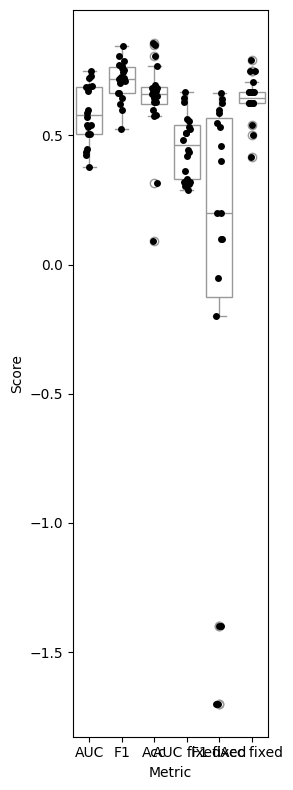

0 of 20


train loss: 9.99e-01 | test loss: 9.94e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.6706467661691542 0.7816473189607519 0.6255924170616114
0.45 -0.19047619047619058 0.5833333333333334
1 of 20


train loss: 9.93e-01 | test loss: 1.01e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.5323383084577114 0.8109452736318409 0.8199052132701422
0.39285714285714285 0.2857142857142857 0.5833333333333334
2 of 20


train loss: 9.94e-01 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.5830845771144278 0.7927031509121063 0.7630331753554502
0.38571428571428573 -2.214285714285715 0.625
3 of 20


train loss: 9.96e-01 | test loss: 9.96e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.5706467661691541 0.7867803837953092 0.7156398104265402
0.40714285714285714 0.48979591836734704 0.5833333333333334
4 of 20


train loss: 9.98e-01 | test loss: 9.90e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.6029850746268657 0.722814498933902 0.6303317535545023
0.3857142857142857 -2.214285714285715 0.625
5 of 20


train loss: 9.94e-01 | test loss: 1.00e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6144278606965173 0.722814498933902 0.6303317535545023
0.4857142857142857 0.2857142857142857 0.5833333333333334
6 of 20


train loss: 1.00e+00 | test loss: 9.88e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.5766169154228856 0.8116560056858566 0.7488151658767772
0.4571428571428571 0.5408163265306124 0.625
7 of 20


train loss: 1.00e+00 | test loss: 9.90e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]


0.5671641791044777 0.7462686567164181 0.7582938388625592
0.38571428571428573 -0.6071428571428571 0.625
8 of 20


train loss: 9.93e-01 | test loss: 1.01e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]


0.609950248756219 0.7938877043354656 0.7251184834123223
0.5785714285714286 0.5408163265306124 0.625
9 of 20


train loss: 9.92e-01 | test loss: 1.01e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.13s/it]
/tmp/ipykernel_115959/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)


0.4840796019900497 0.6393034825870648 0.7251184834123223
0.19285714285714287 -inf 0.5833333333333334
10 of 20


train loss: 9.93e-01 | test loss: 1.00e+00 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.5825870646766169 0.7441364605543711 0.6587677725118484
0.42142857142857143 0.40476190476190466 0.5833333333333334
11 of 20


train loss: 9.95e-01 | test loss: 9.98e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.5263681592039802 0.6724709784411278 0.6255924170616114
0.27142857142857146 0.5357142857142858 0.4583333333333333
12 of 20


train loss: 9.86e-01 | test loss: 1.03e+00 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.5751243781094528 0.6908315565031985 0.5876777251184834
0.40714285714285714 0.01785714285714269 0.5416666666666666
13 of 20


train loss: 9.92e-01 | test loss: 1.01e+00 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6378109452736318 0.7263681592039802 0.6350710900473934
0.4857142857142857 0.5714285714285715 0.5
14 of 20


train loss: 1.00e+00 | test loss: 9.84e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]


0.6567164179104479 0.7157071783937455 0.6208530805687204
0.4 -2.214285714285715 0.625
15 of 20


train loss: 9.96e-01 | test loss: 9.95e-01 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.6497512437810945 0.6849087893864014 0.4597156398104265
0.35 0.48412698412698424 0.4583333333333333
16 of 20


train loss: 1.00e+00 | test loss: 9.91e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.645273631840796 0.8507462686567165 0.8009478672985783
0.37857142857142856 0.48979591836734704 0.5833333333333334
17 of 20


train loss: 9.93e-01 | test loss: 1.01e+00 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.6233830845771144 0.7201492537313434 0.5734597156398105
0.5214285714285715 0.5408163265306124 0.625
18 of 20


train loss: 9.95e-01 | test loss: 1.00e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.5925373134328359 0.767827529021559 0.7345971563981043
0.5214285714285714 0.19642857142857137 0.625
19 of 20


train loss: 9.90e-01 | test loss: 1.02e+00 | reg: 2.06e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]
/tmp/ipykernel_115959/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)


0.41940298507462687 0.6766169154228857 0.6919431279620853
0.29285714285714287 -inf 0.5833333333333334
0.5860447761194029
0.7429292031903973
Statistics=9.0, p=6.29425048828125e-05
Statistics=15.0, p=0.0002613067626953125


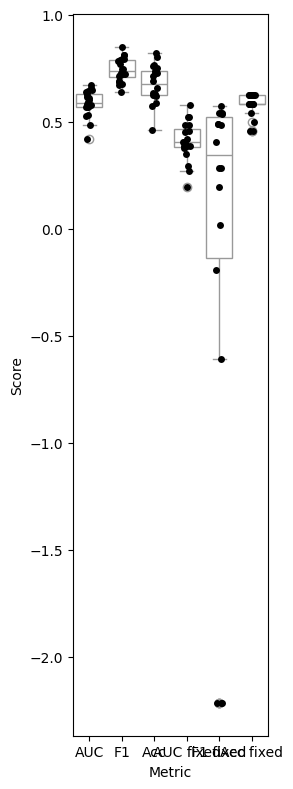

0 of 20


train loss: 8.35e-01 | test loss: 8.31e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.24s/it]


0.7037414965986394 0.7576530612244897 0.6398104265402843
0.6266666666666666 0.14285714285714288 0.68
1 of 20


train loss: 8.31e-01 | test loss: 8.43e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6812925170068027 0.7634508348794062 0.6777251184834123
0.54 0.4545454545454544 0.68
2 of 20


train loss: 8.29e-01 | test loss: 8.41e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.20s/it]


0.6663265306122449 0.767219387755102 0.6540284360189573
0.6933333333333332 0.6250000000000001 0.76
3 of 20


train loss: 8.34e-01 | test loss: 8.34e-01 | reg: 2.11e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.6880952380952381 0.7640306122448978 0.6492890995260664
0.4533333333333333 -9.499999999999998 0.44
4 of 20


train loss: 8.35e-01 | test loss: 8.40e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.6312925170068027 0.7530148423005565 0.6635071090047393
0.3933333333333333 0.5500000000000002 0.64
5 of 20


train loss: 8.31e-01 | test loss: 8.44e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.591156462585034 0.7130102040816326 0.6445497630331753
0.4066666666666667 -0.4999999999999999 0.52
6 of 20


train loss: 8.33e-01 | test loss: 8.37e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.6578231292517006 0.7780612244897958 0.7251184834123223
0.5266666666666666 0.3250000000000002 0.64
7 of 20


train loss: 8.35e-01 | test loss: 8.32e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.12s/it]


0.676530612244898 0.767219387755102 0.6540284360189573
0.64 0.035714285714285955 0.64
8 of 20


train loss: 8.35e-01 | test loss: 8.41e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.6370748299319728 0.805194805194805 0.7345971563981043
0.5466666666666666 0.4000000000000001 0.68
9 of 20


train loss: 8.29e-01 | test loss: 8.51e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.19s/it]


0.5836734693877551 0.7015306122448979 0.6303317535545023
0.5933333333333333 0.24999999999999994 0.64
10 of 20


train loss: 8.31e-01 | test loss: 8.41e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.6707482993197279 0.7385204081632653 0.6113744075829384
0.5466666666666666 -0.65 0.56
11 of 20


train loss: 8.34e-01 | test loss: 8.34e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.7357142857142857 0.782182103610675 0.6492890995260664
0.5866666666666667 0.06250000000000022 0.6
12 of 20


train loss: 8.34e-01 | test loss: 8.36e-01 | reg: 2.04e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6704081632653062 0.8134566326530612 0.8151658767772512
0.58 -0.12500000000000006 0.64
13 of 20


train loss: 8.36e-01 | test loss: 8.41e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.14s/it]


0.7006802721088436 0.8027864992150706 0.6824644549763034
0.42666666666666664 0.5500000000000002 0.64
14 of 20


train loss: 8.32e-01 | test loss: 8.45e-01 | reg: 2.09e+01 : 100%|████| 3/3 [00:03<00:00,  1.18s/it]


0.6673469387755103 0.7640306122448978 0.6492890995260664
0.6066666666666667 -0.2500000000000001 0.6
15 of 20


train loss: 8.30e-01 | test loss: 8.48e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.16s/it]


0.6030612244897959 0.7077922077922076 0.6018957345971564
0.5133333333333333 -3.875 0.48
16 of 20


train loss: 8.35e-01 | test loss: 8.45e-01 | reg: 2.07e+01 : 100%|████| 3/3 [00:03<00:00,  1.17s/it]


0.6680272108843538 0.7640306122448978 0.6492890995260664
0.5266666666666666 0.4375000000000001 0.64
17 of 20


train loss: 8.35e-01 | test loss: 8.34e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.21s/it]


0.6710884353741496 0.7674646781789638 0.6255924170616114
0.6466666666666667 0.035714285714285955 0.64
18 of 20


train loss: 8.30e-01 | test loss: 8.47e-01 | reg: 2.05e+01 : 100%|████| 3/3 [00:03<00:00,  1.24s/it]


0.6037414965986394 0.7397959183673469 0.6777251184834123
0.5599999999999999 0.3250000000000002 0.64
19 of 20


train loss: 8.29e-01 | test loss: 8.52e-01 | reg: 2.08e+01 : 100%|████| 3/3 [00:03<00:00,  1.15s/it]


0.5945578231292517 0.7015306122448979 0.6303317535545023
0.3533333333333334 -3.875 0.48
0.6551190476190476
0.7575987628442986
Statistics=0.0, p=1.9073486328125e-06
Statistics=61.5, p=0.11398696899414062


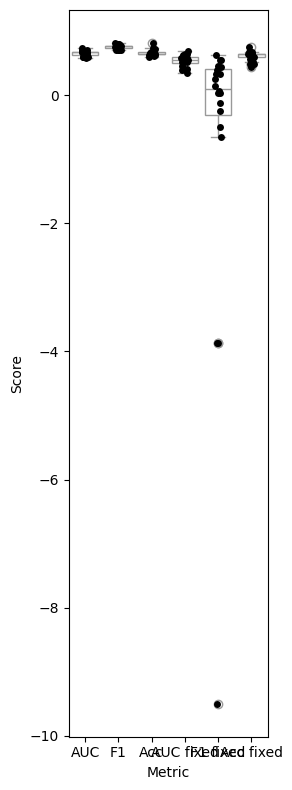

In [55]:
u30_bis_df, u30_bis_p, u30_bis_model = run_kan_predict_both('bis', 'under_30', width=[2, 8, 4], steps=3, max_k=20)
u30_bri_df, u30_bri_p, u30_bri_model = run_kan_predict_both('bri', 'under_30', width=[2, 8, 4], steps=3, max_k=20)
u30_tmi_df, u30_tmi_p, u30_tmi_model = run_kan_predict_both('tmi', 'under_30', width=[2, 8, 4], steps=3, max_k=20)
u30_aes_df, u30_aes_p, u30_aes_model = run_kan_predict_both('aes', 'under_30', width=[2, 8, 4], steps=3, max_k=20)
u30_gds_df, u30_gds_p, u30_gds_model = run_kan_predict_both('gds', 'under_30', width=[2, 8, 4], steps=3, max_k=20)
u30_suicide_df, u30_suicide_p, u30_suicide_model = run_kan_predict_both('suicide', 'under_30', width=[2, 8, 4], steps=3, max_k=20)

In [56]:
out_data = {
    'cte':{'df': u30_df.to_numpy(), 'p': u30_p, 'model': u30_model.cpu().state_dict()},
    'bis':{'df': u30_bis_df.to_numpy(), 'p': u30_bis_p, 'model': u30_bis_model.cpu().state_dict()},
    'bri':{'df': u30_bri_df.to_numpy(), 'p': u30_bri_p, 'model': u30_bri_model.cpu().state_dict()},
    'tmi':{'df': u30_tmi_df.to_numpy(), 'p': u30_tmi_p, 'model': u30_tmi_model.cpu().state_dict()},
    'gds':{'df': u30_gds_df.to_numpy(), 'p': u30_gds_p, 'model': u30_gds_model.cpu().state_dict()},
    'aes':{'df': u30_aes_df.to_numpy(), 'p': u30_aes_p, 'model': u30_aes_model.cpu().state_dict()},
    'suicide':{'df': u30_suicide_df.to_numpy(), 'p': u30_suicide_p, 'model': u30_suicide_model.cpu().state_dict()},
}

joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_small.pkl')

u30_model.save_ckpt('u30_cte_model_small')
u30_bis_model.save_ckpt('u30_bis_model_small')
u30_bri_model.save_ckpt('u30_bri_model_small')
u30_tmi_model.save_ckpt('u30_tmi_model_small')
u30_gds_model.save_ckpt('u30_gds_model_small')
u30_aes_model.save_ckpt('u30_aes_model_small')
u30_suicide_model.save_ckpt('u30_suicide_model_small')

save this model to ./model_ckpt/u30_cte_model_small
save this model to ./model_ckpt/u30_bis_model_small
save this model to ./model_ckpt/u30_bri_model_small
save this model to ./model_ckpt/u30_tmi_model_small
save this model to ./model_ckpt/u30_gds_model_small
save this model to ./model_ckpt/u30_aes_model_small
save this model to ./model_ckpt/u30_suicide_model_small


0 of 20


train loss: 2.35e-01 | test loss: 3.23e+00 | reg: 5.56e+01 : 100%|████| 5/5 [01:55<00:00, 23.18s/it]


0.8098827470686768 0.8552763819095478 0.7725118483412322
0.41666666666666663 0.15384615384615385 0.56
1 of 20


train loss: 2.91e-01 | test loss: 3.41e+00 | reg: 5.84e+01 : 100%|████| 5/5 [01:47<00:00, 21.58s/it]


0.8739530988274707 0.8793969849246233 0.7914691943127962
0.6474358974358974 0.4615384615384615 0.72
2 of 20


train loss: 2.76e-01 | test loss: 3.23e+00 | reg: 5.54e+01 : 100%|████| 5/5 [01:49<00:00, 21.99s/it]


0.8180485762144053 0.9170854271356784 0.8957345971563981
0.6858974358974359 0.5384615384615384 0.72
3 of 20


train loss: 3.44e-01 | test loss: 3.40e+00 | reg: 6.08e+01 : 100%|████| 5/5 [01:47<00:00, 21.41s/it]


0.8220268006700167 0.8402010050251255 0.7488151658767772
0.5384615384615384 0.34065934065934084 0.6
4 of 20


train loss: 2.14e-01 | test loss: 3.75e+00 | reg: 5.89e+01 : 100%|████| 5/5 [01:48<00:00, 21.78s/it]


0.8310301507537688 0.8693467336683418 0.8151658767772512
0.6057692307692307 0.5384615384615384 0.68
5 of 20


train loss: 2.71e-01 | test loss: 3.70e+00 | reg: 6.30e+01 : 100%|████| 5/5 [01:52<00:00, 22.48s/it]


0.7139865996649917 0.7286432160804021 0.5308056872037915
0.3076923076923077 -0.5384615384615383 0.6
6 of 20


train loss: 2.75e-01 | test loss: 3.43e+00 | reg: 5.79e+01 : 100%|████| 5/5 [01:55<00:00, 23.16s/it]


0.8647403685092128 0.8718592964824122 0.7582938388625592
0.4807692307692307 0.6153846153846154 0.6
7 of 20


train loss: 3.25e-01 | test loss: 3.50e+00 | reg: 6.09e+01 : 100%|████| 5/5 [01:50<00:00, 22.07s/it]


0.8446398659966499 0.8492462311557788 0.7393364928909952
0.5192307692307692 -0.038461538461538415 0.64
8 of 20


train loss: 2.89e-01 | test loss: 3.29e+00 | reg: 6.15e+01 : 100%|████| 5/5 [01:56<00:00, 23.21s/it]


0.8546901172529313 0.8824120603015077 0.8151658767772512
0.5576923076923077 0.6223776223776224 0.64
9 of 20


train loss: 2.05e-01 | test loss: 3.31e+00 | reg: 6.30e+01 : 100%|████| 5/5 [01:56<00:00, 23.32s/it]


0.7891541038525962 0.8291457286432161 0.7582938388625592
0.5512820512820513 -0.038461538461538415 0.64
10 of 20


train loss: 2.07e-01 | test loss: 3.99e+00 | reg: 6.31e+01 : 100%|████| 5/5 [01:57<00:00, 23.46s/it]


0.852177554438861 0.8739150296939243 0.7819905213270142
0.5448717948717948 0.5804195804195804 0.6
11 of 20


train loss: 2.96e-01 | test loss: 3.10e+00 | reg: 5.70e+01 : 100%|████| 5/5 [01:49<00:00, 21.81s/it]


0.687604690117253 0.8449389806173725 0.8293838862559242
0.35256410256410253 -4.076923076923077 0.56
12 of 20


train loss: 2.14e-01 | test loss: 3.45e+00 | reg: 5.92e+01 : 100%|████| 5/5 [01:53<00:00, 22.61s/it]


0.8293551088777219 0.9128978224455613 0.8767772511848341
0.7243589743589745 0.5384615384615384 0.76
13 of 20


train loss: 3.11e-01 | test loss: 3.44e+00 | reg: 5.77e+01 : 100%|████| 5/5 [01:55<00:00, 23.14s/it]


0.7847571189279732 0.7919597989949748 0.6729857819905213
0.41025641025641024 0.5384615384615384 0.52
14 of 20


train loss: 2.64e-01 | test loss: 3.62e+00 | reg: 6.09e+01 : 100%|████| 5/5 [01:47<00:00, 21.56s/it]


0.8507118927973198 0.8974874371859297 0.8388625592417062
0.6378205128205128 0.3846153846153846 0.68
15 of 20


train loss: 2.25e-01 | test loss: 3.50e+00 | reg: 5.88e+01 : 100%|████| 5/5 [01:52<00:00, 22.52s/it]


0.7776381909547738 0.7724988579259936 0.6066350710900474
0.5448717948717948 -0.038461538461538415 0.64
16 of 20


train loss: 3.41e-01 | test loss: 3.54e+00 | reg: 6.02e+01 : 100%|████| 5/5 [02:04<00:00, 24.98s/it]


0.8130234505862646 0.8860971524288108 0.8388625592417062
0.6730769230769231 0.5384615384615384 0.76
17 of 20


train loss: 2.09e-01 | test loss: 3.98e+00 | reg: 6.23e+01 : 100%|████| 5/5 [01:47<00:00, 21.50s/it]


0.8333333333333334 0.885427135678392 0.8199052132701422
0.6666666666666667 0.6769230769230768 0.72
18 of 20


train loss: 1.93e-01 | test loss: 3.36e+00 | reg: 5.97e+01 : 100%|████| 5/5 [01:46<00:00, 21.36s/it]


0.7885259631490786 0.8425460636515912 0.7772511848341233
0.40384615384615385 0.576923076923077 0.56
19 of 20


train loss: 2.00e-01 | test loss: 3.52e+00 | reg: 6.34e+01 : 100%|████| 5/5 [01:43<00:00, 20.66s/it]


0.8316582914572865 0.8982412060301508 0.8720379146919431
0.5064102564102564 0.07692307692307698 0.6
0.8135469011725294
0.8564311274989667
Statistics=0.0, p=1.9073486328125e-06
Statistics=67.0, p=0.16495704650878906


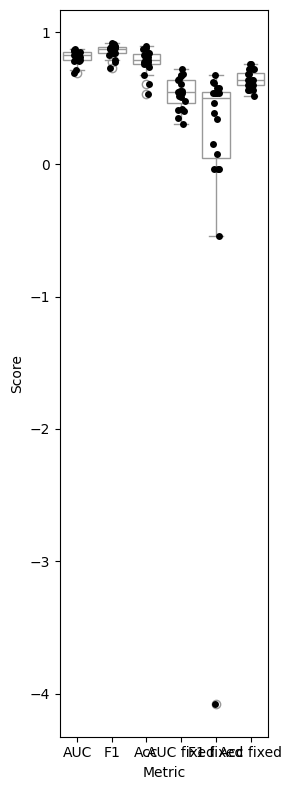

In [18]:
u30_df, u30_p, u30_model = run_kan_predict_both('cte', 'under_30', width=[100, 16, 4], steps=5, max_k=20)

In [22]:
np.unique(rhi[rhi['agedeath'] <=30]['cte'], return_counts=True)

(array([0, 1]), array([42, 41]))

In [24]:
expected_acc = 42/83

In [30]:
stat, p = wilcoxon(u30_df['Acc fixed']-expected_acc)
print(p)
print(stat)
print('AUC', np.mean(u30_df['AUC fixed']))
print('F1', np.mean(u30_df['F1 fixed']))
print('Acc', np.mean(u30_df['Acc fixed']))

1.9073486328125e-06
0.0
AUC 0.5387820512820513
F1 0.12255744255744258
Acc 0.64


In [29]:
out_data = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_fixed.pkl')
out_data['cte'] = {'df': u30_df.to_numpy(), 'p': u30_p, 'model': u30_model.cpu().state_dict()}

joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_fixed.pkl')
u30_model.save_ckpt('u30_cte_model_fixed')

save this model to ./model_ckpt/u30_cte_model_fixed


In [31]:
for test in ['bis', 'bri', 'tmi', 'aes', 'gds']: print(f"""u30_{test}_df, u30_{test}_p, u30_{test}_model = run_kan_predict_both('{test}', 'under_30', width=[100, 16, 4], steps=3, max_k=20)""")

u30_bis_df, u30_bis_p, u30_bis_model = run_kan_predict_both('bis', 'under_30', width=[100, 16, 4], steps=3, max_k=20)
u30_bri_df, u30_bri_p, u30_bri_model = run_kan_predict_both('bri', 'under_30', width=[100, 16, 4], steps=3, max_k=20)
u30_tmi_df, u30_tmi_p, u30_tmi_model = run_kan_predict_both('tmi', 'under_30', width=[100, 16, 4], steps=3, max_k=20)
u30_aes_df, u30_aes_p, u30_aes_model = run_kan_predict_both('aes', 'under_30', width=[100, 16, 4], steps=3, max_k=20)
u30_gds_df, u30_gds_p, u30_gds_model = run_kan_predict_both('gds', 'under_30', width=[100, 16, 4], steps=3, max_k=20)


0 of 20


train loss: 4.26e-01 | test loss: 1.59e+00 | reg: 4.78e+01 : 100%|████| 3/3 [01:10<00:00, 23.66s/it]


0.848780487804878 0.8609756097560975 0.7298578199052133
0.5740740740740741 0.6388888888888888 0.4583333333333333
1 of 20


train loss: 4.45e-01 | test loss: 1.98e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:09<00:00, 23.13s/it]


0.6325203252032521 0.7341463414634146 0.4834123222748815
0.3611111111111111 0.6111111111111112 0.4166666666666667
2 of 20


train loss: 4.66e-01 | test loss: 1.56e+00 | reg: 4.76e+01 : 100%|████| 3/3 [01:13<00:00, 24.37s/it]


0.6504065040650406 0.7073170731707317 0.4312796208530806
0.3703703703703704 0.5555555555555556 0.3333333333333333
3 of 20


train loss: 3.88e-01 | test loss: 1.70e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:09<00:00, 23.32s/it]


0.78130081300813 0.8360975609756097 0.7345971563981043
0.4722222222222222 0.5333333333333334 0.4166666666666667
4 of 20


train loss: 3.72e-01 | test loss: 1.89e+00 | reg: 4.72e+01 : 100%|████| 3/3 [01:16<00:00, 25.45s/it]


0.7113821138211381 0.7695121951219511 0.7014218009478673
0.4907407407407407 0.6111111111111112 0.4166666666666667
5 of 20


train loss: 3.66e-01 | test loss: 1.71e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:17<00:00, 25.81s/it]


0.8130081300813008 0.8439024390243902 0.6966824644549763
0.5740740740740741 0.5833333333333333 0.7916666666666666
6 of 20


train loss: 4.20e-01 | test loss: 1.52e+00 | reg: 4.88e+01 : 100%|████| 3/3 [01:14<00:00, 24.90s/it]


0.7861788617886178 0.8331707317073169 0.7298578199052133
0.46296296296296297 0.6 0.5
7 of 20


train loss: 4.99e-01 | test loss: 1.52e+00 | reg: 4.58e+01 : 100%|████| 3/3 [01:12<00:00, 24.29s/it]


0.7439024390243902 0.7390243902439024 0.4928909952606635
0.3796296296296296 0.5277777777777778 0.2916666666666667
8 of 20


train loss: 4.33e-01 | test loss: 1.76e+00 | reg: 4.85e+01 : 100%|████| 3/3 [01:08<00:00, 22.95s/it]


0.7170731707317073 0.8646341463414634 0.8246445497630331
0.4444444444444445 0.33333333333333326 0.6666666666666666
9 of 20


train loss: 3.87e-01 | test loss: 1.42e+00 | reg: 5.01e+01 : 100%|████| 3/3 [01:12<00:00, 24.27s/it]


0.9048780487804877 0.9170731707317074 0.8388625592417062
0.6759259259259259 0.6944444444444445 0.5416666666666666
10 of 20


train loss: 5.79e-01 | test loss: 1.36e+00 | reg: 4.53e+01 : 100%|████| 3/3 [01:13<00:00, 24.59s/it]


0.7934959349593497 0.8448780487804878 0.7488151658767772
0.5185185185185185 0.6333333333333333 0.5416666666666666
11 of 20


train loss: 4.26e-01 | test loss: 1.62e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:10<00:00, 23.57s/it]


0.7138211382113822 0.7768292682926828 0.7109004739336493
0.46296296296296297 0.0 0.75
12 of 20


train loss: 4.30e-01 | test loss: 1.67e+00 | reg: 5.04e+01 : 100%|████| 3/3 [01:07<00:00, 22.35s/it]


0.8008130081300813 0.7658536585365853 0.5450236966824644
0.45370370370370366 0.5833333333333333 0.375
13 of 20


train loss: 3.04e-01 | test loss: 1.59e+00 | reg: 4.90e+01 : 100%|████| 3/3 [01:07<00:00, 22.49s/it]


0.9146341463414633 0.9170731707317074 0.8388625592417062
0.7037037037037037 0.7222222222222222 0.5833333333333334
14 of 20


train loss: 5.05e-01 | test loss: 1.43e+00 | reg: 4.53e+01 : 100%|████| 3/3 [01:14<00:00, 24.68s/it]


0.7886178861788617 0.824390243902439 0.7156398104265402
0.5648148148148148 0.5833333333333333 0.7916666666666666
15 of 20


train loss: 4.16e-01 | test loss: 1.55e+00 | reg: 4.69e+01 : 100%|████| 3/3 [01:14<00:00, 24.80s/it]


0.6886178861788617 0.8829268292682928 0.8483412322274881
0.4351851851851852 0.5416666666666666 0.5416666666666666
16 of 20


train loss: 4.38e-01 | test loss: 1.59e+00 | reg: 4.65e+01 : 100%|████| 3/3 [01:09<00:00, 23.32s/it]


0.8869918699186992 0.8658536585365854 0.7393364928909952
0.6388888888888888 0.7 0.625
17 of 20


train loss: 3.85e-01 | test loss: 2.01e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:10<00:00, 23.43s/it]


0.7398373983739838 0.9317073170731706 0.933649289099526
0.45370370370370366 0.6111111111111112 0.7083333333333334
18 of 20


train loss: 3.56e-01 | test loss: 1.87e+00 | reg: 4.92e+01 : 100%|████| 3/3 [01:11<00:00, 23.75s/it]


0.8959349593495936 0.8658536585365854 0.7393364928909952
0.6111111111111112 0.6666666666666666 0.75
19 of 20


train loss: 4.49e-01 | test loss: 1.72e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:14<00:00, 24.75s/it]


0.8723577235772357 0.8658536585365854 0.7393364928909952
0.611111111111111 0.625 0.625
0.7842276422764228
0.8323536585365853
Statistics=0.0, p=1.9073486328125e-06
Statistics=93.0, p=0.6742229461669922


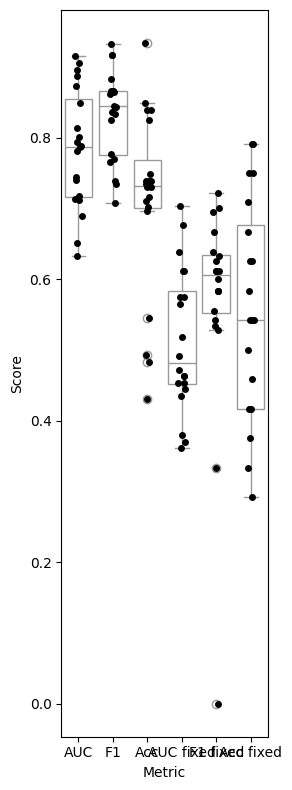

In [160]:
u30_bis_df, u30_bis_p, u30_bis_model = run_kan_predict_both('bis', 'under_30', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 5.28e-01 | test loss: 1.70e+00 | reg: 4.61e+01 : 100%|████| 3/3 [01:12<00:00, 24.13s/it]


0.8729372937293729 0.8490099009900991 0.7109004739336493
0.5111111111111111 0.5714285714285715 0.5833333333333334
1 of 20


train loss: 4.67e-01 | test loss: 1.94e+00 | reg: 4.96e+01 : 100%|████| 3/3 [01:14<00:00, 24.76s/it]


0.8113311331133114 0.8468440594059405 0.7393364928909952
0.3925925925925926 -1.4 0.6666666666666666
2 of 20


train loss: 5.35e-01 | test loss: 1.75e+00 | reg: 4.68e+01 : 100%|████| 3/3 [01:09<00:00, 23.08s/it]


0.7117711771177118 0.8551980198019802 0.8151658767772512
0.45185185185185184 0.4 0.5833333333333334
3 of 20


train loss: 4.31e-01 | test loss: 1.89e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:10<00:00, 23.57s/it]


0.8371837183718372 0.8758840169731259 0.8151658767772512
0.6148148148148148 0.5714285714285715 0.5833333333333334
4 of 20


train loss: 5.31e-01 | test loss: 1.67e+00 | reg: 4.77e+01 : 100%|████| 3/3 [01:09<00:00, 23.24s/it]


0.8701870187018702 0.8917963224893918 0.8388625592417062
0.6814814814814815 0.5499999999999999 0.75
5 of 20


train loss: 4.95e-01 | test loss: 2.08e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:11<00:00, 23.96s/it]


0.7761276127612762 0.8923267326732672 0.8625592417061612
0.5777777777777777 0.30000000000000004 0.7083333333333334
6 of 20


train loss: 5.56e-01 | test loss: 1.75e+00 | reg: 4.66e+01 : 100%|████| 3/3 [01:10<00:00, 23.47s/it]


0.8646864686468647 0.9045261669024045 0.8578199052132701
0.7481481481481481 0.7 0.75
7 of 20


train loss: 4.45e-01 | test loss: 2.02e+00 | reg: 4.90e+01 : 100%|████| 3/3 [01:13<00:00, 24.57s/it]


0.9246424642464246 0.9275990099009901 0.8767772511848341
0.8074074074074075 0.75 0.7916666666666666
8 of 20


train loss: 5.11e-01 | test loss: 1.87e+00 | reg: 4.83e+01 : 100%|████| 3/3 [01:19<00:00, 26.63s/it]


0.7508250825082508 0.8408769448373409 0.7630331753554502
0.3851851851851852 0.4428571428571428 0.4583333333333333
9 of 20


train loss: 4.80e-01 | test loss: 1.81e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:17<00:00, 25.97s/it]


0.8822882288228824 0.9268033946251768 0.8909952606635071
0.6888888888888889 0.7428571428571428 0.75
10 of 20


train loss: 4.97e-01 | test loss: 1.87e+00 | reg: 4.83e+01 : 100%|████| 3/3 [01:09<00:00, 23.23s/it]


0.933993399339934 0.9381188118811882 0.8815165876777251
0.6888888888888889 0.7333333333333333 0.6666666666666666
11 of 20


train loss: 4.75e-01 | test loss: 1.82e+00 | reg: 5.00e+01 : 100%|████| 3/3 [01:10<00:00, 23.40s/it]


0.781078107810781 0.8551980198019802 0.8151658767772512
0.5259259259259259 0.30000000000000004 0.7083333333333334
12 of 20


train loss: 4.61e-01 | test loss: 2.29e+00 | reg: 4.92e+01 : 100%|████| 3/3 [01:08<00:00, 22.68s/it]


0.7315731573157315 0.8122347949080623 0.7203791469194313
0.5407407407407407 0.5714285714285715 0.5833333333333334
13 of 20


train loss: 4.48e-01 | test loss: 1.89e+00 | reg: 4.76e+01 : 100%|████| 3/3 [01:15<00:00, 25.13s/it]


0.852035203520352 0.9077086280056578 0.8625592417061612
0.6148148148148148 0.58 0.7083333333333334
14 of 20


train loss: 6.04e-01 | test loss: 1.54e+00 | reg: 4.66e+01 : 100%|████| 3/3 [01:12<00:00, 24.28s/it]


0.72002200220022 0.707920792079208 0.44075829383886256
0.3925925925925926 0.5666666666666668 0.4583333333333333
15 of 20


train loss: 4.90e-01 | test loss: 1.68e+00 | reg: 4.72e+01 : 100%|████| 3/3 [01:08<00:00, 22.95s/it]


0.7810781078107811 0.8737623762376238 0.8388625592417062
0.6666666666666666 0.6499999999999999 0.7083333333333334
16 of 20


train loss: 4.99e-01 | test loss: 1.78e+00 | reg: 4.70e+01 : 100%|████| 3/3 [01:11<00:00, 23.80s/it]


0.7233223322332233 0.8504243281471005 0.7772511848341233
0.4074074074074074 0.4 0.5833333333333334
17 of 20


train loss: 4.84e-01 | test loss: 1.63e+00 | reg: 4.74e+01 : 100%|████| 3/3 [01:09<00:00, 23.02s/it]


0.7794279427942794 0.8631541725601131 0.7962085308056872
0.6222222222222222 0.58 0.7083333333333334
18 of 20


train loss: 4.31e-01 | test loss: 1.70e+00 | reg: 4.88e+01 : 100%|████| 3/3 [01:17<00:00, 25.73s/it]


0.7145214521452146 0.7029702970297029 0.4312796208530806
0.5629629629629629 0.4 0.6666666666666666
19 of 20


train loss: 4.82e-01 | test loss: 1.85e+00 | reg: 4.75e+01 : 100%|████| 3/3 [01:11<00:00, 23.94s/it]


0.8399339933993399 0.8341584158415841 0.6824644549763034
0.6 0.4 0.75
0.8079482948294832
0.8578257602545971
Statistics=0.0, p=1.9073486328125e-06
Statistics=42.0, p=0.017181396484375


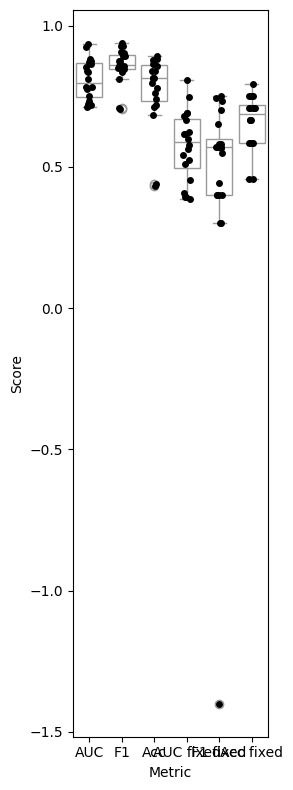

In [163]:
u30_bri_df, u30_bri_p, u30_bri_model = run_kan_predict_both('bri', 'under_30', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 4.98e-01 | test loss: 1.86e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:13<00:00, 24.56s/it]


0.8011083743842365 0.8489326765188834 0.7819905213270142
0.359375 0.1250000000000001 0.7083333333333334
1 of 20


train loss: 6.22e-01 | test loss: 1.62e+00 | reg: 4.65e+01 : 100%|████| 3/3 [01:14<00:00, 24.67s/it]


0.8565270935960592 0.8596059113300493 0.7298578199052133
0.5390625 0.6562499999999999 0.5416666666666666
2 of 20


train loss: 4.88e-01 | test loss: 1.67e+00 | reg: 4.77e+01 : 100%|████| 3/3 [01:07<00:00, 22.54s/it]


0.7647783251231527 0.7963875205254515 0.7061611374407583
0.515625 0.5416666666666666 0.5416666666666666
3 of 20


train loss: 4.48e-01 | test loss: 1.90e+00 | reg: 5.03e+01 : 100%|████| 3/3 [01:17<00:00, 25.90s/it]


0.8454433497536945 0.9113300492610837 0.8720379146919431
0.6484375 0.7083333333333333 0.7083333333333334
4 of 20


train loss: 4.74e-01 | test loss: 1.81e+00 | reg: 5.01e+01 : 100%|████| 3/3 [01:07<00:00, 22.42s/it]


0.8417487684729064 0.8817733990147782 0.8009478672985783
0.5859375 0.2500000000000001 0.75
5 of 20


train loss: 4.54e-01 | test loss: 1.55e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:11<00:00, 23.85s/it]


0.7727832512315271 0.8311048557353976 0.7156398104265402
0.65625 0.6666666666666666 0.6666666666666666
6 of 20


train loss: 3.77e-01 | test loss: 2.10e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:12<00:00, 24.05s/it]


0.7931034482758621 0.8423645320197044 0.7345971563981043
0.4375 0.6249999999999999 0.5
7 of 20


train loss: 4.47e-01 | test loss: 1.99e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:15<00:00, 25.07s/it]


0.7746305418719212 0.7241379310344827 0.46919431279620855
0.5546875 0.4166666666666667 0.7083333333333334
8 of 20


train loss: 4.09e-01 | test loss: 2.10e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:12<00:00, 24.10s/it]


0.6798029556650246 0.721323011963406 0.5308056872037915
0.421875 0.2500000000000001 0.75
9 of 20


train loss: 4.59e-01 | test loss: 1.92e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:09<00:00, 23.30s/it]


0.7943349753694581 0.7586206896551724 0.5355450236966824
0.5234375 0.2500000000000001 0.75
10 of 20


train loss: 4.51e-01 | test loss: 1.79e+00 | reg: 4.88e+01 : 100%|████| 3/3 [01:18<00:00, 26.08s/it]


0.8214285714285714 0.8057705840957071 0.6729857819905213
0.5546875 0.6000000000000001 0.6666666666666666
11 of 20


train loss: 4.50e-01 | test loss: 2.06e+00 | reg: 4.82e+01 : 100%|████| 3/3 [01:16<00:00, 25.65s/it]


0.8232758620689656 0.8620689655172413 0.7677725118483413
0.6171875 0.6428571428571429 0.5833333333333334
12 of 20


train loss: 3.86e-01 | test loss: 2.35e+00 | reg: 5.03e+01 : 100%|████| 3/3 [01:13<00:00, 24.39s/it]


0.7339901477832512 0.7410274454609429 0.5639810426540285
0.3828125 0.5357142857142856 0.4583333333333333
13 of 20


train loss: 4.85e-01 | test loss: 1.82e+00 | reg: 4.82e+01 : 100%|████| 3/3 [01:15<00:00, 25.26s/it]


0.7943349753694581 0.8472906403940886 0.7061611374407583
0.3671875 0.5357142857142856 0.4583333333333333
14 of 20


train loss: 4.72e-01 | test loss: 2.06e+00 | reg: 5.32e+01 : 100%|████| 3/3 [01:10<00:00, 23.44s/it]


0.8004926108374384 0.8251231527093595 0.6635071090047393
0.265625 0.53125 0.375
15 of 20


train loss: 4.33e-01 | test loss: 2.06e+00 | reg: 4.97e+01 : 100%|████| 3/3 [01:07<00:00, 22.64s/it]


0.7863300492610837 0.9146141215106732 0.8767772511848341
0.640625 0.6875000000000001 0.7916666666666666
16 of 20


train loss: 5.10e-01 | test loss: 2.05e+00 | reg: 4.95e+01 : 100%|████| 3/3 [01:09<00:00, 23.01s/it]


0.8201970443349754 0.8916256157635467 0.8436018957345972
0.5390625 0.6249999999999999 0.625
17 of 20


train loss: 4.76e-01 | test loss: 1.65e+00 | reg: 4.72e+01 : 100%|████| 3/3 [01:14<00:00, 24.68s/it]


0.8780788177339901 0.9183673469387754 0.8625592417061612
0.625 0.6785714285714286 0.625
18 of 20


train loss: 5.51e-01 | test loss: 1.63e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:05<00:00, 21.88s/it]


0.8263546798029557 0.8448275862068966 0.7014218009478673
0.515625 0.6249999999999999 0.5
19 of 20


train loss: 4.52e-01 | test loss: 2.08e+00 | reg: 5.00e+01 : 100%|████| 3/3 [01:15<00:00, 25.23s/it]


0.7192118226600985 0.7339901477832511 0.6161137440758294
0.4140625 -0.7499999999999999 0.7083333333333334
0.7963977832512315
0.8280143091719447
Statistics=0.0, p=1.9073486328125e-06
Statistics=91.5, p=0.6476554870605469


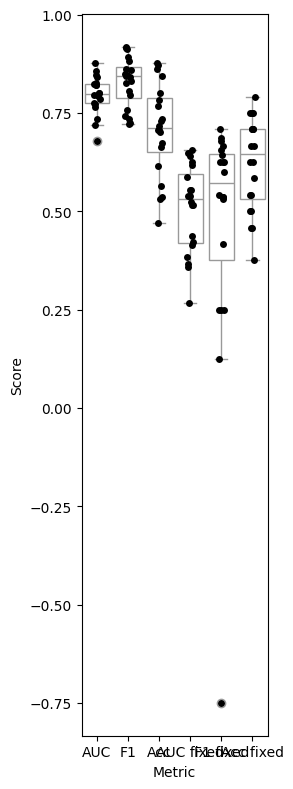

In [164]:
u30_tmi_df, u30_tmi_p, u30_tmi_model = run_kan_predict_both('tmi', 'under_30', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 4.53e-01 | test loss: 1.88e+00 | reg: 4.78e+01 : 100%|████| 3/3 [01:14<00:00, 24.97s/it]


0.7739273927392739 0.8477722772277227 0.8056872037914692
0.562962962962963 0.6666666666666667 0.5833333333333334
1 of 20


train loss: 4.80e-01 | test loss: 1.71e+00 | reg: 4.78e+01 : 100%|████| 3/3 [01:16<00:00, 25.49s/it]


0.768976897689769 0.8050742574257426 0.6682464454976303
0.43703703703703706 0.5499999999999999 0.5
2 of 20


train loss: 4.68e-01 | test loss: 1.80e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:12<00:00, 24.32s/it]


0.8393839383938394 0.8267326732673268 0.6682464454976303
0.6370370370370371 0.6142857142857143 0.625
3 of 20


train loss: 4.32e-01 | test loss: 1.80e+00 | reg: 4.77e+01 : 100%|████| 3/3 [01:14<00:00, 24.73s/it]


0.753025302530253 0.7644978783592645 0.6492890995260664
0.5259259259259259 0.5285714285714287 0.5416666666666666
4 of 20


train loss: 5.07e-01 | test loss: 1.74e+00 | reg: 4.61e+01 : 100%|████| 3/3 [01:15<00:00, 25.22s/it]


0.8162816281628162 0.9395332390381895 0.909952606635071
0.7111111111111111 0.7 0.75
5 of 20


train loss: 4.72e-01 | test loss: 1.88e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:18<00:00, 26.11s/it]


0.7348734873487349 0.844059405940594 0.8341232227488151
0.6 0.6 0.6666666666666666
6 of 20


train loss: 4.99e-01 | test loss: 1.67e+00 | reg: 4.88e+01 : 100%|████| 3/3 [01:24<00:00, 28.02s/it]


0.7414741474147415 0.7521658415841584 0.5781990521327014
0.6222222222222222 0.625 0.5833333333333334
7 of 20


train loss: 4.19e-01 | test loss: 2.37e+00 | reg: 4.95e+01 : 100%|████| 3/3 [01:15<00:00, 25.02s/it]


0.7106710671067107 0.7215346534653465 0.5260663507109005
0.4666666666666667 0.6333333333333334 0.5416666666666666
8 of 20


train loss: 4.51e-01 | test loss: 1.81e+00 | reg: 4.84e+01 : 100%|████| 3/3 [01:15<00:00, 25.14s/it]


0.7667766776677667 0.8058698727015559 0.7109004739336493
0.45185185185185184 0.48571428571428565 0.5
9 of 20


train loss: 5.19e-01 | test loss: 1.60e+00 | reg: 4.70e+01 : 100%|████| 3/3 [01:20<00:00, 26.82s/it]


0.8597359735973598 0.9045261669024045 0.8578199052132701
0.6370370370370371 0.6625 0.625
10 of 20


train loss: 5.21e-01 | test loss: 1.54e+00 | reg: 4.65e+01 : 100%|████| 3/3 [01:13<00:00, 24.48s/it]


0.8443344334433442 0.9172560113154173 0.8767772511848341
0.6444444444444444 0.6571428571428571 0.6666666666666666
11 of 20


train loss: 5.00e-01 | test loss: 1.55e+00 | reg: 4.66e+01 : 100%|████| 3/3 [01:18<00:00, 26.23s/it]


0.8085808580858085 0.8727015558698726 0.8104265402843602
0.5111111111111111 0.49999999999999994 0.5833333333333334
12 of 20


train loss: 4.69e-01 | test loss: 1.74e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:12<00:00, 24.18s/it]


0.8355335533553356 0.7945544554455446 0.6066350710900474
0.5407407407407407 0.6 0.5
13 of 20


train loss: 5.54e-01 | test loss: 1.60e+00 | reg: 4.66e+01 : 100%|████| 3/3 [01:19<00:00, 26.38s/it]


0.8652365236523653 0.9443069306930693 0.9052132701421801
0.6666666666666667 0.775 0.75
14 of 20


train loss: 5.24e-01 | test loss: 1.43e+00 | reg: 4.76e+01 : 100%|████| 3/3 [01:17<00:00, 25.72s/it]


0.9075907590759076 0.8787128712871287 0.7677725118483413
0.6518518518518518 0.6571428571428571 0.6666666666666666
15 of 20


train loss: 4.45e-01 | test loss: 1.86e+00 | reg: 4.97e+01 : 100%|████| 3/3 [01:11<00:00, 23.70s/it]


0.8514851485148515 0.9045261669024045 0.8578199052132701
0.6296296296296295 0.64 0.75
16 of 20


train loss: 5.83e-01 | test loss: 1.63e+00 | reg: 4.80e+01 : 100%|████| 3/3 [01:11<00:00, 23.97s/it]


0.8322332233223322 0.9045261669024045 0.8578199052132701
0.6962962962962963 0.64 0.75
17 of 20


train loss: 4.29e-01 | test loss: 1.71e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:13<00:00, 24.36s/it]


0.9235423542354235 0.9232673267326732 0.8530805687203792
0.7407407407407407 0.8 0.75
18 of 20


train loss: 5.16e-01 | test loss: 1.54e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:13<00:00, 24.54s/it]


0.8729372937293729 0.8267326732673268 0.6682464454976303
0.7111111111111111 0.6499999999999999 0.7083333333333334
19 of 20


train loss: 3.94e-01 | test loss: 1.90e+00 | reg: 4.85e+01 : 100%|████| 3/3 [01:15<00:00, 25.01s/it]


0.8833883388338835 0.9427157001414428 0.9146919431279621
0.5925925925925926 0.7 0.6666666666666666
0.8194994499449946
0.8560533062234793
Statistics=0.0, p=1.9073486328125e-06
Statistics=14.0, p=0.000209808349609375


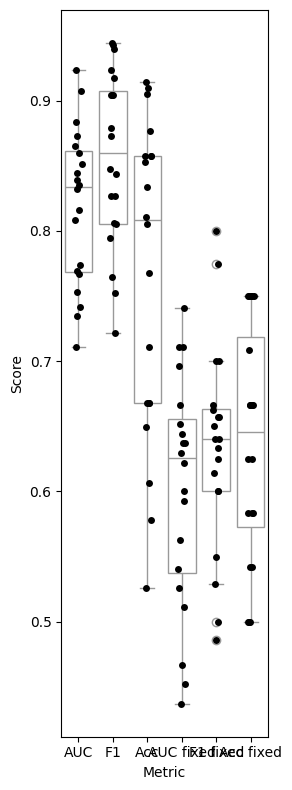

In [159]:
u30_aes_df, u30_aes_p, u30_aes_model = run_kan_predict_both('aes', 'under_30', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 4.95e-01 | test loss: 1.65e+00 | reg: 4.69e+01 : 100%|████| 3/3 [01:14<00:00, 24.73s/it]


0.7980099502487562 0.878731343283582 0.8151658767772512
0.5071428571428571 0.5535714285714286 0.5833333333333334
1 of 20


train loss: 4.97e-01 | test loss: 1.53e+00 | reg: 4.78e+01 : 100%|████| 3/3 [01:13<00:00, 24.56s/it]


0.9039800995024876 0.8922056384742953 0.8151658767772512
0.65 0.5714285714285715 0.75
2 of 20


train loss: 4.78e-01 | test loss: 1.71e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:10<00:00, 23.52s/it]


0.8721393034825872 0.9284825870646767 0.8909952606635071
0.6857142857142857 0.6875 0.7083333333333334
3 of 20


train loss: 4.88e-01 | test loss: 1.59e+00 | reg: 4.64e+01 : 100%|████| 3/3 [01:10<00:00, 23.56s/it]


0.826865671641791 0.9431414356787492 0.9241706161137441
0.6428571428571428 0.6428571428571428 0.7083333333333334
4 of 20


train loss: 4.32e-01 | test loss: 2.20e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:10<00:00, 23.38s/it]


0.7248756218905472 0.7867803837953092 0.7156398104265402
0.4 0.6071428571428571 0.5416666666666666
5 of 20


train loss: 4.57e-01 | test loss: 1.62e+00 | reg: 4.72e+01 : 100%|████| 3/3 [01:09<00:00, 23.08s/it]


0.8258706467661692 0.9253731343283583 0.9004739336492891
0.6285714285714286 0.5918367346938775 0.6666666666666666
6 of 20


train loss: 4.70e-01 | test loss: 1.84e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:10<00:00, 23.62s/it]


0.8333333333333334 0.9543946932006634 0.9478672985781991
0.6285714285714286 0.5833333333333333 0.7083333333333334
7 of 20


train loss: 4.46e-01 | test loss: 1.66e+00 | reg: 4.63e+01 : 100%|████| 3/3 [01:12<00:00, 24.29s/it]


0.818407960199005 0.7810945273631842 0.5829383886255924
0.7142857142857142 0.5714285714285715 0.75
8 of 20


train loss: 4.20e-01 | test loss: 1.93e+00 | reg: 4.90e+01 : 100%|████| 3/3 [01:10<00:00, 23.63s/it]


0.8577114427860697 0.9060254284134882 0.8388625592417062
0.40714285714285714 0.6031746031746033 0.5833333333333334
9 of 20


train loss: 4.76e-01 | test loss: 1.70e+00 | reg: 4.83e+01 : 100%|████| 3/3 [01:09<00:00, 23.22s/it]


0.8318407960199005 0.8065229408512992 0.6682464454976303
0.5357142857142857 -0.4285714285714288 0.6666666666666666
10 of 20


train loss: 4.48e-01 | test loss: 1.69e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:11<00:00, 23.75s/it]


0.9298507462686567 0.9054726368159205 0.8199052132701422
0.5714285714285714 0.5982142857142858 0.625
11 of 20


train loss: 4.19e-01 | test loss: 2.09e+00 | reg: 4.88e+01 : 100%|████| 3/3 [01:11<00:00, 23.73s/it]


0.7562189054726368 0.8152096659559347 0.7535545023696683
0.46428571428571436 0.5714285714285715 0.5
12 of 20


train loss: 4.76e-01 | test loss: 1.73e+00 | reg: 4.53e+01 : 100%|████| 3/3 [01:14<00:00, 24.91s/it]


0.8885572139303483 0.9502487562189056 0.9241706161137441
0.8571428571428571 0.8660714285714286 0.875
13 of 20


train loss: 4.36e-01 | test loss: 1.87e+00 | reg: 4.69e+01 : 100%|████| 3/3 [01:13<00:00, 24.60s/it]


0.8298507462686567 0.8862828713574983 0.8483412322274881
0.7642857142857142 0.75 0.7083333333333334
14 of 20


train loss: 4.50e-01 | test loss: 1.67e+00 | reg: 4.64e+01 : 100%|████| 3/3 [01:16<00:00, 25.34s/it]


0.8800995024875622 0.8805970149253732 0.7725118483412322
0.6928571428571428 0.7857142857142858 0.75
15 of 20


train loss: 4.47e-01 | test loss: 1.93e+00 | reg: 4.78e+01 : 100%|████| 3/3 [01:14<00:00, 24.84s/it]


0.8218905472636816 0.8231066887783307 0.6966824644549763
0.4714285714285714 0.6428571428571428 0.5833333333333334
16 of 20


train loss: 5.16e-01 | test loss: 1.57e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:13<00:00, 24.43s/it]


0.8597014925373134 0.8034825870646767 0.6255924170616114
0.5357142857142857 0.48979591836734704 0.5833333333333334
17 of 20


train loss: 4.57e-01 | test loss: 1.87e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:14<00:00, 24.76s/it]


0.7830845771144278 0.9004975124378111 0.8672985781990521
0.6857142857142857 0.7023809523809524 0.7916666666666666
18 of 20


train loss: 3.75e-01 | test loss: 1.81e+00 | reg: 4.85e+01 : 100%|████| 3/3 [01:12<00:00, 24.10s/it]


0.8522388059701493 0.8818407960199006 0.8199052132701422
0.5357142857142858 0.6428571428571428 0.5833333333333334
19 of 20


train loss: 4.84e-01 | test loss: 1.66e+00 | reg: 4.69e+01 : 100%|████| 3/3 [01:16<00:00, 25.56s/it]


0.8144278606965174 0.8725124378109453 0.8056872037914692
0.5571428571428572 0.5535714285714286 0.5833333333333334
0.8354477611940299
0.8761001539919452
Statistics=0.0, p=1.9073486328125e-06
Statistics=24.0, p=0.0014324188232421875


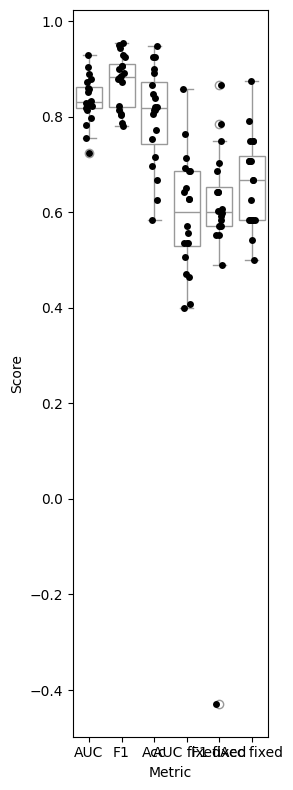

In [165]:
u30_gds_df, u30_gds_p, u30_gds_model = run_kan_predict_both('gds', 'under_30', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 2.83e-01 | test loss: 2.19e+00 | reg: 5.46e+01 : 100%|████| 3/3 [01:09<00:00, 23.22s/it]


0.9108843537414966 0.8724489795918368 0.7630331753554502
0.6733333333333333 0.596153846153846 0.72
1 of 20


train loss: 2.43e-01 | test loss: 2.45e+00 | reg: 5.48e+01 : 100%|████| 3/3 [01:14<00:00, 24.84s/it]


0.8690476190476191 0.9269480519480519 0.9004739336492891
0.6799999999999999 0.5909090909090909 0.76
2 of 20


train loss: 2.36e-01 | test loss: 1.70e+00 | reg: 5.24e+01 : 100%|████| 3/3 [01:13<00:00, 24.59s/it]


0.9380952380952381 0.9107142857142856 0.8341232227488151
0.56 0.596153846153846 0.72
3 of 20


train loss: 2.59e-01 | test loss: 1.70e+00 | reg: 5.13e+01 : 100%|████| 3/3 [01:20<00:00, 26.71s/it]


0.9282312925170069 0.9043367346938774 0.8341232227488151
0.7666666666666666 0.4166666666666667 0.72
4 of 20


train loss: 2.52e-01 | test loss: 2.38e+00 | reg: 5.11e+01 : 100%|████| 3/3 [01:16<00:00, 25.59s/it]


0.8122448979591838 0.8608534322820036 0.8104265402843602
0.7066666666666667 0.24999999999999994 0.68
5 of 20


train loss: 1.93e-01 | test loss: 2.06e+00 | reg: 5.05e+01 : 100%|████| 3/3 [01:09<00:00, 23.32s/it]


0.9081632653061225 0.9298469387755102 0.8957345971563981
0.8066666666666666 0.659090909090909 0.8
6 of 20


train loss: 2.27e-01 | test loss: 2.26e+00 | reg: 5.17e+01 : 100%|████| 3/3 [01:16<00:00, 25.51s/it]


0.8605442176870749 0.8112244897959183 0.6492890995260664
0.62 0.035714285714285955 0.64
7 of 20


train loss: 2.38e-01 | test loss: 1.97e+00 | reg: 5.19e+01 : 100%|████| 3/3 [01:19<00:00, 26.52s/it]


0.9255102040816326 0.9316690962099125 0.8815165876777251
0.7866666666666666 0.7857142857142857 0.84
8 of 20


train loss: 3.28e-01 | test loss: 2.12e+00 | reg: 5.64e+01 : 100%|████| 3/3 [01:16<00:00, 25.55s/it]


0.8297619047619048 0.8528257456828884 0.7630331753554502
0.4933333333333334 0.4807692307692309 0.64
9 of 20


train loss: 2.23e-01 | test loss: 1.80e+00 | reg: 4.99e+01 : 100%|████| 3/3 [01:15<00:00, 25.28s/it]


0.8775510204081632 0.8443877551020407 0.7109004739336493
0.6066666666666667 -1.0625 0.56
10 of 20


train loss: 2.10e-01 | test loss: 2.19e+00 | reg: 5.13e+01 : 100%|████| 3/3 [01:10<00:00, 23.36s/it]


0.858843537414966 0.8606049562682214 0.7582938388625592
0.44 -3.875 0.48
11 of 20


train loss: 2.32e-01 | test loss: 1.84e+00 | reg: 5.05e+01 : 100%|████| 3/3 [01:14<00:00, 24.93s/it]


0.9034013605442177 0.879737609329446 0.7914691943127962
0.5933333333333333 0.3333333333333333 0.68
12 of 20


train loss: 1.79e-01 | test loss: 2.17e+00 | reg: 5.26e+01 : 100%|████| 3/3 [01:11<00:00, 23.80s/it]


0.8664965986394558 0.8947704081632653 0.8436018957345972
0.6333333333333333 0.4000000000000001 0.68
13 of 20


train loss: 2.86e-01 | test loss: 1.95e+00 | reg: 5.13e+01 : 100%|████| 3/3 [01:10<00:00, 23.38s/it]


0.8253401360544217 0.8822605965463107 0.8104265402843602
0.55 0.596153846153846 0.72
14 of 20


train loss: 2.12e-01 | test loss: 2.03e+00 | reg: 5.15e+01 : 100%|████| 3/3 [01:17<00:00, 25.81s/it]


0.9037414965986393 0.8877551020408162 0.7914691943127962
0.74 0.14285714285714288 0.68
15 of 20


train loss: 2.05e-01 | test loss: 1.90e+00 | reg: 5.09e+01 : 100%|████| 3/3 [01:12<00:00, 24.12s/it]


0.8948979591836734 0.8392857142857143 0.7014218009478673
0.6266666666666667 0.4000000000000001 0.68
16 of 20


train loss: 2.96e-01 | test loss: 1.76e+00 | reg: 5.68e+01 : 100%|████| 3/3 [01:16<00:00, 25.64s/it]


0.9292517006802721 0.879737609329446 0.7914691943127962
0.8066666666666666 0.5500000000000002 0.76
17 of 20


train loss: 1.63e-01 | test loss: 2.65e+00 | reg: 5.55e+01 : 100%|████| 3/3 [01:14<00:00, 24.69s/it]


0.8238095238095238 0.7755102040816325 0.5829383886255924
0.6266666666666667 0.5384615384615383 0.68
18 of 20


train loss: 2.21e-01 | test loss: 2.12e+00 | reg: 5.57e+01 : 100%|████| 3/3 [01:16<00:00, 25.57s/it]


0.8241496598639456 0.8175039246467818 0.7061611374407583
0.62 0.5 0.68
19 of 20


train loss: 2.92e-01 | test loss: 2.05e+00 | reg: 5.09e+01 : 100%|████| 3/3 [01:17<00:00, 25.76s/it]


0.8965986394557823 0.8775510204081631 0.7725118483412322
0.5666666666666667 0.4375000000000001 0.64
0.879328231292517
0.871998632744806
Statistics=0.0, p=1.9073486328125e-06
Statistics=4.0, p=1.33514404296875e-05


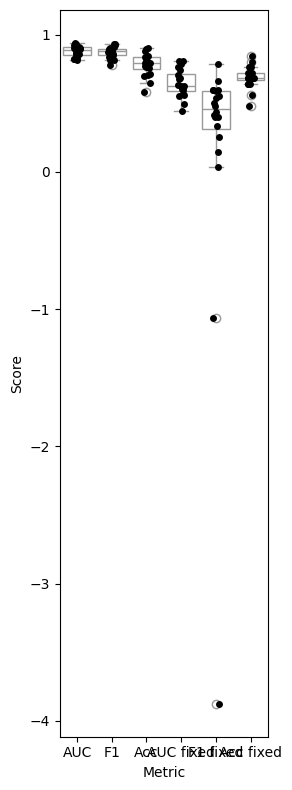

In [166]:
u30_suicide_df, u30_suicide_p, u30_suicide_model = run_kan_predict_both('suicide', 'under_30', width=[100, 16, 4], steps=3, max_k=20)

In [56]:
out_string = 'out_data = {'
for test in ['', 'bis', 'bri', 'tmi', 'gds', 'aes', 'suicide']: 
    string = f'\'{test}\':{{\'df\': u30_{test}_df.to_numpy(), \'p\': u30_{test}_p, \'model\': u30_{test}_model.cpu().state_dict()}},' 
    if test == '': 
        string = string.replace('u30__', 'u30_')
        string = string.replace('\'\':', '\'cte\':')
    out_string += '\n' + '    ' + string 
out_string += '\n}'
print(out_string)

out_data = {
    'cte':{'df': u30_df.to_numpy(), 'p': u30_p, 'model': u30_model.cpu().state_dict()},
    'bis':{'df': u30_bis_df.to_numpy(), 'p': u30_bis_p, 'model': u30_bis_model.cpu().state_dict()},
    'bri':{'df': u30_bri_df.to_numpy(), 'p': u30_bri_p, 'model': u30_bri_model.cpu().state_dict()},
    'tmi':{'df': u30_tmi_df.to_numpy(), 'p': u30_tmi_p, 'model': u30_tmi_model.cpu().state_dict()},
    'gds':{'df': u30_gds_df.to_numpy(), 'p': u30_gds_p, 'model': u30_gds_model.cpu().state_dict()},
    'aes':{'df': u30_aes_df.to_numpy(), 'p': u30_aes_p, 'model': u30_aes_model.cpu().state_dict()},
    'suicide':{'df': u30_suicide_df.to_numpy(), 'p': u30_suicide_p, 'model': u30_suicide_model.cpu().state_dict()},
}


In [171]:
out_data = {
    'cte':{'df': u30_df.to_numpy(), 'p': u30_p, 'model': u30_model.cpu().state_dict()},
    'bis':{'df': u30_bis_df.to_numpy(), 'p': u30_bis_p, 'model': u30_bis_model.cpu().state_dict()},
    'bri':{'df': u30_bri_df.to_numpy(), 'p': u30_bri_p, 'model': u30_bri_model.cpu().state_dict()},
    'tmi':{'df': u30_tmi_df.to_numpy(), 'p': u30_tmi_p, 'model': u30_tmi_model.cpu().state_dict()},
    'gds':{'df': u30_gds_df.to_numpy(), 'p': u30_gds_p, 'model': u30_gds_model.cpu().state_dict()},
    'aes':{'df': u30_aes_df.to_numpy(), 'p': u30_aes_p, 'model': u30_aes_model.cpu().state_dict()},
    'suicide':{'df': u30_suicide_df.to_numpy(), 'p': u30_suicide_p, 'model': u30_suicide_model.cpu().state_dict()},
}

# m = KAN(width=[100, 16, 4])
# m.load_state_dict(u30_model.state_dict())

joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_fixed.pkl')

['/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_fixed.pkl']

In [70]:
for test in ['', 'bis', 'bri', 'tmi', 'gds', 'aes', 'suicide']: 
    string = f'u30_{test}_model.save_ckpt(\'u30_{test}_model\')' 
    if test == '': 
        string = string.replace('u30__', 'u30_')
        string = string.replace('\'u30_model', '\'u30_cte_model')
    print(string)

u30_model.save_ckpt('u30_cte_model')
u30_bis_model.save_ckpt('u30_bis_model')
u30_bri_model.save_ckpt('u30_bri_model')
u30_tmi_model.save_ckpt('u30_tmi_model')
u30_gds_model.save_ckpt('u30_gds_model')
u30_aes_model.save_ckpt('u30_aes_model')
u30_suicide_model.save_ckpt('u30_suicide_model')


In [172]:
u30_model.save_ckpt('u30_cte_model_fixed')
u30_bis_model.save_ckpt('u30_bis_model_fixed')
u30_bri_model.save_ckpt('u30_bri_model_fixed')
u30_tmi_model.save_ckpt('u30_tmi_model_fixed')
u30_gds_model.save_ckpt('u30_gds_model_fixed')
u30_aes_model.save_ckpt('u30_aes_model_fixed')
u30_suicide_model.save_ckpt('u30_suicide_model_fixed')

save this model to ./model_ckpt/u30_cte_model_fixed
save this model to ./model_ckpt/u30_bis_model_fixed
save this model to ./model_ckpt/u30_bri_model_fixed
save this model to ./model_ckpt/u30_tmi_model_fixed
save this model to ./model_ckpt/u30_gds_model_fixed
save this model to ./model_ckpt/u30_aes_model_fixed
save this model to ./model_ckpt/u30_suicide_model_fixed


In [76]:
u30_model.to('cuda')
u30_model.prune()

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=16, out_features=1, bias=False)
    (1): Linear(in_features=4, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

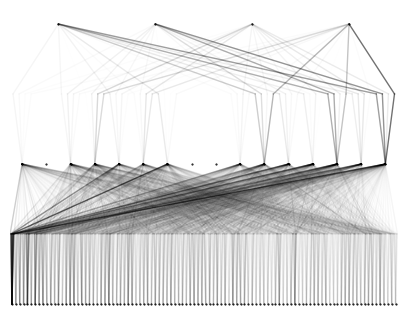

In [77]:
u30_model.plot(mask=True)

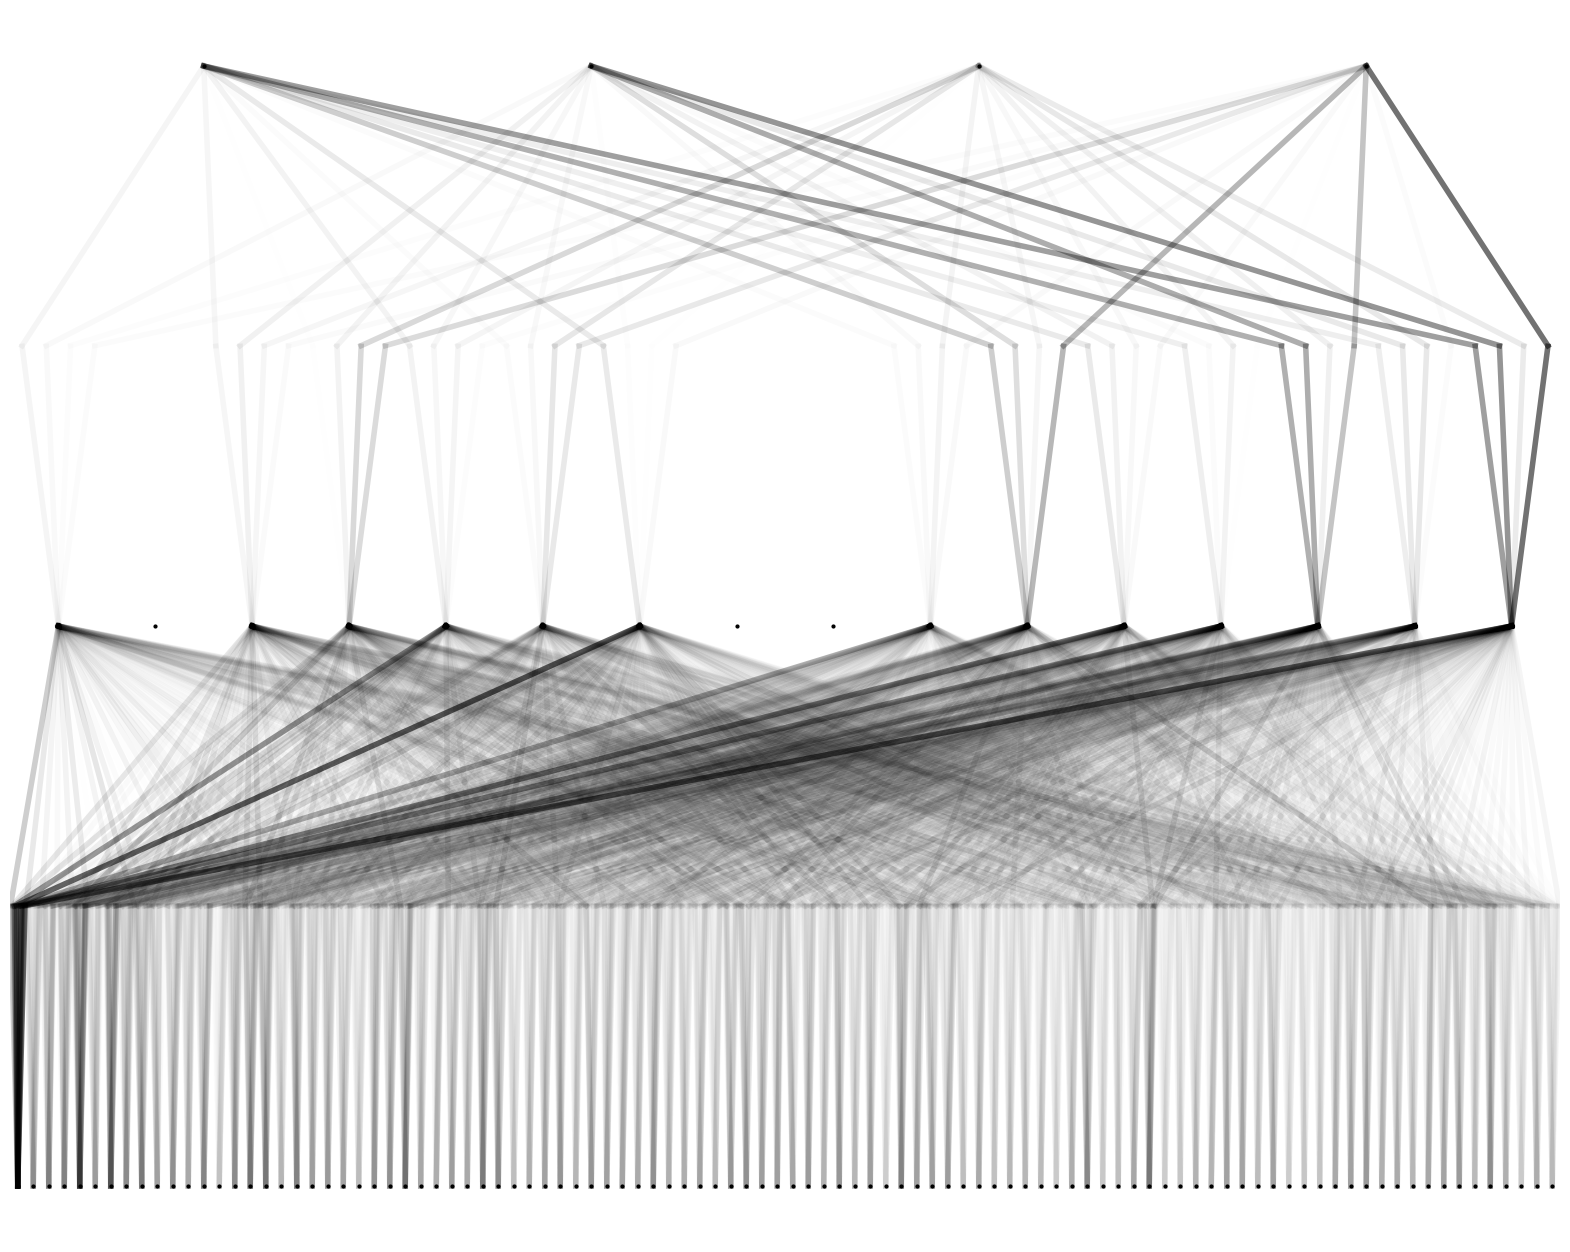

In [78]:
u30_model.plot(mask=True, scale=2.0)

In [91]:


def run_mlp_predict_both(c1, c2, width=[100, 4], clusters=[0, 1, 2, 3, 4], max_k=20): 
    #trying with only certain clusters 
    cluster_to_try = clusters
    indices = np.concatenate([range((c+1)*384*2, (c+2)*384*2) for c in cluster_to_try])
    sub_decomposition = decompositions[:, indices]

    sub_rhi = rhi[['Slide_ID', c1, c2]].dropna()
    slide_label_map = slide_to_label(sub_rhi, c1)
    ls1 = np.array([slide_label_map[s] for s in slide_ids if s in slide_label_map])
    
    slide_label_map = slide_to_label(sub_rhi, c2)
    ls2 = np.array([slide_label_map[s] for s in slide_ids if s in slide_label_map])
    
    ls = 2*ls2 + ls1 # ls1 can be reobtained by modulo 2 

    inner_slides = np.array([i for i, s in enumerate(slide_ids) if s in slide_label_map])
    sub_decompositions = sub_decomposition[inner_slides,:]

    out_df = []
    best_model = None
    best_auc = 0 
    pca = PCA(n_components=width[0])
    sub_decompositions = pca.fit_transform(sub_decompositions)
    previous_ls = None 
    states = np.random.randint(low=0, high=1000000, size=max_k)
    for k in tqdm(range(0, max_k)): 
#         print(k, 'of', max_k)
        X_train, X_test, y_train, y_test = train_test_split(sub_decompositions, range(len(ls)), test_size=0.3, 
                                                            stratify=ls, random_state=states[k])
        
        assert not np.array_equal(previous_ls, ls[y_test])
        previous_ls = ls[y_test]
        
        model = MLPClassifier(hidden_layer_sizes=tuple(width[1:]), learning_rate_init=0.01, solver='adam', batch_size=32)
        model.fit(X_train, ls[y_train])
        
        probs = model.predict_proba(X_test)
        preds = np.argmax(probs, axis=1)
        probs = probs[:, 3] # probability of ls2 & ls1 is always 3, assume the positive label is both positive 

        # fix labels 2 for analysis of label 1 within fixed 2: 
        indices = np.where(ls2[y_test] == 1)[0]
        labels_to_3 = (ls[y_test]==3).astype(int)
        auc_low, f1_low, acc_low = get_stats(labels_to_3[indices], probs[indices])
        auc, f1, acc = get_stats(labels_to_3, probs)
        
#         print(auc, f1, acc)
#         print(auc_low, f1_low, acc_low)

        if auc > best_auc: 
            best_auc = auc 
            best_model = model 
        out_df.append(
            {
                'k': k, 
                'AUC fixed': auc_low, 
                'F1 fixed': f1_low, 
                'Acc fixed': acc_low, 
                'AUC': auc, 
                'F1': f1, 
                'Acc': acc 
            }
        )
        
    out_df = pd.DataFrame(out_df)
    print(np.mean(out_df['AUC']))
    print(np.mean(out_df['F1']))
    print(np.mean(out_df['AUC fixed']))
    print(np.mean(out_df['F1 fixed']))
    stat, p_value = wilcoxon(out_df['AUC'] - 0.5)
    print(f'Statistics={stat}, p={p_value}')
    stat, p_value = wilcoxon(out_df['AUC fixed'] - 0.5)
    print(f'Statistics={stat}, p={p_value}')

    melted_df = pd.melt(out_df, id_vars=['k'], value_vars=['AUC', 'F1', 'Acc', 'AUC fixed', 'F1 fixed', 'Acc fixed'], var_name='Metric', value_name='Score')

    fig, ax = plt.subplots(1, 1, figsize=(3, 8))
    sns.boxplot(data=melted_df, x='Metric', y='Score', color='white')
    sns.stripplot(melted_df, y='Score', x='Metric', color='black')
    plt.tight_layout()
    plt.show()
    return out_df, p_value, best_model 

In [96]:
stat, p_value = wilcoxon(u30_df['AUC fixed'] - 0.5)
print(p_value)
print(np.mean(u30_df['AUC fixed']))

0.001174975839731714
0.5618589743589743


In [97]:
for test in ['cte', 'bri', 'tmi', 'aes', 'gds', 'bis', 'suicide']: print(f"""u30_{test}_mlp_df, u30_{test}_mlp_p, u30_{test}_mlp_model = run_mlp_predict_both('{test}', 'under_30', width=[100, 16, 4], max_k=20)""")

u30_cte_mlp_df, u30_cte_mlp_p, u30_cte_mlp_model = run_mlp_predict_both('cte', 'under_30', width=[100, 16, 4], max_k=20)
u30_bri_mlp_df, u30_bri_mlp_p, u30_bri_mlp_model = run_mlp_predict_both('bri', 'under_30', width=[100, 16, 4], max_k=20)
u30_tmi_mlp_df, u30_tmi_mlp_p, u30_tmi_mlp_model = run_mlp_predict_both('tmi', 'under_30', width=[100, 16, 4], max_k=20)
u30_aes_mlp_df, u30_aes_mlp_p, u30_aes_mlp_model = run_mlp_predict_both('aes', 'under_30', width=[100, 16, 4], max_k=20)
u30_gds_mlp_df, u30_gds_mlp_p, u30_gds_mlp_model = run_mlp_predict_both('gds', 'under_30', width=[100, 16, 4], max_k=20)
u30_bis_mlp_df, u30_bis_mlp_p, u30_bis_mlp_model = run_mlp_predict_both('bis', 'under_30', width=[100, 16, 4], max_k=20)
u30_suicide_mlp_df, u30_suicide_mlp_p, u30_suicide_mlp_model = run_mlp_predict_both('suicide', 'under_30', width=[100, 16, 4], max_k=20)


 50%|███████████████████████████████████▌                                   | 10/20 [00:04<00:04,  2.10it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
 75%|█████████████████████████████████████████████████████▎                 | 15/20 [00:07<00:02,  2.02it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
 90%|███████████████████████████████████████████████████████████████▉       | 18/20 [00:09<00:01,  1.74it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03it/s]


0.6914782244556115
-inf
0.4453525641025641
-inf
Statistics=3.0, p=9.5367431640625e-06
Statistics=47.0, p=0.029575347900390625


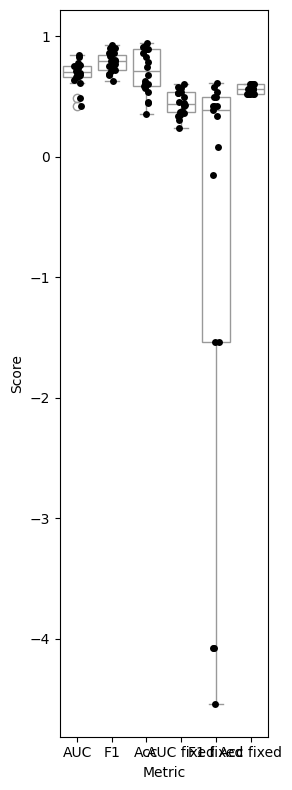

In [151]:
u30_cte_mlp_df, u30_cte_mlp_p, u30_cte_mlp_model = run_mlp_predict_both('cte', 'under_30', width=[100, 16, 4], max_k=20)

 65%|██████████████████████████████████████████████▏                        | 13/20 [00:04<00:02,  2.88it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
 90%|███████████████████████████████████████████████████████████████▉       | 18/20 [00:06<00:00,  2.77it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.50it/s]


0.7286991199119912
0.770263879066478
0.5422222222222223
-inf
Statistics=5.0, p=1.9073486328125e-05
Statistics=66.5, p=0.25132607058989065


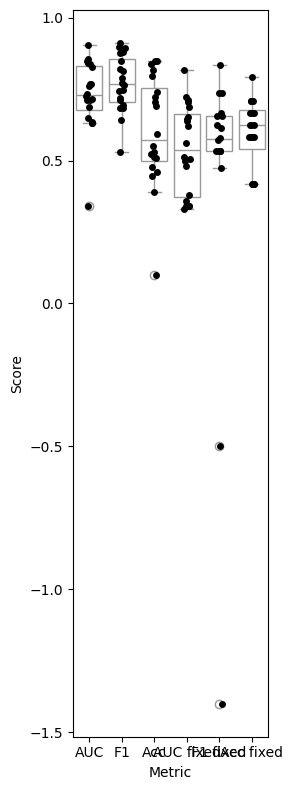

In [152]:
u30_bri_mlp_df, u30_bri_mlp_p, u30_bri_mlp_model = run_mlp_predict_both('bri', 'under_30', width=[100, 16, 4], max_k=20)

 20%|██████████████▍                                                         | 4/20 [00:01<00:05,  2.88it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
 25%|██████████████████                                                      | 5/20 [00:01<00:05,  2.89it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
 55%|███████████████████████████████████████                                | 11/20 [00:04<00:03,  2.39it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.27it/s]


0.699060960591133
0.7399296270232231
0.47265625
-inf
Statistics=0.0, p=1.9073486328125e-06
Statistics=62.0, p=0.11398696899414062


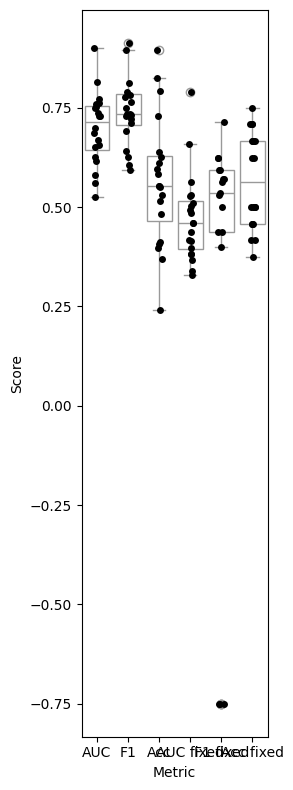

In [153]:
u30_tmi_mlp_df, u30_tmi_mlp_p, u30_tmi_mlp_model = run_mlp_predict_both('tmi', 'under_30', width=[100, 16, 4], max_k=20)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47it/s]


0.7604647964796479
0.8179747171145687
0.5596296296296296
0.4444583333333333
Statistics=1.0, p=3.814697265625e-06
Statistics=42.0, p=0.017181396484375


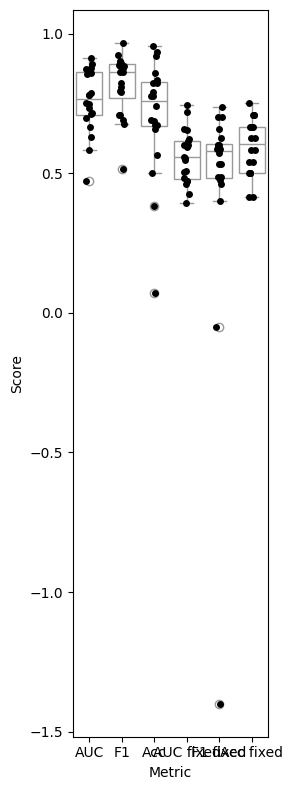

In [154]:
u30_aes_mlp_df, u30_aes_mlp_p, u30_aes_mlp_model = run_mlp_predict_both('aes', 'under_30', width=[100, 16, 4], max_k=20)

 45%|████████████████████████████████▍                                       | 9/20 [00:04<00:05,  2.12it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


0.7700373134328359
0.8216106965174129
0.5644642857142858
-inf
Statistics=0.0, p=1.9073486328125e-06
Statistics=39.5, p=0.02549009172695288


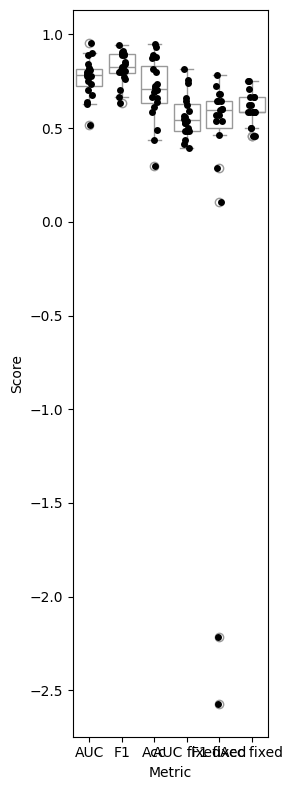

In [155]:
u30_gds_mlp_df, u30_gds_mlp_p, u30_gds_mlp_model = run_mlp_predict_both('gds', 'under_30', width=[100, 16, 4], max_k=20)

 80%|████████████████████████████████████████████████████████▊              | 16/20 [00:06<00:01,  2.93it/s]/tmp/ipykernel_16509/907976692.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.60it/s]


0.8156504065040651
0.8649999999999999
0.575925925925926
-inf
Statistics=0.0, p=1.9073486328125e-06
Statistics=37.5, p=0.02064611952459729


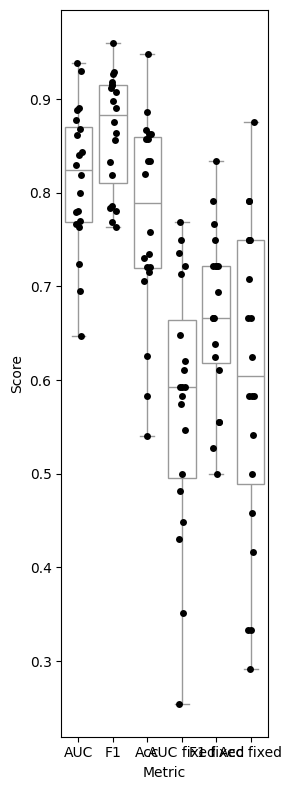

In [156]:
u30_bis_mlp_df, u30_bis_mlp_p, u30_bis_mlp_model = run_mlp_predict_both('bis', 'under_30', width=[100, 16, 4], max_k=20)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


0.8891071428571428
0.8941207389549225
0.657
0.36230769230769233
Statistics=0.0, p=1.9073486328125e-06
Statistics=7.0, p=3.62396240234375e-05


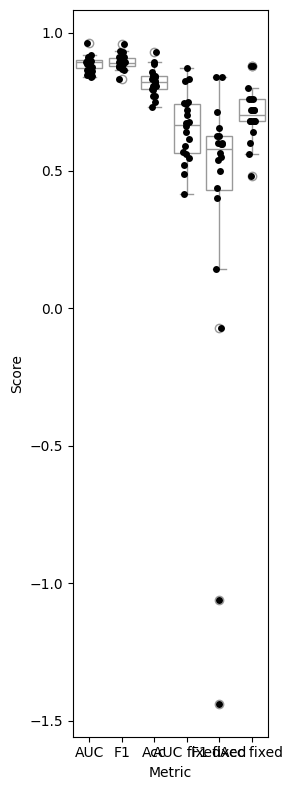

In [157]:
u30_suicide_mlp_df, u30_suicide_mlp_p, u30_suicide_mlp_model = run_mlp_predict_both('suicide', 'under_30', width=[100, 16, 4], max_k=20)

In [106]:
out_string = 'out_data = {'
for test in ['cte', 'bis', 'bri', 'tmi', 'gds', 'aes', 'suicide']: 
    string = f'\'{test}\':{{\'df\': u30_{test}_mlp_df.to_numpy(), \'p\': u30_{test}_mlp_p, \'model\': u30_{test}_mlp_model}},' 
    out_string += '\n' + '    ' + string 
out_string += '\n}'
print(out_string)

out_data = {
    'cte':{'df': u30_cte_mlp_df.to_numpy(), 'p': u30_cte_mlp_p, 'model': u30_cte_mlp_model},
    'bis':{'df': u30_bis_mlp_df.to_numpy(), 'p': u30_bis_mlp_p, 'model': u30_bis_mlp_model},
    'bri':{'df': u30_bri_mlp_df.to_numpy(), 'p': u30_bri_mlp_p, 'model': u30_bri_mlp_model},
    'tmi':{'df': u30_tmi_mlp_df.to_numpy(), 'p': u30_tmi_mlp_p, 'model': u30_tmi_mlp_model},
    'gds':{'df': u30_gds_mlp_df.to_numpy(), 'p': u30_gds_mlp_p, 'model': u30_gds_mlp_model},
    'aes':{'df': u30_aes_mlp_df.to_numpy(), 'p': u30_aes_mlp_p, 'model': u30_aes_mlp_model},
    'suicide':{'df': u30_suicide_mlp_df.to_numpy(), 'p': u30_suicide_mlp_p, 'model': u30_suicide_mlp_model},
}


In [158]:
out_data = {
    'cte':{'df': u30_cte_mlp_df.to_numpy(), 'p': u30_cte_mlp_p, 'model': u30_cte_mlp_model},
    'bis':{'df': u30_bis_mlp_df.to_numpy(), 'p': u30_bis_mlp_p, 'model': u30_bis_mlp_model},
    'bri':{'df': u30_bri_mlp_df.to_numpy(), 'p': u30_bri_mlp_p, 'model': u30_bri_mlp_model},
    'tmi':{'df': u30_tmi_mlp_df.to_numpy(), 'p': u30_tmi_mlp_p, 'model': u30_tmi_mlp_model},
    'gds':{'df': u30_gds_mlp_df.to_numpy(), 'p': u30_gds_mlp_p, 'model': u30_gds_mlp_model},
    'aes':{'df': u30_aes_mlp_df.to_numpy(), 'p': u30_aes_mlp_p, 'model': u30_aes_mlp_model},
    'suicide':{'df': u30_suicide_mlp_df.to_numpy(), 'p': u30_suicide_mlp_p, 'model': u30_suicide_mlp_model},
}
joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_mlp_results.pkl')

['/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_mlp_results.pkl']

In [67]:
def getP(df, c='AUC', expected_val=.5): 
    stat, p = wilcoxon(df[c] - expected_val)
    return p 

In [68]:
def getExpectedVal(label): 
    labels, counts = np.unique(rhi[rhi['agedeath']<=30][label], return_counts=True)
    return np.max(counts/np.sum(counts))

for name in names: 
    print(name, getExpectedVal(name), np.mean(dfs[name]['Acc <= 30']), getP(dfs[name], c='Acc <= 30', expected_val=getExpectedVal(name)))

KeyError: 'Acc <= 30'

In [144]:
cols = ['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all']
cte_df = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results.pkl')['cte']['df']
cte_df = pd.DataFrame(cte_df, columns=cols)

/tmp/ipykernel_115959/341956533.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


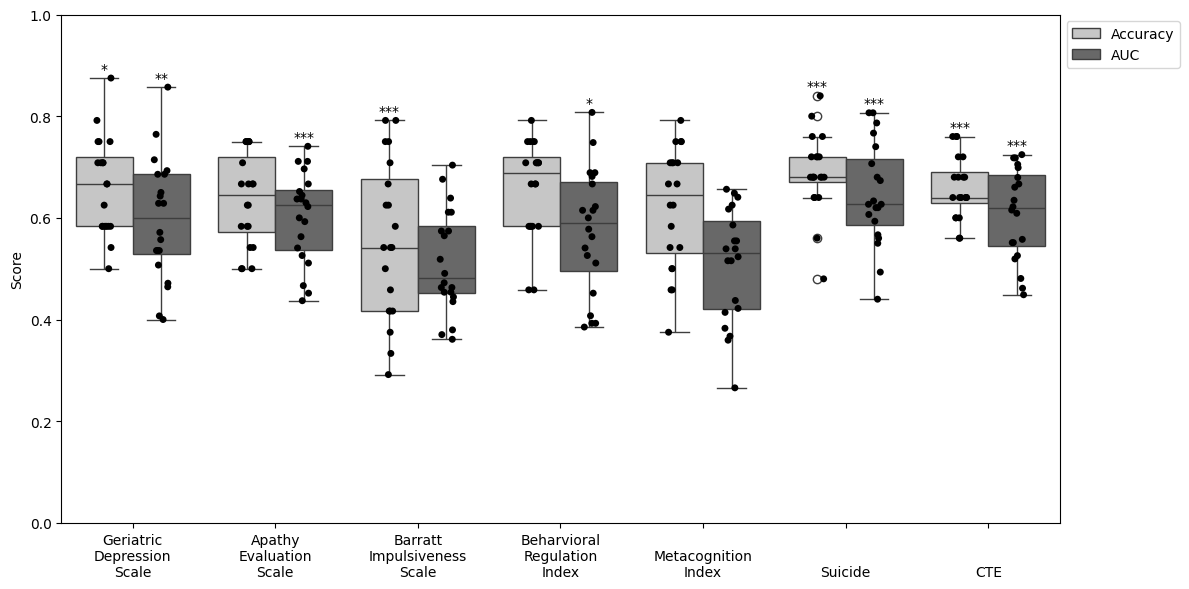

In [78]:
names = ['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide', 'cte']
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all']) for name in names}
dfs['cte'] = pd.DataFrame(u30_df.to_numpy(), columns=['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all'])
data_frames = [dfs[name] for name in names]
double_p_value_dict = {name:{'AUC': getP(dfs[name], c='AUC'), 'ACC': getP(dfs[name], c='Accuracy', expected_val = getExpectedVal(name))} for name in names}
xlabel_dict = {'bri': 'Beharvioral\nRegulation\nIndex', 
               'aes': 'Apathy\nEvaluation\nScale', 
               'gds': 'Geriatric\nDepression\nScale', 
               'bis': 'Barratt\nImpulsiveness\nScale', 
               'tmi': '\nMetacognition\nIndex', 
               'suicide': '\n\nSuicide', 
               'cte': '\n\nCTE'}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['Accuracy', 'AUC'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
#     p = pvalue_dict.get(name)
    ps = double_p_value_dict[name]
    pauc = ps['AUC']
    pacc = ps['ACC']
    position = ticks[i] - 0.2
#     if p is not None:
    ax.text(position + 0.4, max(melted_data[(melted_data['Metric'] == 'AUC') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(pauc), ha='center', va='bottom')
    ax.text(position, max(melted_data[(melted_data['Metric'] == 'Accuracy') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(pacc), ha='center', va='bottom')
# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('')
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [80]:
out_data = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_fixed.pkl')
names = ['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide', 'cte']
cols = ['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all']
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=cols) for name in names}
dfs['cte'] = pd.DataFrame(u30_df.to_numpy(), columns=['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all'])

double_p_value_dict = {name:{'AUC': getP(dfs[name], c='AUC'), 'ACC': getP(dfs[name], c='Accuracy', expected_val = getExpectedVal(name))} for name in names}
for name in names: 
    print(name, np.mean(dfs[name]['AUC']), np.mean(dfs[name]['Accuracy']), double_p_value_dict[name])

gds 0.5967857142857143 0.6625000000000001 {'AUC': 0.0014324188232421875, 'ACC': 0.013616561889648438}
aes 0.6018518518518519 0.6354166666666666 {'AUC': 0.000209808349609375, 'ACC': 0.956329345703125}
bis 0.512962962962963 0.5562500000000001 {'AUC': 0.6742229461669922, 'ACC': 0.000133514404296875}
bri 0.5740740740740741 0.6583333333333333 {'AUC': 0.017181396484375, 'ACC': 0.1893482208251953}
tmi 0.508203125 0.6208333333333333 {'AUC': 0.6476554870605469, 'ACC': 0.3117942810058594}
suicide 0.6451666666666666 0.688 {'AUC': 1.33514404296875e-05, 'ACC': 0.0007076263427734375}
cte 0.6073717948717949 0.6599999999999999 {'AUC': 0.0001678466796875, 'ACC': 1.9073486328125e-06}


In [81]:
out_data = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_kan_results_fixed.pkl')
names = ['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide', 'cte']
cols = ['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all']
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=cols) for name in names}
dfs['cte'] = pd.DataFrame(u30_df.to_numpy(), columns=['k','AUC','F1','Accuracy', 'AUC all','F1 all','Acc all'])

double_p_value_dict = {name:{'AUC': getP(dfs[name], c='AUC all'), 'ACC': getP(dfs[name], c='Acc all', expected_val = getExpectedVal(name))} for name in names}
for name in names: 
    print(name, np.mean(dfs[name]['AUC all']), double_p_value_dict[name])

gds 0.8354477611940299 {'AUC': 1.9073486328125e-06, 'ACC': 3.814697265625e-06}
aes 0.8194994499449946 {'AUC': 1.9073486328125e-06, 'ACC': 0.0002613067626953125}
bis 0.7842276422764228 {'AUC': 1.9073486328125e-06, 'ACC': 0.21616744995117188}
bri 0.8079482948294832 {'AUC': 1.9073486328125e-06, 'ACC': 0.001689910888671875}
tmi 0.7963977832512315 {'AUC': 1.9073486328125e-06, 'ACC': 0.09730720520019531}
suicide 0.879328231292517 {'AUC': 1.9073486328125e-06, 'ACC': 3.814697265625e-06}
cte 0.6859505862646567 {'AUC': 1.9073486328125e-06, 'ACC': 1.9073486328125e-06}


/tmp/ipykernel_123200/2058696307.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


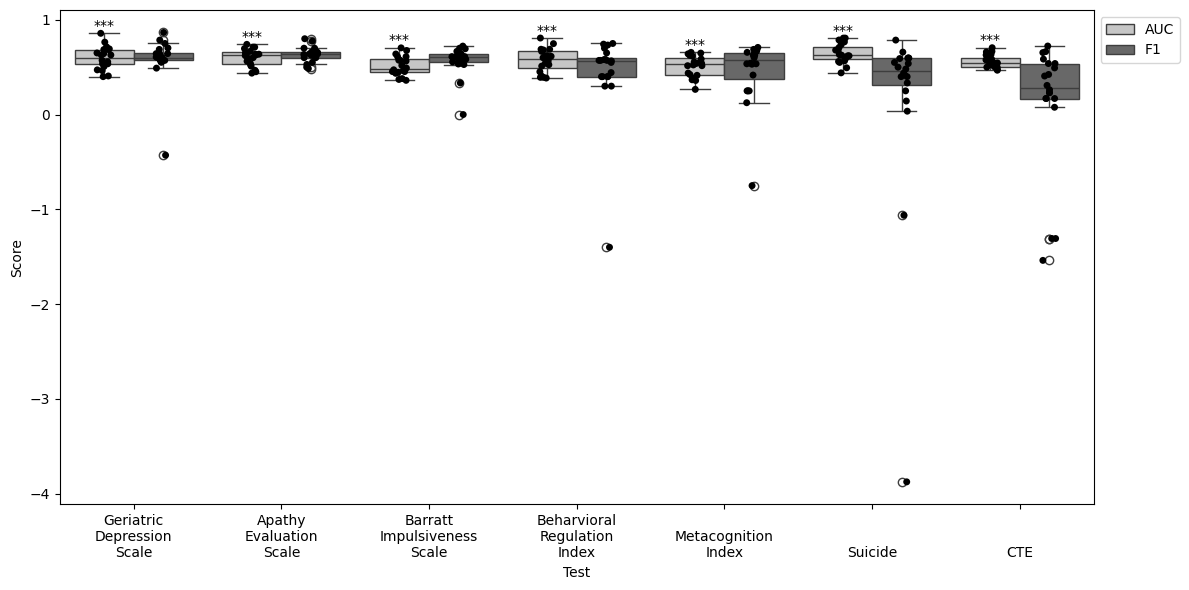

In [168]:
pvalue_dict = pvalue_dict = {name: getP(dfs[name]) for name in names}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['AUC', 'F1'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    position = ticks[i] - 0.2
    if p is not None:
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'AUC') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(p), ha='center', va='bottom')

# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Test')
plt.tight_layout()
plt.show()

In [81]:
mlp_data = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/u30_mlp_results.pkl')

{'gds': 0.03276824951171875, 'aes': 0.1230926513671875, 'bis': 0.13272666931152344, 'bri': 0.01923370361328125, 'tmi': 0.0003948211669921875, 'suicide': 0.4523754119873047, 'cte': 3.62396240234375e-05}


/tmp/ipykernel_123200/1078513876.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


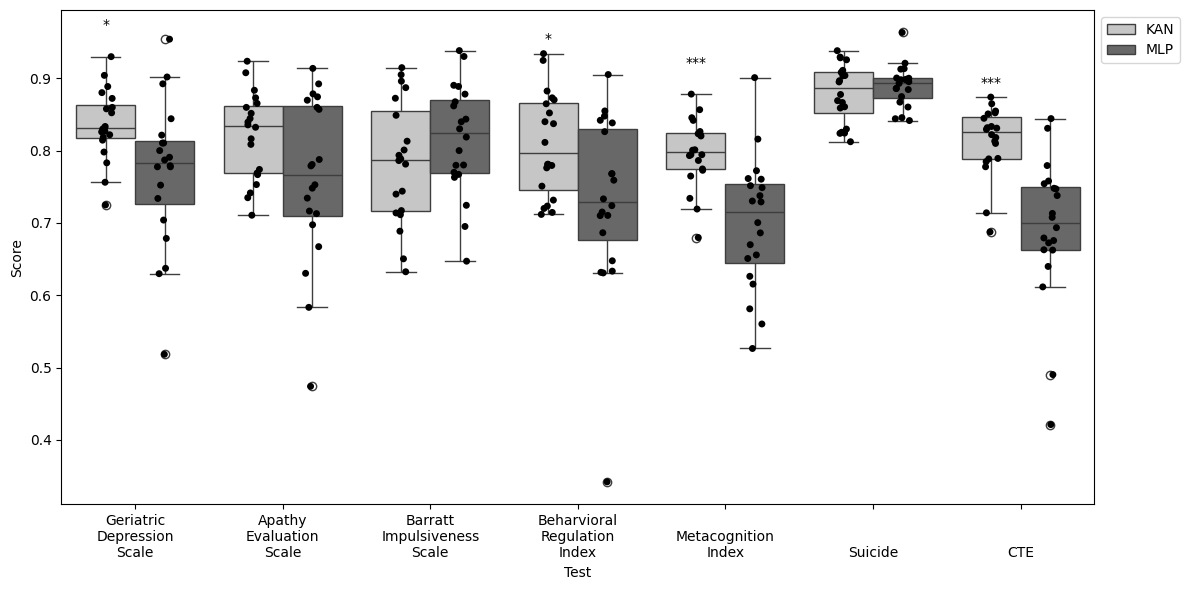

In [157]:
mlp_dfs = {name: pd.DataFrame(mlp_data[name]['df'], columns=['k','AUC <= 30','F1 <= 30','Acc <= 30', 'AUC','F1','Acc']) for name in names}
mlp_data_frames = [mlp_dfs[name] for name in names]
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=['k','AUC <= 30','F1 <= 30','Acc <= 30', 'AUC','F1','Acc']) for name in names}
kan_data_frames = [dfs[name] for name in names]

for df in kan_data_frames:
    df['Model'] = 'KAN'
for df in mlp_data_frames:
    df['Model'] = 'MLP'
    
pvalue_dict = {}
for name in names:
    kan_auc = all_kan_data.loc[name]['AUC']
    mlp_auc = all_mlp_data.loc[name]['AUC']
    stat, p_value = wilcoxon(kan_auc, mlp_auc)
    pvalue_dict[name] = p_value
    
print(pvalue_dict)

all_kan_data = pd.concat(kan_data_frames, keys=names)
all_mlp_data = pd.concat(mlp_data_frames, keys=names)
all_data = pd.concat([all_kan_data, all_mlp_data])

melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k', 'Model'], value_vars=['AUC'], var_name='Metric', value_name='Score')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Model', ax=ax, palette='Grays')
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Model', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    position = ticks[i] - .2
    if p is not None:
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'AUC') & (melted_data['level_0'] == name)]['Score']) + 0.01, 
                p_value_to_asterisks(p), ha='center', va='bottom', color='black')

ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Test')
plt.tight_layout()
plt.show()

TtestResult(statistic=2.7036670099081364, pvalue=0.0077143246605003955, df=139)
0.6367619047619049
0.6032023809523811
Wilcoxon test statistic: 2659.0
P-value: 0.00522174510115996


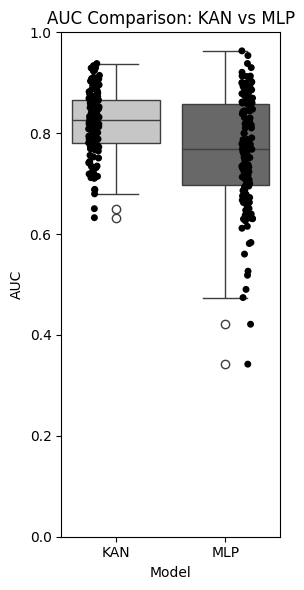

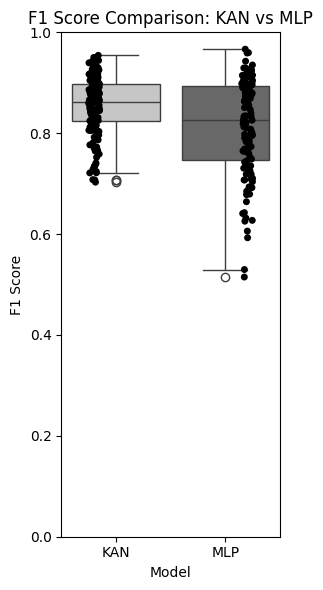

In [158]:
from scipy.stats import ttest_rel

print(ttest_rel(auc_kan, auc_mlp))

print(np.mean(auc_kan))
print(np.mean(auc_mlp))

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(auc_kan, auc_mlp)

print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value}")

# Plot AUC comparison
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
sns.boxplot(data=melted_data_auc, x='Model', y='Score', ax=ax, hue='Model', palette='Grays', legend=False)
sns.stripplot(data=melted_data_auc, x='Model', y='Score', dodge=True, hue='Model', palette=['black', 'black'], ax=ax, legend=False)

# Adjust legend and show plot for AUC comparison
plt.xlabel('Model')
plt.ylim([0, 1])
plt.ylabel('AUC')
plt.title('AUC Comparison: KAN vs MLP')
plt.tight_layout()
plt.show()

# Extract AUC scores for KAN and MLP
auc_kan = all_data[all_data['Model'] == 'KAN']['AUC']
auc_mlp = all_data[all_data['Model'] == 'MLP']['AUC']

# Plot F1 comparison
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
sns.boxplot(data=melted_data_f1, x='Model', y='Score', ax=ax, hue='Model', palette='Grays', legend=False)
sns.stripplot(data=melted_data_f1, x='Model', y='Score', dodge=True, hue='Model', palette=['black', 'black'], ax=ax, legend=False)

# Adjust legend and show plot for F1 comparison
plt.xlabel('Model')
plt.ylim([0, 1])
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: KAN vs MLP')
plt.tight_layout()
plt.show()

/tmp/ipykernel_123200/275435305.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


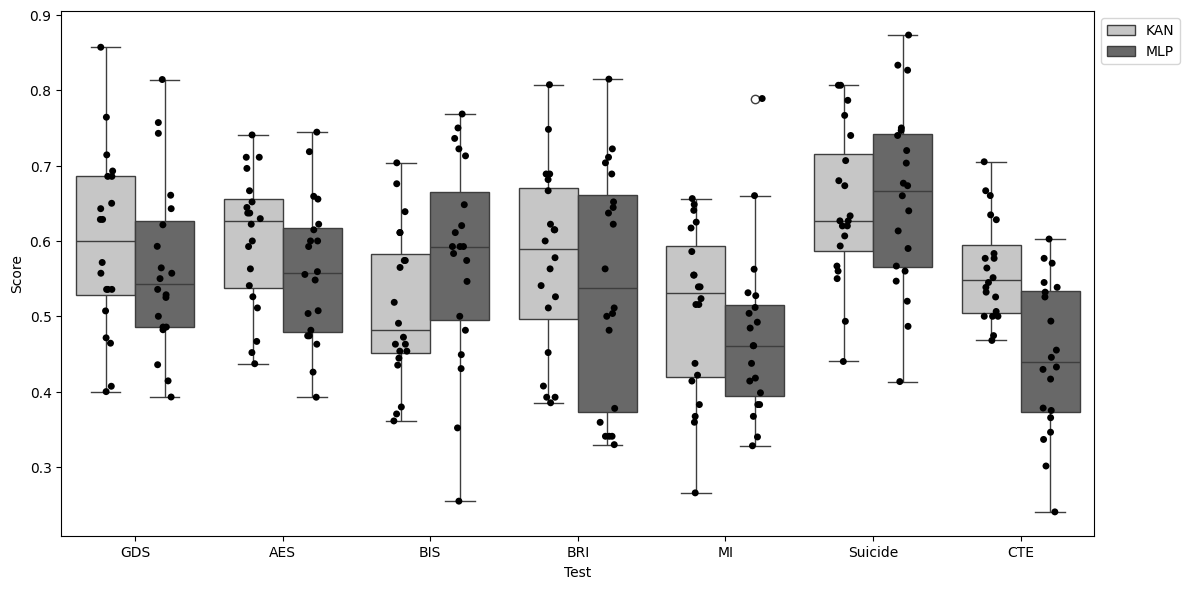

In [122]:
mlp_dfs = {name: pd.DataFrame(mlp_data[name]['df'], columns=['k','AUC <= 30','F1 <= 30','Acc <= 30', 'AUC','F1','Acc']) for name in names}
mlp_data_frames = [mlp_dfs[name] for name in names]
kan_data_frames = [dfs[name] for name in names]

for df in kan_data_frames:
    df['Model'] = 'KAN'
for df in mlp_data_frames:
    df['Model'] = 'MLP'

all_kan_data = pd.concat(kan_data_frames, keys=names)
all_mlp_data = pd.concat(mlp_data_frames, keys=names)
all_data = pd.concat([all_kan_data, all_mlp_data])

melted_data_auc = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k', 'Model'], value_vars=['AUC <= 30'], var_name='Metric', value_name='Score')
melted_data_f1 = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k', 'Model'], value_vars=['F1 <= 30'], var_name='Metric', value_name='Score')

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data_auc, x='level_0', y='Score', hue='Model', ax=ax, palette='Grays')
sns.stripplot(data=melted_data_auc, x='level_0', y='Score', hue='Model', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Test')
plt.tight_layout()
plt.show()

TtestResult(statistic=2.7036670099081364, pvalue=0.0077143246605003955, df=139)
0.6367619047619049
0.6032023809523811
Wilcoxon test statistic: 2659.0
P-value: 0.00522174510115996


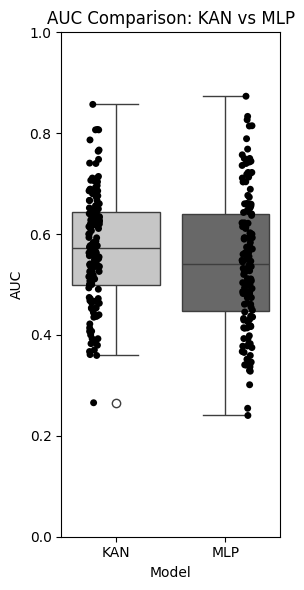

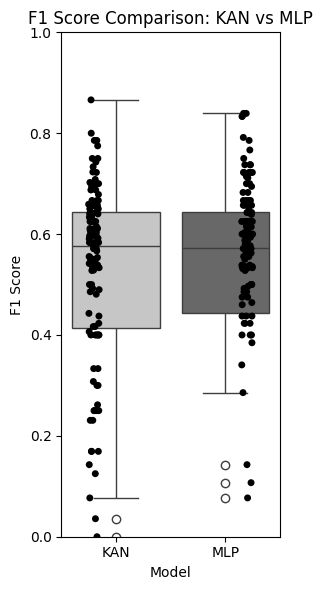

In [127]:
from scipy.stats import ttest_rel

# Extract AUC scores for KAN and MLP
auc_kan = all_data[all_data['Model'] == 'KAN']['Acc <= 30']
auc_mlp = all_data[all_data['Model'] == 'MLP']['Acc <= 30']

print(ttest_rel(auc_kan, auc_mlp))

print(np.mean(auc_kan))
print(np.mean(auc_mlp))

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(auc_kan, auc_mlp)

print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value}")

# Plot AUC comparison
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
sns.boxplot(data=melted_data_auc, x='Model', y='Score', ax=ax, hue='Model', palette='Grays', legend=False)
sns.stripplot(data=melted_data_auc, x='Model', y='Score', dodge=True, hue='Model', palette=['black', 'black'], ax=ax, legend=False)

# Adjust legend and show plot for AUC comparison
plt.xlabel('Model')
plt.ylim([0, 1])
plt.ylabel('AUC')
plt.title('AUC Comparison: KAN vs MLP')
plt.tight_layout()
plt.show()

# Plot F1 comparison
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
sns.boxplot(data=melted_data_f1, x='Model', y='Score', ax=ax, hue='Model', palette='Grays', legend=False)
sns.stripplot(data=melted_data_f1, x='Model', y='Score', dodge=True, hue='Model', palette=['black', 'black'], ax=ax, legend=False)

# Adjust legend and show plot for F1 comparison
plt.xlabel('Model')
plt.ylim([0, 1])
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: KAN vs MLP')
plt.tight_layout()
plt.show()

/tmp/ipykernel_16509/604550826.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


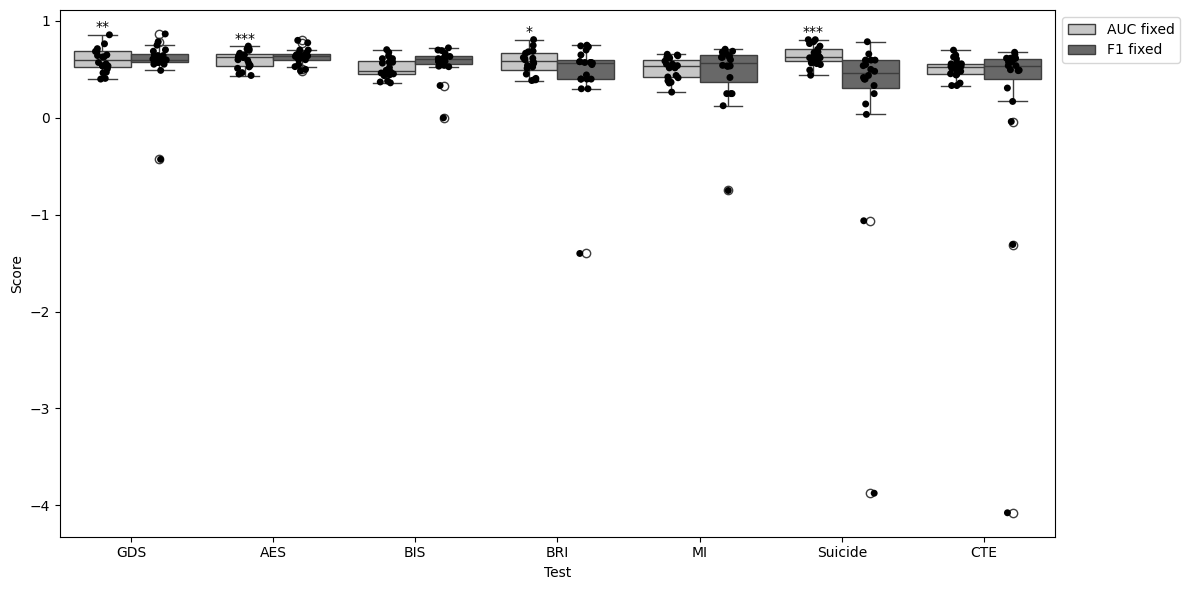

In [174]:
data_frames = [u30_gds_df, u30_aes_df, u30_bis_df, u30_bri_df, u30_tmi_df, u30_suicide_df, u30_df]
names = ['gds', 'aes', 'bis', 'bri', 'mi', 'suicide', 'cte']
pvalue_dict = {'bri': getP(u30_bri_df, 'AUC fixed'), 'aes': getP(u30_aes_df, 'AUC fixed'), 'gds': getP(u30_gds_df, 'AUC fixed'), 'bis': getP(u30_bis_df, 'AUC fixed'), 'mi': getP(u30_tmi_df, 'AUC fixed'), 'suicide': getP(u30_suicide_df, 'AUC fixed'), 'cte': getP(u30_df, 'AUC fixed')}
xlabel_dict = {'bri': 'BRI', 'aes': 'AES', 'gds': 'GDS', 'bis': 'BIS', 'mi': 'MI', 'suicide': 'Suicide', 'cte': 'CTE'}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['AUC fixed', 'F1 fixed'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    position = ticks[i] - 0.2
    if p is not None:
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'AUC fixed') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(p), ha='center', va='bottom')

# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Test')
plt.tight_layout()
# plt.ylim([0, 1])
plt.show()

/tmp/ipykernel_16509/503207296.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


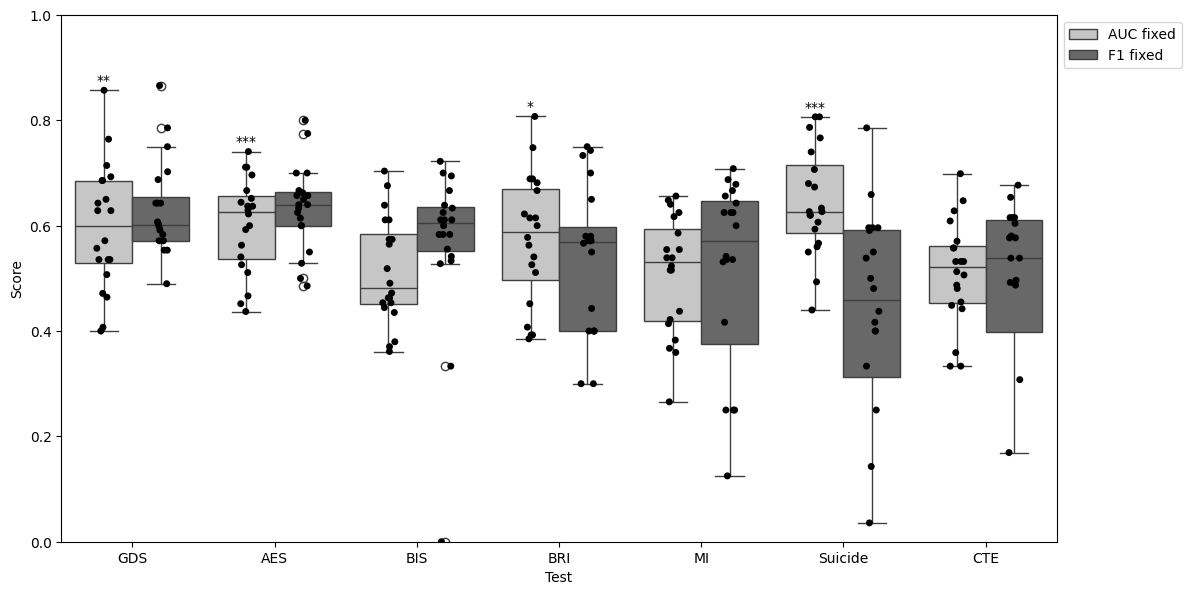

In [175]:
data_frames = [u30_gds_df, u30_aes_df, u30_bis_df, u30_bri_df, u30_tmi_df, u30_suicide_df, u30_df]
names = ['gds', 'aes', 'bis', 'bri', 'mi', 'suicide', 'cte']
pvalue_dict = {'bri': getP(u30_bri_df, 'AUC fixed'), 'aes': getP(u30_aes_df, 'AUC fixed'), 'gds': getP(u30_gds_df, 'AUC fixed'), 'bis': getP(u30_bis_df, 'AUC fixed'), 'mi': getP(u30_tmi_df, 'AUC fixed'), 'suicide': getP(u30_suicide_df, 'AUC fixed'), 'cte': getP(u30_df, 'AUC fixed')}
xlabel_dict = {'bri': 'BRI', 'aes': 'AES', 'gds': 'GDS', 'bis': 'BIS', 'mi': 'MI', 'suicide': 'Suicide', 'cte': 'CTE'}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['AUC fixed', 'F1 fixed'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    position = ticks[i] - 0.2
    if p is not None:
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'AUC fixed') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(p), ha='center', va='bottom')

# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('Test')
plt.tight_layout()
plt.ylim([0, 1])
plt.show()

In [159]:
rhi['no_cte'] = (rhi['cte']==0).astype(int)

In [131]:
for test in ['suicide', 'bis', 'bri', 'tmi', 'aes', 'gds']: print(f"""u30_{test}_nocte_df, u30_{test}_nocte_p, u30_{test}_nocte_model = run_kan_predict_both('{test}', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)""")

u30_cte_nocte_df, u30_cte_nocte_p, u30_cte_nocte_model = run_kan_predict_both('cte', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)
u30_suicide_nocte_df, u30_suicide_nocte_p, u30_suicide_nocte_model = run_kan_predict_both('suicide', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)
u30_bis_nocte_df, u30_bis_nocte_p, u30_bis_nocte_model = run_kan_predict_both('bis', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)
u30_bri_nocte_df, u30_bri_nocte_p, u30_bri_nocte_model = run_kan_predict_both('bri', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)
u30_tmi_nocte_df, u30_tmi_nocte_p, u30_tmi_nocte_model = run_kan_predict_both('tmi', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)
u30_aes_nocte_df, u30_aes_nocte_p, u30_aes_nocte_model = run_kan_predict_both('aes', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)
u30_gds_nocte_df, u30_gds_nocte_p, u30_gds_nocte_model = run_kan_predict_both('gds', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)


0 of 20


train loss: 4.56e-01 | test loss: 2.03e+00 | reg: 4.85e+01 : 100%|████| 3/3 [01:08<00:00, 22.96s/it]


0.6983304548071387 0.8341968911917099 0.8483412322274881
0.6932707355242567 0.7464788732394367 0.797752808988764
1 of 20


train loss: 5.17e-01 | test loss: 1.85e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:06<00:00, 22.05s/it]


0.7449625791594704 0.8367875647668394 0.8009478672985783
0.730829420970266 0.7676056338028169 0.7528089887640449
2 of 20


train loss: 4.71e-01 | test loss: 2.00e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:07<00:00, 22.57s/it]


0.7337363270005756 0.8068097705403405 0.7251184834123223
0.7738654147104852 0.8370221327967808 0.797752808988764
3 of 20


train loss: 4.80e-01 | test loss: 2.71e+00 | reg: 5.08e+01 : 100%|████| 3/3 [01:04<00:00, 21.38s/it]


0.6296776050662061 0.7124352331606219 0.6492890995260664
0.6025039123630673 0.6514084507042254 0.6292134831460674
4 of 20


train loss: 4.99e-01 | test loss: 2.03e+00 | reg: 4.96e+01 : 100%|████| 3/3 [01:06<00:00, 22.30s/it]


0.752734599884859 0.8206456755679554 0.7630331753554502
0.7433489827856026 0.7854821235102926 0.7528089887640449
5 of 20


train loss: 4.11e-01 | test loss: 2.42e+00 | reg: 5.15e+01 : 100%|████| 3/3 [01:12<00:00, 24.23s/it]


0.800518134715026 0.819300518134715 0.7061611374407583
0.7863849765258215 0.80193661971831 0.7191011235955056
6 of 20


train loss: 4.51e-01 | test loss: 2.07e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:10<00:00, 23.58s/it]


0.8192285549798504 0.8694300518134714 0.8009478672985783
0.7981220657276996 0.8478873239436621 0.797752808988764
7 of 20


train loss: 4.69e-01 | test loss: 2.03e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:04<00:00, 21.50s/it]


0.7006332757628095 0.7394087168546175 0.5497630331753555
0.7081377151799687 0.7306338028169015 0.6179775280898876
8 of 20


train loss: 5.01e-01 | test loss: 1.70e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:12<00:00, 24.03s/it]


0.7363270005757052 0.7707253886010363 0.7203791469194313
0.6948356807511737 0.693661971830986 0.6741573033707865
9 of 20


train loss: 4.56e-01 | test loss: 2.03e+00 | reg: 4.96e+01 : 100%|████| 3/3 [01:11<00:00, 23.83s/it]


0.7619458837075417 0.794818652849741 0.6872037914691943
0.8098591549295775 0.8225352112676056 0.7640449438202247
10 of 20


train loss: 4.87e-01 | test loss: 2.09e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:09<00:00, 23.31s/it]


0.6445020149683363 0.7058589079314467 0.6113744075829384
0.6713615023474179 0.7253521126760564 0.7078651685393258
11 of 20


train loss: 5.00e-01 | test loss: 1.95e+00 | reg: 4.84e+01 : 100%|████| 3/3 [01:05<00:00, 21.87s/it]


0.8221070811744386 0.9152143193593971 0.9052132701421801
0.8161189358372456 0.8225352112676056 0.7640449438202247
12 of 20


train loss: 4.63e-01 | test loss: 2.18e+00 | reg: 4.97e+01 : 100%|████| 3/3 [01:13<00:00, 24.41s/it]


0.7769142199194012 0.7883618971701873 0.7203791469194313
0.7644757433489828 0.7845070422535213 0.8089887640449438
13 of 20


train loss: 4.95e-01 | test loss: 2.09e+00 | reg: 4.80e+01 : 100%|████| 3/3 [01:05<00:00, 21.99s/it]


0.7987910189982729 0.8367875647668394 0.7677725118483413
0.8051643192488263 0.8189134808853119 0.7752808988764045
14 of 20


train loss: 4.80e-01 | test loss: 1.98e+00 | reg: 5.03e+01 : 100%|████| 3/3 [01:09<00:00, 23.14s/it]


0.7717328727691422 0.7868245743893412 0.6966824644549763
0.7910798122065728 0.8098591549295775 0.797752808988764
15 of 20


train loss: 5.14e-01 | test loss: 1.80e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:09<00:00, 23.08s/it]


0.7371905584340818 0.8484455958549223 0.8151658767772512
0.7488262910798121 0.7992957746478874 0.7865168539325843
16 of 20


train loss: 4.89e-01 | test loss: 1.90e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:07<00:00, 22.48s/it]


0.775474956822107 0.7755829015544041 0.6350710900473934
0.7582159624413145 0.7854821235102926 0.7528089887640449
17 of 20


train loss: 5.00e-01 | test loss: 2.08e+00 | reg: 5.00e+01 : 100%|████| 3/3 [01:10<00:00, 23.59s/it]


0.8008059873344847 0.8708648864089279 0.8293838862559242
0.757433489827856 0.8049837486457204 0.7752808988764045
18 of 20


train loss: 5.01e-01 | test loss: 2.06e+00 | reg: 4.84e+01 : 100%|████| 3/3 [01:11<00:00, 23.73s/it]


0.6848013816925734 0.772020725388601 0.7914691943127962
0.7089201877934272 0.7012072434607646 0.6292134831460674
19 of 20


train loss: 4.71e-01 | test loss: 1.98e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:02<00:00, 20.77s/it]


0.6830742659758204 0.6865284974093265 0.4265402843601896
0.6784037558685445 0.6760563380281691 0.48314606741573035
0.743674438687392
0.7995524166857221
Statistics=0.0, p=1.9073486328125e-06
Statistics=0.0, p=1.9073486328125e-06


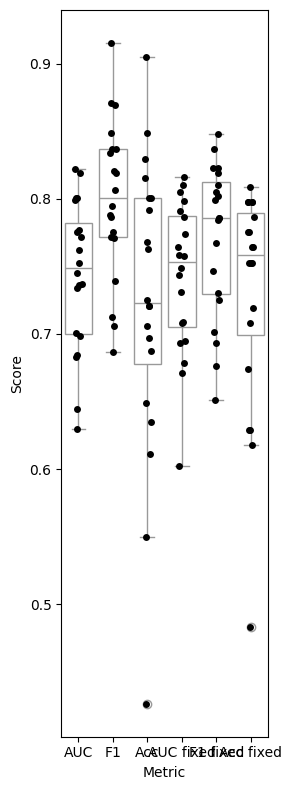

In [160]:
u30_suicide_nocte_df, u30_suicide_nocte_p, u30_suicide_nocte_model = run_kan_predict_both('suicide', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 5.16e-01 | test loss: 2.54e+00 | reg: 5.31e+01 : 100%|████| 3/3 [01:08<00:00, 22.80s/it]


0.5403846153846155 0.6635897435897435 0.8056872037914692
0.5694444444444444 0.5925925925925927 0.375
1 of 20


train loss: 7.26e-01 | test loss: 1.60e+00 | reg: 4.57e+01 : 100%|████| 3/3 [01:06<00:00, 22.25s/it]


0.5641025641025641 0.6581196581196581 0.6445497630331753
0.6015625 0.654320987654321 0.6818181818181818
2 of 20


train loss: 6.96e-01 | test loss: 1.58e+00 | reg: 4.61e+01 : 100%|████| 3/3 [01:09<00:00, 23.09s/it]


0.5426282051282052 0.6088888888888888 0.3222748815165877
0.5868055555555556 0.6444444444444445 0.45454545454545453
3 of 20


train loss: 6.21e-01 | test loss: 2.07e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:07<00:00, 22.60s/it]


0.5259615384615385 0.5743589743589744 0.6066350710900474
0.546875 0.5000000000000001 0.5909090909090909
4 of 20


train loss: 6.36e-01 | test loss: 1.80e+00 | reg: 4.67e+01 : 100%|████| 3/3 [01:06<00:00, 22.09s/it]


0.4580128205128205 0.5865877712031558 0.3791469194312796
0.3888888888888889 0.5128205128205129 0.3522727272727273
5 of 20


train loss: 5.97e-01 | test loss: 2.09e+00 | reg: 4.86e+01 : 100%|████| 3/3 [01:02<00:00, 20.97s/it]


0.5897435897435899 0.7362637362637362 0.7867298578199052
0.6145833333333333 0.6825396825396826 0.7727272727272727
6 of 20


train loss: 7.70e-01 | test loss: 1.61e+00 | reg: 4.52e+01 : 100%|████| 3/3 [01:08<00:00, 22.73s/it]


0.5955128205128205 0.6456876456876456 0.5497630331753555
0.6102430555555556 0.6262626262626263 0.5795454545454546
7 of 20


train loss: 6.50e-01 | test loss: 2.00e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:10<00:00, 23.36s/it]


0.6086538461538462 0.7655677655677655 0.8104265402843602
0.6319444444444444 0.6984126984126984 0.7840909090909091
8 of 20


train loss: 5.95e-01 | test loss: 2.01e+00 | reg: 4.74e+01 : 100%|████| 3/3 [01:04<00:00, 21.42s/it]


0.6150641025641026 0.6395604395604395 0.41706161137440756
0.6493055555555556 0.6746031746031748 0.5340909090909091
9 of 20


train loss: 7.46e-01 | test loss: 1.53e+00 | reg: 4.54e+01 : 100%|████| 3/3 [01:08<00:00, 22.78s/it]


0.6176282051282052 0.6553846153846155 0.4028436018957346
0.6883680555555556 0.7111111111111111 0.5568181818181818
10 of 20


train loss: 6.10e-01 | test loss: 1.99e+00 | reg: 4.74e+01 : 100%|████| 3/3 [01:10<00:00, 23.42s/it]


0.6073717948717948 0.7230769230769231 0.7440758293838863
0.5772569444444444 0.6250000000000001 0.6931818181818182
11 of 20


train loss: 6.31e-01 | test loss: 2.20e+00 | reg: 4.76e+01 : 100%|████| 3/3 [01:08<00:00, 22.81s/it]


0.421474358974359 0.5377777777777777 0.1990521327014218
0.4800347222222222 0.5407407407407409 0.29545454545454547
12 of 20


train loss: 5.69e-01 | test loss: 2.34e+00 | reg: 4.86e+01 : 100%|████| 3/3 [01:07<00:00, 22.55s/it]


0.5073717948717948 0.6262108262108261 0.6113744075829384
0.5338541666666667 0.5925925925925927 0.625
13 of 20


train loss: 5.83e-01 | test loss: 2.20e+00 | reg: 4.82e+01 : 100%|████| 3/3 [01:09<00:00, 23.31s/it]


0.5830128205128204 0.6672364672364672 0.6540284360189573
0.615451388888889 0.6913580246913581 0.7159090909090909
14 of 20


train loss: 5.26e-01 | test loss: 2.19e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:09<00:00, 23.30s/it]


0.5762820512820513 0.7784615384615384 0.8720379146919431
0.5911458333333334 0.6296296296296298 0.7727272727272727
15 of 20


train loss: 6.06e-01 | test loss: 2.07e+00 | reg: 4.88e+01 : 100%|████| 3/3 [01:07<00:00, 22.52s/it]


0.4403846153846154 0.5205128205128204 0.11374407582938388
0.453125 0.5277777777777779 0.22727272727272727
16 of 20


train loss: 5.24e-01 | test loss: 2.27e+00 | reg: 4.84e+01 : 100%|████| 3/3 [01:09<00:00, 23.07s/it]


0.5554487179487179 0.627039627039627 0.5260663507109005
0.5086805555555556 0.5277777777777779 0.6136363636363636
17 of 20


train loss: 6.42e-01 | test loss: 1.93e+00 | reg: 4.68e+01 : 100%|████| 3/3 [01:15<00:00, 25.06s/it]


0.49583333333333335 0.6376068376068376 0.7488151658767772
0.49826388888888884 0.5370370370370371 0.7159090909090909
18 of 20


train loss: 6.63e-01 | test loss: 1.99e+00 | reg: 4.75e+01 : 100%|████| 3/3 [01:12<00:00, 24.02s/it]


0.430448717948718 0.5512820512820512 0.17061611374407584
0.5069444444444444 0.547008547008547 0.3977272727272727
19 of 20


train loss: 6.50e-01 | test loss: 1.88e+00 | reg: 4.69e+01 : 100%|████| 3/3 [01:07<00:00, 22.55s/it]


0.41057692307692306 0.5230769230769231 0.11848341232227488
0.42013888888888884 0.5277777777777779 0.22727272727272727
0.5342948717948717
0.6363145515453207
Statistics=50.0, p=0.039989471435546875
Statistics=36.5, p=0.009435653686523438


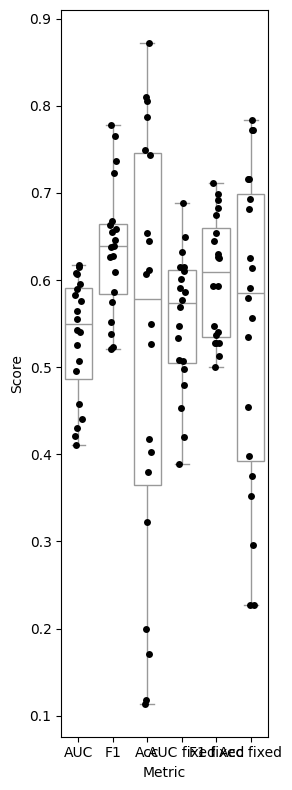

In [161]:
u30_bis_nocte_df, u30_bis_nocte_p, u30_bis_nocte_model = run_kan_predict_both('bis', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 6.73e-01 | test loss: 2.25e+00 | reg: 4.94e+01 : 100%|████| 3/3 [01:03<00:00, 21.23s/it]


0.4873376623376623 0.5539772727272728 0.2559241706161137
0.5245283018867924 0.5849056603773586 0.5
1 of 20


train loss: 6.32e-01 | test loss: 2.16e+00 | reg: 4.82e+01 : 100%|████| 3/3 [01:06<00:00, 22.02s/it]


0.5102272727272728 0.5078125 0.5308056872037915
0.5099730458221025 0.339622641509434 0.5454545454545454
2 of 20


train loss: 6.14e-01 | test loss: 2.45e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:13<00:00, 24.41s/it]


0.5426948051948052 0.5796745867768595 0.5592417061611374
0.49595687331536387 0.52069385270846 0.48863636363636365
3 of 20


train loss: 6.13e-01 | test loss: 2.61e+00 | reg: 5.26e+01 : 100%|████| 3/3 [01:09<00:00, 23.14s/it]


0.43847402597402596 0.45312500000000006 0.4786729857819905
0.44528301886792454 0.30660377358490565 0.5227272727272727
4 of 20


train loss: 5.64e-01 | test loss: 2.55e+00 | reg: 4.97e+01 : 100%|████| 3/3 [01:09<00:00, 23.29s/it]


0.5058441558441559 0.5286195286195287 0.3933649289099526
0.5029649595687331 0.43745632424877723 0.4772727272727273
5 of 20


train loss: 6.43e-01 | test loss: 1.97e+00 | reg: 4.79e+01 : 100%|████| 3/3 [01:07<00:00, 22.47s/it]


0.6235389610389611 0.6672858391608393 0.5876777251184834
0.6512129380053909 0.644412191582003 0.6818181818181818
6 of 20


train loss: 5.86e-01 | test loss: 2.50e+00 | reg: 4.99e+01 : 100%|████| 3/3 [01:06<00:00, 22.14s/it]


0.5915584415584416 0.5823863636363638 0.8009478672985783
0.613477088948787 0.4091360476663357 0.6136363636363636
7 of 20


train loss: 6.26e-01 | test loss: 2.16e+00 | reg: 4.81e+01 : 100%|████| 3/3 [01:11<00:00, 23.90s/it]


0.5301948051948051 0.2642045454545455 0.8246445497630331
0.554177897574124 0.5230607966457025 0.5568181818181818
8 of 20


train loss: 6.28e-01 | test loss: 2.54e+00 | reg: 5.13e+01 : 100%|████| 3/3 [01:16<00:00, 25.34s/it]


0.5360389610389611 0.5551734449760767 0.5971563981042654
0.4948787061994609 -0.0205831903945111 0.6136363636363636
9 of 20


train loss: 5.78e-01 | test loss: 2.27e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:12<00:00, 24.27s/it]


0.424512987012987 0.5198863636363636 0.1990521327014218
0.41940700808625336 0.5283018867924529 0.4318181818181818
10 of 20


train loss: 5.92e-01 | test loss: 2.79e+00 | reg: 5.14e+01 : 100%|████| 3/3 [01:14<00:00, 24.97s/it]


0.5183441558441558 0.5028409090909092 0.6919431279620853
0.5056603773584905 0.22955974842767307 0.6022727272727273
11 of 20


train loss: 5.93e-01 | test loss: 2.46e+00 | reg: 5.05e+01 : 100%|████| 3/3 [01:11<00:00, 23.91s/it]


0.647077922077922 0.6413352272727273 0.5213270142180095
0.597843665768194 0.37846836847946724 0.6363636363636364
12 of 20


train loss: 5.80e-01 | test loss: 2.51e+00 | reg: 5.10e+01 : 100%|████| 3/3 [01:10<00:00, 23.35s/it]


0.5892857142857143 0.6152420948616601 0.5781990521327014
0.6549865229110511 0.5693191140278917 0.6590909090909091
13 of 20


train loss: 5.77e-01 | test loss: 2.41e+00 | reg: 4.96e+01 : 100%|████| 3/3 [01:15<00:00, 25.06s/it]


0.5003246753246753 0.45312500000000006 0.5308056872037915
0.46522911051212934 0.22955974842767307 0.5227272727272727
14 of 20


train loss: 5.72e-01 | test loss: 2.28e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:13<00:00, 24.45s/it]


0.6178571428571429 0.6420454545454546 0.6587677725118484
0.5924528301886792 0.43867924528301894 0.6136363636363636
15 of 20


train loss: 5.47e-01 | test loss: 3.08e+00 | reg: 5.53e+01 : 100%|████| 3/3 [01:11<00:00, 23.86s/it]


0.566396103896104 0.5492424242424243 0.6777251184834123
0.5493261455525608 0.2515723270440252 0.6136363636363636
16 of 20


train loss: 5.55e-01 | test loss: 2.49e+00 | reg: 5.00e+01 : 100%|████| 3/3 [01:14<00:00, 24.94s/it]


0.5117694805194806 0.5556640625 0.3222748815165877
0.5460916442048518 0.3007769145394007 0.5909090909090909
17 of 20


train loss: 5.82e-01 | test loss: 2.45e+00 | reg: 5.05e+01 : 100%|████| 3/3 [01:10<00:00, 23.55s/it]


0.47889610389610393 0.5194128787878788 0.45023696682464454
0.4964959568733153 0.449685534591195 0.5454545454545454
18 of 20


train loss: 6.19e-01 | test loss: 2.13e+00 | reg: 4.93e+01 : 100%|████| 3/3 [01:12<00:00, 24.23s/it]


0.5417207792207792 0.5613302139037434 0.6445497630331753
0.5482479784366576 0.32019977802441746 0.6022727272727273
19 of 20


train loss: 6.34e-01 | test loss: 2.19e+00 | reg: 4.83e+01 : 100%|████| 3/3 [01:13<00:00, 24.46s/it]


0.5856331168831168 0.5923295454545454 0.6113744075829384
0.5681940700808625 0.5377358490566039 0.5227272727272727
0.5373863636363636
0.5422356627823596
Statistics=38.0, p=0.01068878173828125
Statistics=45.0, p=0.023950576782226562


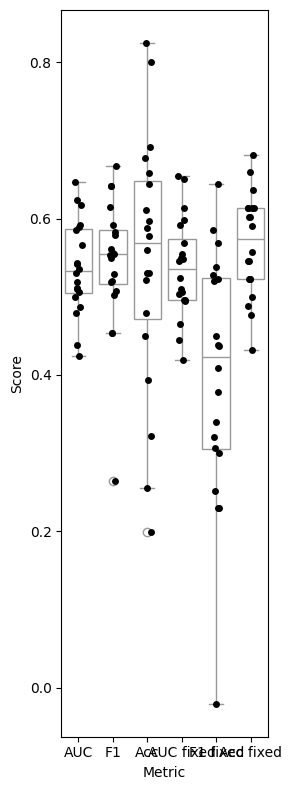

In [162]:
u30_bri_nocte_df, u30_bri_nocte_p, u30_bri_nocte_model = run_kan_predict_both('bri', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 5.86e-01 | test loss: 2.44e+00 | reg: 4.94e+01 : 100%|████| 3/3 [01:13<00:00, 24.65s/it]


0.4924930167597765 0.5415390160389258 0.24644549763033174
0.5591517857142857 0.2967032967032967 0.6363636363636364
1 of 20


train loss: 5.62e-01 | test loss: 2.48e+00 | reg: 4.98e+01 : 100%|████| 3/3 [01:10<00:00, 23.59s/it]


0.5005237430167597 0.5849960095770151 0.38388625592417064
0.5948660714285715 0.6326530612244898 0.5909090909090909
2 of 20


train loss: 5.07e-01 | test loss: 2.71e+00 | reg: 5.01e+01 : 100%|████| 3/3 [01:05<00:00, 21.69s/it]


0.44622905027932963 0.5307262569832402 0.2037914691943128
0.4302455357142857 0.5483870967741935 0.4431818181818182
3 of 20


train loss: 5.77e-01 | test loss: 2.05e+00 | reg: 4.92e+01 : 100%|████| 3/3 [01:00<00:00, 20.30s/it]


0.5151885474860335 0.5586592178770949 0.25118483412322273
0.5440848214285714 0.2857142857142856 0.6590909090909091
4 of 20


train loss: 5.55e-01 | test loss: 2.44e+00 | reg: 5.17e+01 : 100%|████| 3/3 [01:04<00:00, 21.39s/it]


0.4498952513966481 0.547486033519553 0.23222748815165878
0.5691964285714286 0.6129032258064515 0.5227272727272727
5 of 20


train loss: 5.96e-01 | test loss: 2.27e+00 | reg: 4.92e+01 : 100%|████| 3/3 [01:03<00:00, 21.20s/it]


0.47939944134078216 0.5307262569832402 0.3033175355450237
0.4737723214285714 0.5391705069124424 0.4318181818181818
6 of 20


train loss: 6.11e-01 | test loss: 2.19e+00 | reg: 5.04e+01 : 100%|████| 3/3 [01:00<00:00, 20.32s/it]


0.4724162011173184 0.42793296089385463 0.6966824644549763
0.4637276785714285 -0.8285714285714288 0.6363636363636364
7 of 20


train loss: 5.94e-01 | test loss: 2.52e+00 | reg: 4.85e+01 : 100%|████| 3/3 [01:01<00:00, 20.60s/it]


0.47852653631284914 -0.6089385474860336 0.8293838862559242
0.4642857142857143 0.470899470899471 0.4318181818181818
8 of 20


train loss: 5.59e-01 | test loss: 2.60e+00 | reg: 5.02e+01 : 100%|████| 3/3 [01:02<00:00, 20.73s/it]


0.47224162011173193 0.5398303331264225 0.3412322274881517
0.5368303571428572 0.5595238095238094 0.5795454545454546
9 of 20


train loss: 5.84e-01 | test loss: 2.02e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:04<00:00, 21.42s/it]


0.5247905027932961 0.5703730401874211 0.2938388625592417
0.5502232142857143 0.6020408163265305 0.5568181818181818
10 of 20


train loss: 6.59e-01 | test loss: 1.98e+00 | reg: 4.72e+01 : 100%|████| 3/3 [01:02<00:00, 20.86s/it]


0.3540502793296089 0.5111731843575418 0.17061611374407584
0.4112723214285714 0.5267857142857143 0.3977272727272727
11 of 20


train loss: 5.81e-01 | test loss: 2.76e+00 | reg: 5.22e+01 : 100%|████| 3/3 [01:02<00:00, 20.81s/it]


0.40206005586592175 0.5391061452513966 0.21800947867298578
0.47879464285714285 0.5306122448979592 0.4772727272727273
12 of 20


train loss: 5.52e-01 | test loss: 2.56e+00 | reg: 5.20e+01 : 100%|████| 3/3 [01:03<00:00, 21.20s/it]


0.464909217877095 0.3631284916201116 0.7298578199052133
0.4720982142857143 0.5357142857142857 0.4090909090909091
13 of 20


train loss: 5.15e-01 | test loss: 2.37e+00 | reg: 4.92e+01 : 100%|████| 3/3 [01:01<00:00, 20.46s/it]


0.464909217877095 0.441340782122905 0.7630331753554502
0.53125 0.5132275132275134 0.4772727272727273
14 of 20


train loss: 6.15e-01 | test loss: 2.27e+00 | reg: 4.83e+01 : 100%|████| 3/3 [01:01<00:00, 20.49s/it]


0.4877793296089385 0.5407435946831054 0.2938388625592417
0.4966517857142857 0.5665024630541872 0.5
15 of 20


train loss: 5.67e-01 | test loss: 2.33e+00 | reg: 5.04e+01 : 100%|████| 3/3 [01:01<00:00, 20.55s/it]


0.48690642458100564 0.5208938547486033 0.36492890995260663
0.515625 0.5119047619047619 0.5340909090909091
16 of 20


train loss: 5.83e-01 | test loss: 2.32e+00 | reg: 4.99e+01 : 100%|████| 3/3 [01:04<00:00, 21.52s/it]


0.44692737430167595 0.06145251396648039 0.8009478672985783
0.4748883928571429 0.48148148148148145 0.4431818181818182
17 of 20


train loss: 4.56e-01 | test loss: 2.50e+00 | reg: 4.91e+01 : 100%|████| 3/3 [01:03<00:00, 21.15s/it]


0.5253142458100558 0.5498802873104549 0.33175355450236965
0.5251116071428572 0.5408163265306123 0.48863636363636365
18 of 20


train loss: 5.93e-01 | test loss: 2.08e+00 | reg: 4.78e+01 : 100%|████| 3/3 [01:05<00:00, 22.00s/it]


0.5104748603351956 0.5502793296089385 0.23696682464454977
0.5597098214285714 0.5714285714285714 0.45454545454545453
19 of 20


train loss: 5.80e-01 | test loss: 2.26e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:02<00:00, 20.89s/it]


0.5019203910614525 0.4636871508379888 0.6018957345971564
0.5608258928571428 0.5384615384615384 0.5227272727272727
0.47384776536312845
0.438250795610413
Statistics=35.0, p=0.0072956085205078125
Statistics=77.0, p=0.3117942810058594


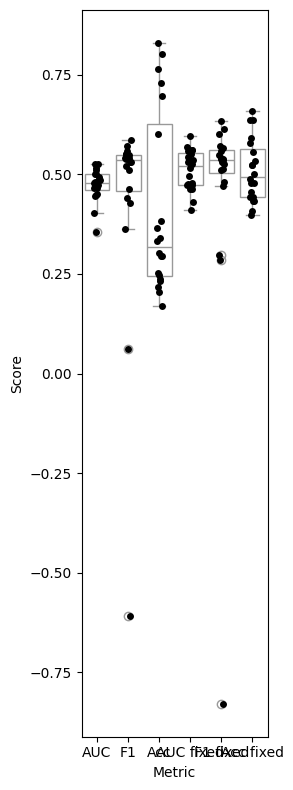

In [163]:
u30_tmi_nocte_df, u30_tmi_nocte_p, u30_tmi_nocte_model = run_kan_predict_both('tmi', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 5.63e-01 | test loss: 2.83e+00 | reg: 5.24e+01 : 100%|████| 3/3 [01:04<00:00, 21.37s/it]


0.5828571428571429 0.5885714285714284 0.46919431279620855
0.592948717948718 0.5425824175824177 0.5795454545454546
1 of 20


train loss: 5.41e-01 | test loss: 2.77e+00 | reg: 5.35e+01 : 100%|████| 3/3 [01:01<00:00, 20.63s/it]


0.4950793650793651 0.4651428571428571 0.5071090047393365
0.47275641025641024 0.4863523573200993 0.4772727272727273
2 of 20


train loss: 5.66e-01 | test loss: 2.38e+00 | reg: 5.14e+01 : 100%|████| 3/3 [01:02<00:00, 20.87s/it]


0.5612698412698413 0.5812244897959183 0.7298578199052133
0.6319444444444445 0.33241758241758224 0.6931818181818182
3 of 20


train loss: 5.44e-01 | test loss: 2.79e+00 | reg: 5.14e+01 : 100%|████| 3/3 [01:01<00:00, 20.58s/it]


0.45539682539682536 0.23885714285714277 0.8246445497630331
0.4722222222222222 -0.6318681318681323 0.625
4 of 20


train loss: 5.49e-01 | test loss: 2.85e+00 | reg: 5.29e+01 : 100%|████| 3/3 [01:01<00:00, 20.34s/it]


0.4912698412698413 0.11542857142857142 0.7962085308056872
0.5192307692307692 0.42751479289940836 0.5113636363636364
5 of 20


train loss: 5.20e-01 | test loss: 2.57e+00 | reg: 5.23e+01 : 100%|████| 3/3 [01:01<00:00, 20.64s/it]


0.46460317460317463 0.22857142857142845 0.7156398104265402
0.5405982905982907 0.4674556213017751 0.5454545454545454
6 of 20


train loss: 5.27e-01 | test loss: 2.85e+00 | reg: 5.18e+01 : 100%|████| 3/3 [01:02<00:00, 20.82s/it]


0.5923015873015873 0.5669172932330826 0.6208530805687204
0.6041666666666667 0.07692307692307673 0.6363636363636364
7 of 20


train loss: 6.07e-01 | test loss: 2.53e+00 | reg: 5.28e+01 : 100%|████| 3/3 [01:04<00:00, 21.39s/it]


0.5649206349206349 0.628131868131868 0.7772511848341233
0.547542735042735 0.1479289940828402 0.6363636363636364
8 of 20


train loss: 5.73e-01 | test loss: 2.71e+00 | reg: 5.02e+01 : 100%|████| 3/3 [01:03<00:00, 21.30s/it]


0.5612698412698413 0.573877551020408 0.5876777251184834
0.5908119658119658 0.5645161290322581 0.5568181818181818
9 of 20


train loss: 5.37e-01 | test loss: 2.84e+00 | reg: 5.19e+01 : 100%|████| 3/3 [01:00<00:00, 20.33s/it]


0.5285714285714286 0.5809523809523809 0.4786729857819905
0.5213675213675214 0.49408284023668625 0.5681818181818182
10 of 20


train loss: 5.97e-01 | test loss: 2.54e+00 | reg: 5.19e+01 : 100%|████| 3/3 [01:03<00:00, 21.30s/it]


0.49253968253968256 0.5276190476190477 0.41232227488151657
0.4807692307692307 0.4487179487179488 0.5113636363636364
11 of 20


train loss: 5.97e-01 | test loss: 2.41e+00 | reg: 5.24e+01 : 100%|████| 3/3 [01:01<00:00, 20.64s/it]


0.525 0.5583193277310923 0.3080568720379147
0.5176282051282052 0.5418552036199096 0.48863636363636365
12 of 20


train loss: 5.04e-01 | test loss: 2.66e+00 | reg: 5.14e+01 : 100%|████| 3/3 [01:02<00:00, 20.97s/it]


0.5687301587301588 0.6169458128078817 0.4881516587677725
0.5357905982905983 0.5106100795755968 0.5340909090909091
13 of 20


train loss: 5.66e-01 | test loss: 2.36e+00 | reg: 5.09e+01 : 100%|████| 3/3 [01:02<00:00, 20.94s/it]


0.45761904761904765 0.30938775510204075 0.7772511848341233
0.5101495726495726 -0.5824175824175825 0.6363636363636364
14 of 20


train loss: 5.96e-01 | test loss: 2.35e+00 | reg: 5.08e+01 : 100%|████| 3/3 [01:02<00:00, 20.86s/it]


0.6058730158730159 0.5995918367346939 0.4834123222748815
0.6308760683760685 0.5941644562334218 0.6136363636363636
15 of 20


train loss: 5.61e-01 | test loss: 2.63e+00 | reg: 5.21e+01 : 100%|████| 3/3 [01:03<00:00, 21.10s/it]


0.5766666666666667 0.5885714285714284 0.7914691943127962
0.5491452991452992 0.02447552447552445 0.6477272727272727
16 of 20


train loss: 5.74e-01 | test loss: 3.30e+00 | reg: 5.48e+01 : 100%|████| 3/3 [01:01<00:00, 20.60s/it]


0.5734126984126984 0.5599999999999998 0.6350710900473934
0.5785256410256411 0.30769230769230765 0.5909090909090909
17 of 20


train loss: 4.97e-01 | test loss: 2.93e+00 | reg: 5.53e+01 : 100%|████| 3/3 [01:03<00:00, 21.17s/it]


0.5912698412698413 0.5775510204081632 0.4549763033175355
0.6217948717948718 0.6091811414392059 0.6022727272727273
18 of 20


train loss: 5.33e-01 | test loss: 2.66e+00 | reg: 5.19e+01 : 100%|████| 3/3 [01:02<00:00, 20.82s/it]


0.5985714285714285 0.5885714285714284 0.7345971563981043
0.6159188034188035 0.22781065088757388 0.6704545454545454
19 of 20


train loss: 5.71e-01 | test loss: 2.19e+00 | reg: 5.06e+01 : 100%|████| 3/3 [01:03<00:00, 21.10s/it]


0.5414285714285715 0.523116883116883 0.5165876777251185
0.578525641025641 0.2153846153846153 0.6136363636363636
0.5414325396825397
0.5008674776183872
Statistics=29.0, p=0.0031528472900390625
Statistics=17.0, p=0.0003948211669921875


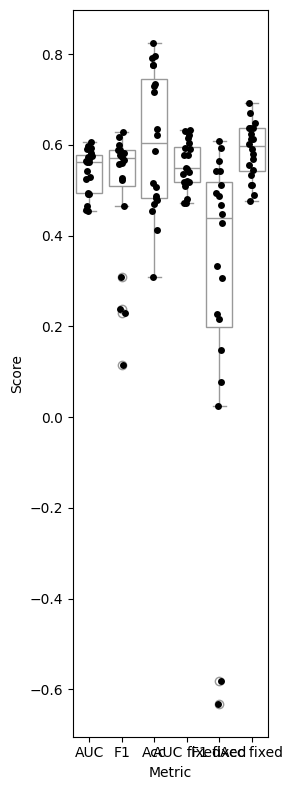

In [164]:
u30_aes_nocte_df, u30_aes_nocte_p, u30_aes_nocte_model = run_kan_predict_both('aes', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)

0 of 20


train loss: 5.42e-01 | test loss: 2.48e+00 | reg: 5.11e+01 : 100%|████| 3/3 [01:01<00:00, 20.48s/it]


0.601948051948052 0.6579545454545456 0.5924170616113744
0.6506738544474393 0.6962264150943396 0.7386363636363636
1 of 20


train loss: 5.91e-01 | test loss: 2.09e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:02<00:00, 20.89s/it]


0.5794642857142858 0.6179724880382775 0.6540284360189573
0.6088948787061994 0.46127110228401197 0.6477272727272727
2 of 20


train loss: 5.60e-01 | test loss: 2.17e+00 | reg: 4.86e+01 : 100%|████| 3/3 [01:04<00:00, 21.34s/it]


0.5644480519480519 0.5435175619834711 0.5213270142180095
0.6398921832884097 0.5693191140278917 0.6590909090909091
3 of 20


train loss: 5.86e-01 | test loss: 2.19e+00 | reg: 4.77e+01 : 100%|████| 3/3 [01:04<00:00, 21.44s/it]


0.6324675324675325 0.6954900568181818 0.7677725118483413
0.6231805929919138 0.42216981132075476 0.6818181818181818
4 of 20


train loss: 5.96e-01 | test loss: 2.34e+00 | reg: 5.09e+01 : 100%|████| 3/3 [01:05<00:00, 21.69s/it]


0.5969155844155845 0.6420454545454546 0.6587677725118484
0.6097035040431267 0.47864945382323737 0.6590909090909091
5 of 20


train loss: 5.61e-01 | test loss: 2.24e+00 | reg: 5.02e+01 : 100%|████| 3/3 [01:01<00:00, 20.62s/it]


0.5793831168831169 0.569128787878788 0.7535545023696683
0.5827493261455525 0.1470125786163522 0.6477272727272727
6 of 20


train loss: 6.60e-01 | test loss: 1.86e+00 | reg: 4.72e+01 : 100%|████| 3/3 [01:01<00:00, 20.66s/it]


0.5701298701298702 0.580657114624506 0.5402843601895735
0.5946091644204852 0.4975389663658737 0.6022727272727273
7 of 20


train loss: 6.36e-01 | test loss: 1.89e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:05<00:00, 21.68s/it]


0.6124999999999999 0.6133207070707071 0.5023696682464455
0.6188679245283017 0.559748427672956 0.5909090909090909
8 of 20


train loss: 6.00e-01 | test loss: 2.08e+00 | reg: 4.74e+01 : 100%|████| 3/3 [01:06<00:00, 22.19s/it]


0.5305194805194805 0.5830278592375367 0.38388625592417064
0.5568733153638815 0.5518867924528301 0.5681818181818182
9 of 20


train loss: 5.49e-01 | test loss: 2.04e+00 | reg: 4.99e+01 : 100%|████| 3/3 [01:02<00:00, 20.85s/it]


0.6292207792207792 0.6183101173020529 0.43601895734597157
0.6226415094339622 0.5846013390139988 0.5568181818181818
10 of 20


train loss: 5.59e-01 | test loss: 2.12e+00 | reg: 5.05e+01 : 100%|████| 3/3 [01:01<00:00, 20.63s/it]


0.5827922077922078 0.5869755244755246 0.7440758293838863
0.6 0.5797598627787308 0.5227272727272727
11 of 20


train loss: 5.73e-01 | test loss: 2.28e+00 | reg: 4.95e+01 : 100%|████| 3/3 [01:01<00:00, 20.38s/it]


0.5969155844155845 0.6259469696969698 0.6255924170616114
0.5929919137466307 0.4654088050314467 0.6136363636363636
12 of 20


train loss: 5.53e-01 | test loss: 2.29e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:03<00:00, 21.06s/it]


0.598051948051948 0.6203512396694216 0.6018957345971564
0.5827493261455525 0.45969125214408246 0.5909090909090909
13 of 20


train loss: 4.94e-01 | test loss: 2.45e+00 | reg: 5.10e+01 : 100%|████| 3/3 [01:01<00:00, 20.62s/it]


0.6293831168831169 0.6561316287878789 0.6066350710900474
0.6512129380053909 0.5872641509433963 0.6590909090909091
14 of 20


train loss: 5.63e-01 | test loss: 2.43e+00 | reg: 4.82e+01 : 100%|████| 3/3 [01:03<00:00, 21.05s/it]


0.5521103896103896 0.5558712121212122 0.6824644549763034
0.6 0.339622641509434 0.6590909090909091
15 of 20


train loss: 5.70e-01 | test loss: 2.10e+00 | reg: 4.96e+01 : 100%|████| 3/3 [01:01<00:00, 20.63s/it]


0.557224025974026 0.6105587121212123 0.7772511848341233
0.5924528301886792 0.2020440251572328 0.6704545454545454
16 of 20


train loss: 5.42e-01 | test loss: 2.59e+00 | reg: 5.12e+01 : 100%|████| 3/3 [01:05<00:00, 21.76s/it]


0.5655032467532468 0.5890151515151516 0.41232227488151657
0.5194070080862534 0.5047169811320754 0.5227272727272727
17 of 20


train loss: 5.81e-01 | test loss: 2.32e+00 | reg: 4.89e+01 : 100%|████| 3/3 [01:03<00:00, 21.09s/it]


0.5787337662337663 0.637784090909091 0.7582938388625592
0.630188679245283 0.4129979035639414 0.6363636363636364
18 of 20


train loss: 6.40e-01 | test loss: 1.85e+00 | reg: 4.73e+01 : 100%|████| 3/3 [01:04<00:00, 21.56s/it]


0.5863636363636364 0.6195652173913044 0.5829383886255924
0.6145552560646901 0.5262510254306809 0.625
19 of 20


train loss: 5.64e-01 | test loss: 2.10e+00 | reg: 4.87e+01 : 100%|████| 3/3 [01:02<00:00, 20.87s/it]


0.613961038961039 0.6229876893939394 0.5687203791469194
0.6210242587601078 0.5262510254306809 0.625
0.5879017857142856
0.6123306064517614
Statistics=0.0, p=1.9073486328125e-06
Statistics=0.0, p=1.9073486328125e-06


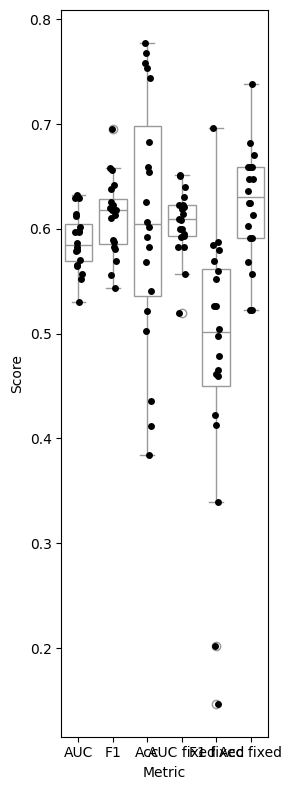

In [165]:
u30_gds_nocte_df, u30_gds_nocte_p, u30_gds_nocte_model = run_kan_predict_both('gds', 'no_cte', width=[100, 16, 4], steps=3, max_k=20)

In [183]:
out_string = 'out_data = {'
for test in ['bis', 'bri', 'tmi', 'gds', 'aes', 'suicide']: 
    string = f'\'{test}\':{{\'df\': u30_{test}_nocte_df.to_numpy(), \'p\': u30_{test}_nocte_p, \'model\': u30_{test}_nocte_model.cpu().state_dict()}},' 
    if test == '': 
        string = string.replace('u30__', 'u30_')
        string = string.replace('\'\':', '\'cte\':')
    out_string += '\n' + '    ' + string 
out_string += '\n}'
print(out_string)

out_data = {
    'bis':{'df': u30_bis_nocte_df.to_numpy(), 'p': u30_bis_nocte_p, 'model': u30_bis_nocte_model.cpu().state_dict()},
    'bri':{'df': u30_bri_nocte_df.to_numpy(), 'p': u30_bri_nocte_p, 'model': u30_bri_nocte_model.cpu().state_dict()},
    'tmi':{'df': u30_tmi_nocte_df.to_numpy(), 'p': u30_tmi_nocte_p, 'model': u30_tmi_nocte_model.cpu().state_dict()},
    'gds':{'df': u30_gds_nocte_df.to_numpy(), 'p': u30_gds_nocte_p, 'model': u30_gds_nocte_model.cpu().state_dict()},
    'aes':{'df': u30_aes_nocte_df.to_numpy(), 'p': u30_aes_nocte_p, 'model': u30_aes_nocte_model.cpu().state_dict()},
    'suicide':{'df': u30_suicide_nocte_df.to_numpy(), 'p': u30_suicide_nocte_p, 'model': u30_suicide_nocte_model.cpu().state_dict()},
}


In [188]:
out_data = {
    'bis':{'df': u30_bis_nocte_df.to_numpy(), 'p': u30_bis_nocte_p, 'model': u30_bis_nocte_model.cpu().state_dict()},
    'bri':{'df': u30_bri_nocte_df.to_numpy(), 'p': u30_bri_nocte_p, 'model': u30_bri_nocte_model.cpu().state_dict()},
    'tmi':{'df': u30_tmi_nocte_df.to_numpy(), 'p': u30_tmi_nocte_p, 'model': u30_tmi_nocte_model.cpu().state_dict()},
    'gds':{'df': u30_gds_nocte_df.to_numpy(), 'p': u30_gds_nocte_p, 'model': u30_gds_nocte_model.cpu().state_dict()},
    'aes':{'df': u30_aes_nocte_df.to_numpy(), 'p': u30_aes_nocte_p, 'model': u30_aes_nocte_model.cpu().state_dict()},
    'suicide':{'df': u30_suicide_nocte_df.to_numpy(), 'p': u30_suicide_nocte_p, 'model': u30_suicide_nocte_model.cpu().state_dict()},
}
joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/nocte_kan_results.pkl')

In [82]:
out_data = joblib.load('/sc/arion/projects/tauomics/danielk/hemosiderin/MLPtrainer/kan_outputs/nocte_kan_results.pkl')

In [84]:
names = ['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide']
cols = ['k', 'AUC', 'F1', 'Acc', 'AUC all', 'F1 all', 'Acc all']
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=cols) for name in names}

double_p_value_dict = {name:{'AUC': getP(dfs[name], c='AUC'), 'ACC': getP(dfs[name], c='Acc', expected_val = getExpectedVal(name))} for name in names}
for name in names: 
    print(name, np.mean(dfs[name]['AUC']), np.mean(dfs[name]['Acc']), double_p_value_dict[name])

gds 0.6056334231805929 0.6238636363636363 {'AUC': 1.9073486328125e-06, 'ACC': 0.13272666931152344}
aes 0.5556356837606838 0.5869318181818182 {'AUC': 0.0003948211669921875, 'ACC': 0.012079238891601562}
bis 0.5536458333333334 0.5482954545454546 {'AUC': 0.009435653686523438, 'ACC': 4.76837158203125e-05}
bri 0.5368194070080863 0.5670454545454545 {'AUC': 0.023950576782226562, 'ACC': 0.0001049041748046875}
tmi 0.5106305803571428 0.5096590909090909 {'AUC': 0.3117942810058594, 'ACC': 1.9073486328125e-06}
suicide 0.7420579029733959 0.7292134831460674 {'AUC': 1.9073486328125e-06, 'ACC': 3.62396240234375e-05}


In [184]:
for test in ['bis', 'bri', 'tmi', 'gds', 'aes', 'suicide']: 
    string = f'u30_{test}_nocte_model.save_ckpt(\'nocte_{test}_model\')' 
    print(string)

u30_bis_nocte_model.save_ckpt('u30_bis_model')
u30_bri_nocte_model.save_ckpt('u30_bri_model')
u30_tmi_nocte_model.save_ckpt('u30_tmi_model')
u30_gds_nocte_model.save_ckpt('u30_gds_model')
u30_aes_nocte_model.save_ckpt('u30_aes_model')
u30_suicide_nocte_model.save_ckpt('u30_suicide_model')


In [167]:
u30_bis_nocte_model.save_ckpt('nocte_bis_model')
u30_bri_nocte_model.save_ckpt('nocte_bri_model')
u30_tmi_nocte_model.save_ckpt('nocte_tmi_model')
u30_gds_nocte_model.save_ckpt('nocte_gds_model')
u30_aes_nocte_model.save_ckpt('nocte_aes_model')
u30_suicide_nocte_model.save_ckpt('nocte_suicide_model')

save this model to ./model_ckpt/nocte_bis_model
save this model to ./model_ckpt/nocte_bri_model
save this model to ./model_ckpt/nocte_tmi_model
save this model to ./model_ckpt/nocte_gds_model
save this model to ./model_ckpt/nocte_aes_model
save this model to ./model_ckpt/nocte_suicide_model


In [172]:
names

['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide', 'cte']

In [177]:
def getExpectedVal(label): 
    labels, counts = np.unique(rhi[rhi['cte']==0][label], return_counts=True)
    return np.max(counts/np.sum(counts))

/tmp/ipykernel_123200/2199896204.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


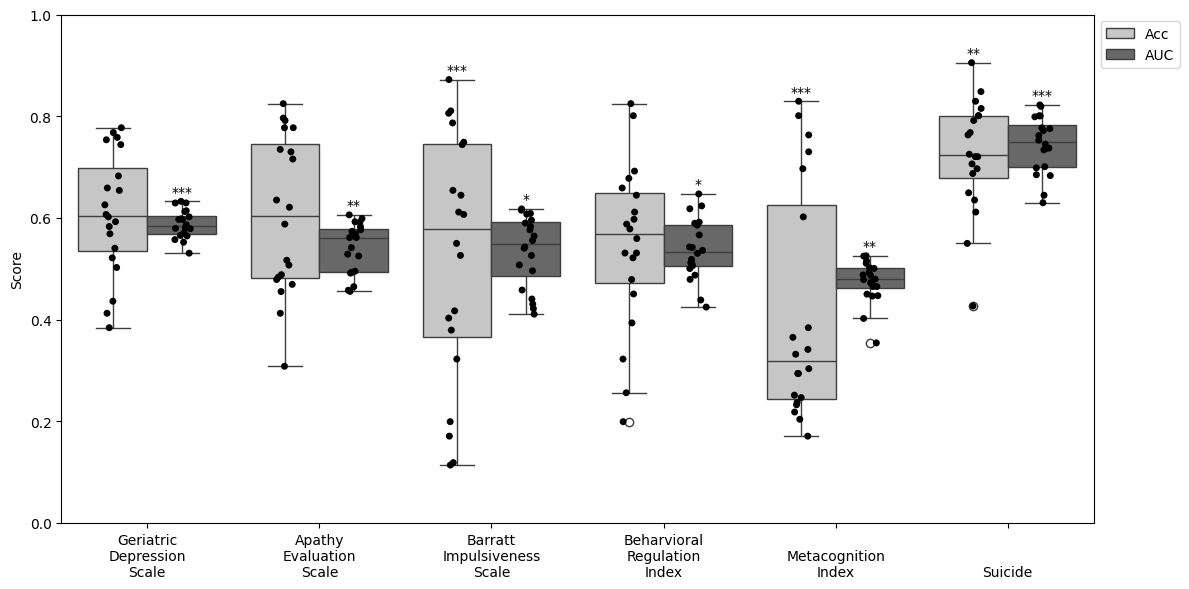

In [178]:
names = ['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide']
cols = ['k', 'AUC fixed', 'F1 fixed', 'Acc fixed', 'AUC', 'F1', 'Acc']
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=cols) for name in names}
data_frames = [dfs[name] for name in names]
double_p_value_dict = {name:{'AUC': getP(dfs[name], c='AUC'), 'ACC': getP(dfs[name], c='Acc', expected_val = getExpectedVal(name))} for name in names}
xlabel_dict = {'bri': 'Beharvioral\nRegulation\nIndex', 
               'aes': 'Apathy\nEvaluation\nScale', 
               'gds': 'Geriatric\nDepression\nScale', 
               'bis': 'Barratt\nImpulsiveness\nScale', 
               'tmi': '\nMetacognition\nIndex', 
               'suicide': '\n\nSuicide', 
               'cte': '\n\nCTE'}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['Acc', 'AUC'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    ps = double_p_value_dict[name]
    pauc = ps['AUC']
    pacc = ps['ACC']
    position = ticks[i] - 0.2
    if p is not None:
        ax.text(position + 0.4, max(melted_data[(melted_data['Metric'] == 'AUC') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(pauc), ha='center', va='bottom')
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'Acc') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(pacc), ha='center', va='bottom')
# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('')
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_123200/1560384003.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


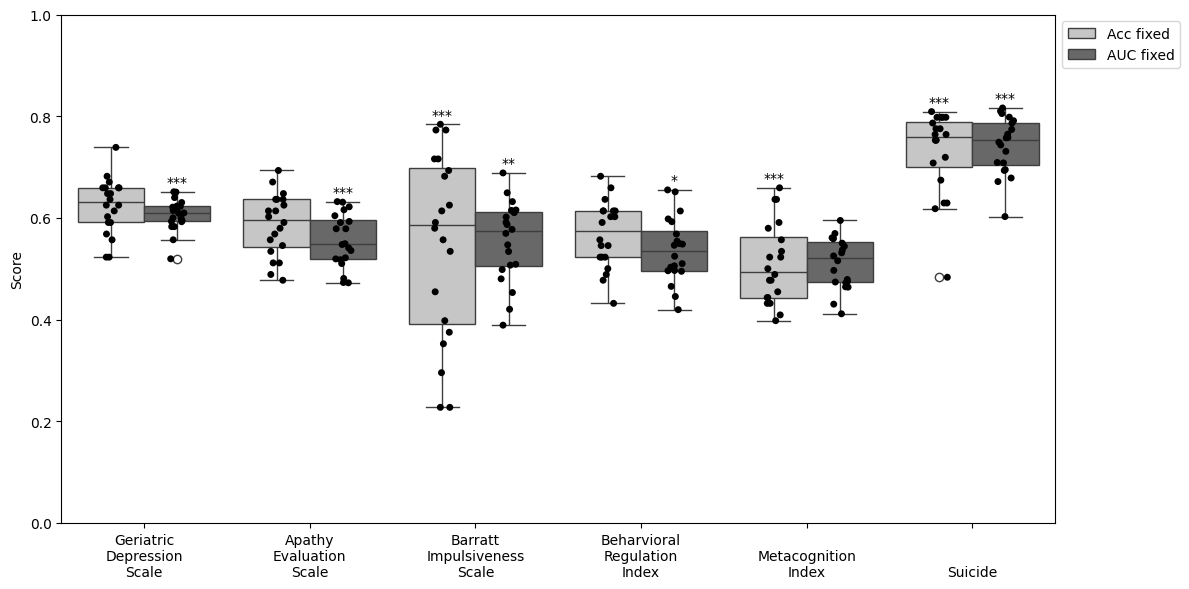

In [179]:
names = ['gds', 'aes', 'bis', 'bri', 'tmi', 'suicide']
cols = ['k', 'AUC fixed', 'F1 fixed', 'Acc fixed', 'AUC', 'F1', 'Acc']
dfs = {name: pd.DataFrame(out_data[name]['df'], columns=cols) for name in names}
data_frames = [dfs[name] for name in names]
double_p_value_dict = {name:{'AUC': getP(dfs[name], c='AUC fixed'), 'ACC': getP(dfs[name], c='Acc fixed', expected_val = getExpectedVal(name))} for name in names}
xlabel_dict = {'bri': 'Beharvioral\nRegulation\nIndex', 
               'aes': 'Apathy\nEvaluation\nScale', 
               'gds': 'Geriatric\nDepression\nScale', 
               'bis': 'Barratt\nImpulsiveness\nScale', 
               'tmi': '\nMetacognition\nIndex', 
               'suicide': '\n\nSuicide', 
               'cte': '\n\nCTE'}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['Acc fixed', 'AUC fixed'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    ps = double_p_value_dict[name]
    pauc = ps['AUC']
    pacc = ps['ACC']
    position = ticks[i] - 0.2
    if p is not None:
        ax.text(position + 0.4, max(melted_data[(melted_data['Metric'] == 'AUC fixed') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(pauc), ha='center', va='bottom')
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'Acc fixed') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(pacc), ha='center', va='bottom')
# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('')
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [198]:
def getClamResults(path, kmax=20): 
    models_paths = f'/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/CLAM/results/{path}' 

    out_df = []
    for k in range(kmax): 
        splits_pd = pd.read_csv(join(models_paths, f'splits_{k}.csv'))
        test_slides = np.vectorize(lambda x: x.replace('.0', '').replace('.svs', ''))(splits_pd['test'].dropna().to_numpy().astype(str))
        results = joblib.load(join(models_paths, f'split_{k}_results.pkl'))

        probs = [results[s + '.svs']['prob'] for s in test_slides]
        ls = [results[s + '.svs']['label'] for s in test_slides]

        probs = np.array(probs).squeeze(1)[:,1]

        auc, f1, acc = get_stats(ls, probs)

        out_df.append(
                {
                    'k': k, 
                    'AUC': auc, 
                    'F1': f1
                }
            )


    out_df = pd.DataFrame(out_df)
    print(np.mean(out_df['AUC']))
    print(np.mean(out_df['F1']))
    stat, p_value = wilcoxon(out_df['AUC'] - 0.5)
    print(f'Statistics={stat}, p={p_value}')

    melted_df = pd.melt(out_df, id_vars=['k'], value_vars=['AUC', 'F1'], var_name='Metric', value_name='Score')

    fig, ax = plt.subplots(1, 1, figsize=(3, 8))
    sns.boxplot(data=melted_df, x='Metric', y='Score', color='white')
    sns.stripplot(melted_df, y='Score', x='Metric', color='black')
    plt.tight_layout()
    plt.show()
    return out_df, p_value  

0.9272727272727274
0.9203899572649574
Statistics=0.0, p=1.9073486328125e-06


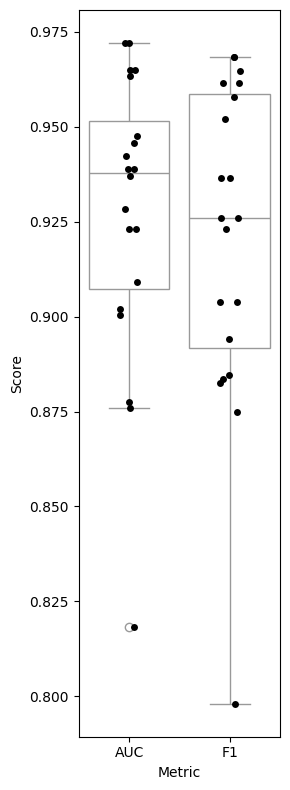

In [199]:
clam_suicide_df, clam_suicide_p = getClamResults('dino_rhi_lhe_suicide_100_s1')

In [200]:
dem_df, dem_p, dem_lr = run_logistic_regression('dementia')

NameError: name 'run_logistic_regression' is not defined

100%|███████████████████████████████████████████████████████████████████████| 20/20 [08:34<00:00, 25.75s/it]

0.5915072765072764
0.6295268916290655
Statistics=0.0, p=1.9073486328125e-06


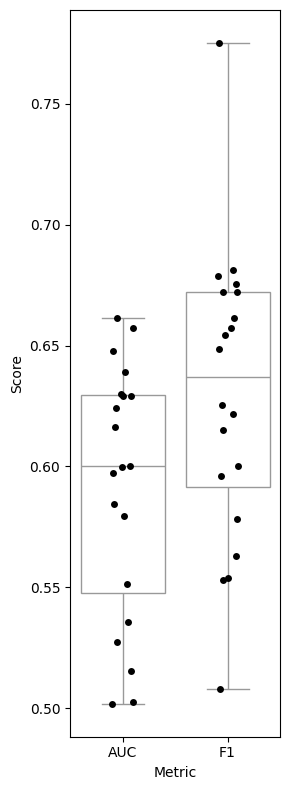

cluster  mean odds ratio  std devs odds ratio
0        1            0.937                0.753
1        2            1.061                2.745
2        3            1.093                0.064
3        4            0.847                1.184
4        5            1.009                1.604

In [83]:
dem_nocte_df, dem_nocte_p, dem_nocte_lr = run_logistic_regression('dementia_nocte')

0.8269581982542059
0.6929974909342826
Statistics=0.0, p=1.9073486328125e-06


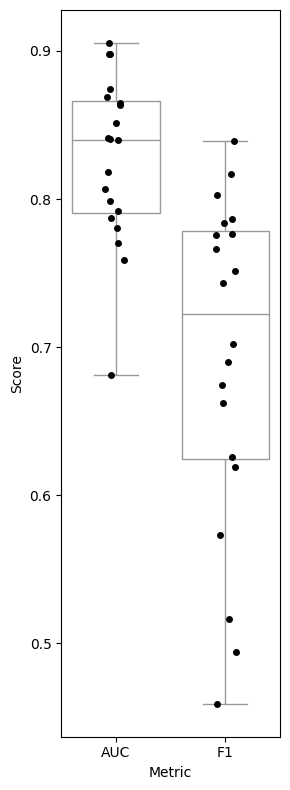

In [201]:
clam_dementia_df, clam_dementia_p = getClamResults('dino_rhi_lhe_dementiahx_100_s1')

0.5485358282820995
-0.26020639054642863
Statistics=26.0, p=0.0019855499267578125


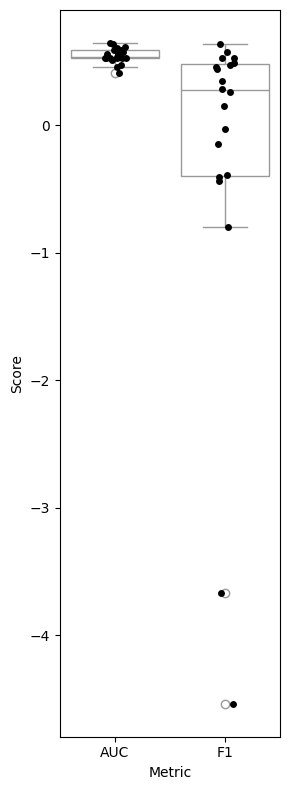

In [202]:
clam_dementia_df, clam_dementia_p = getClamResults('dino_rhi_lhe_cte_100_s1')

0.5202991452991454
-5.970058489897201
Statistics=22.0, p=0.625


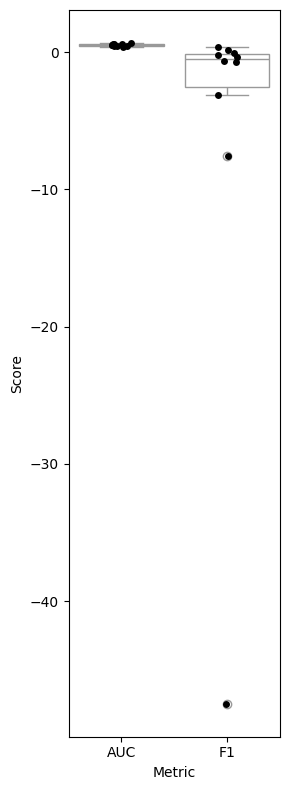

0.5892307692307692
0.4310897435897435
Statistics=4.0, p=0.013671875


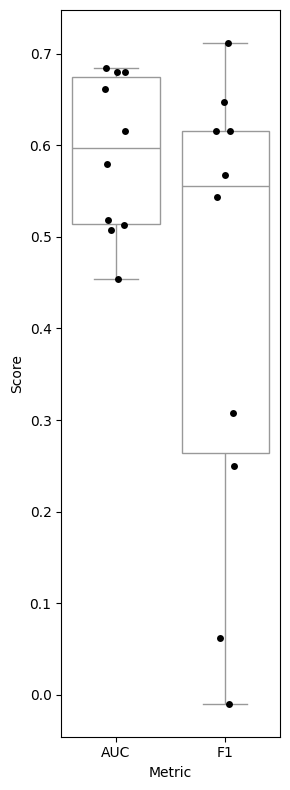

0.5628787878787879
-1.2680623311611714
Statistics=12.0, p=0.130859375


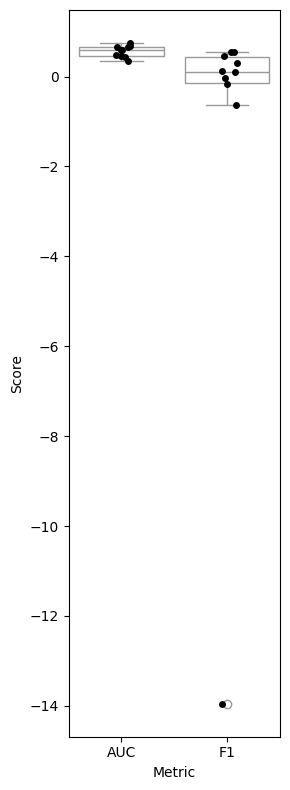

0.5051515151515151
-3.4330644714407503
Statistics=21.0, p=0.8589549227374824


/sc/arion/work/koenid03/conda/envs/GPUClone/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/sc/arion/work/koenid03/conda/envs/GPUClone/lib/python3.10/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


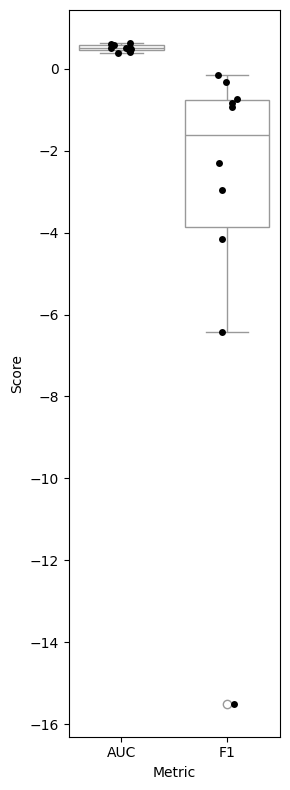

0.6553240740740741
-1.1321952530228394
Statistics=3.0, p=0.009765625


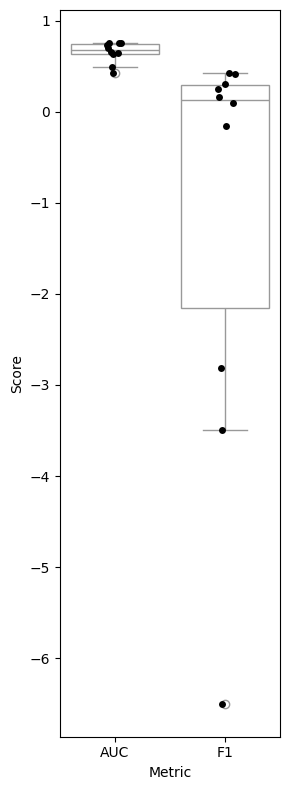

In [51]:
clam_bri_df, clam_bri_p = getClamResults('dino_rhi_lhe_tbri_100_s1', kmax=10)
clam_bis_df, clam_bis_p = getClamResults('dino_rhi_lhe_bis_100_s1', kmax=10)
clam_aes_df, clam_aes_p = getClamResults('dino_rhi_lhe_aes_100_s1', kmax=10)
clam_gds_df, clam_gds_p = getClamResults('dino_rhi_lhe_gds_100_s1', kmax=10)
clam_mi_df, clam_mi_p = getClamResults('dino_rhi_lhe_tmi_100_s1', kmax=10)

0.5476495726495727
-2.690323623744677
Statistics=11.0, p=0.10546875


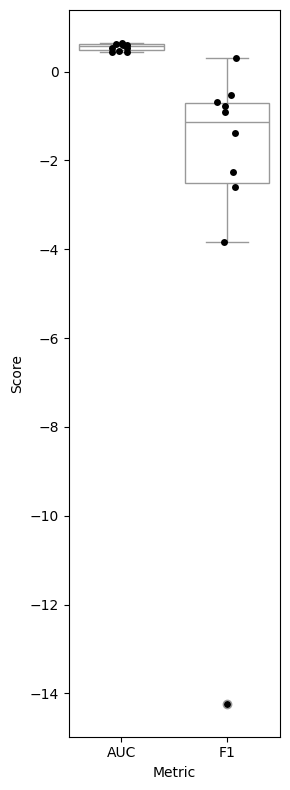

0.5889743589743591
0.5730301749532518
Statistics=10.0, p=0.083984375


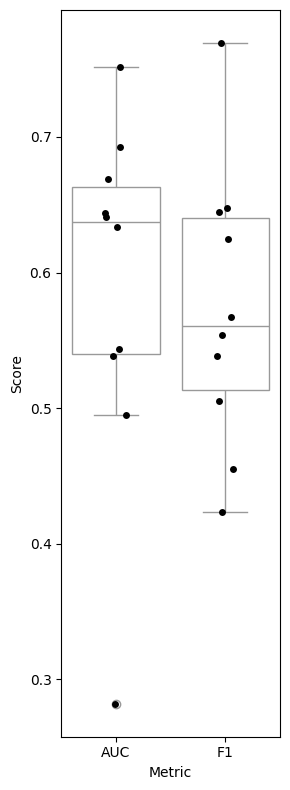

0.6113636363636366
0.04544043328056789
Statistics=3.0, p=0.009765625


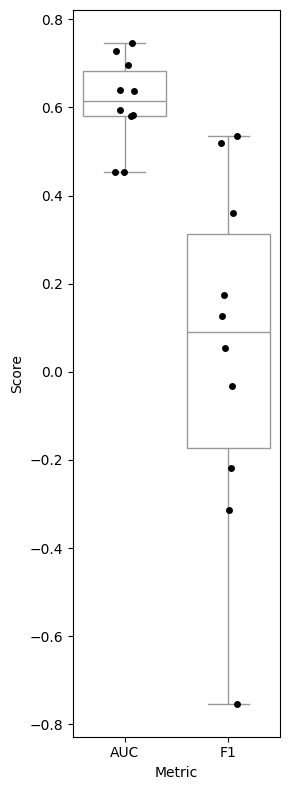

0.5633333333333335
-1.7428285327288815
Statistics=4.0, p=0.013671875


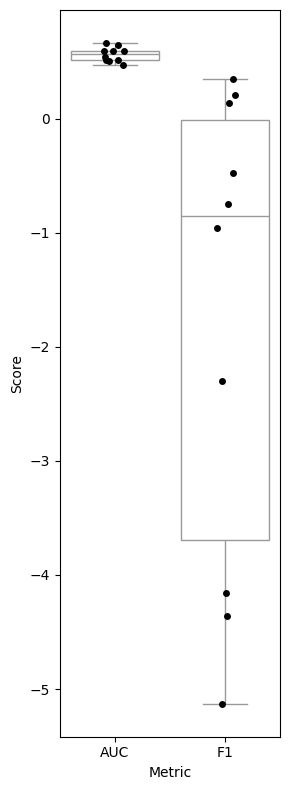

0.6099537037037037
0.0023735165959457684
Statistics=4.0, p=0.013671875


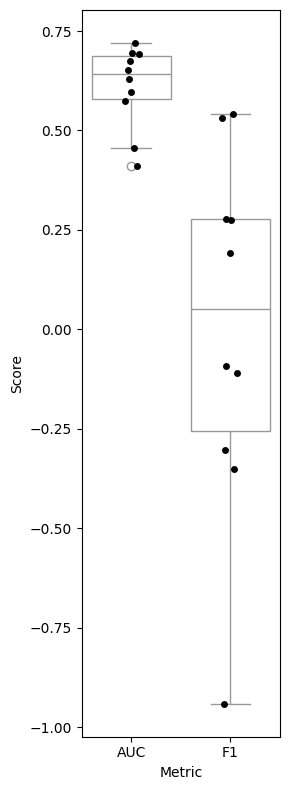

In [52]:
no_prior_clam_bri_df, no_prior_clam_bri_p = getClamResults('dino_rhi_lhe_tbri_no_prior_100_s1', kmax=10)
no_prior_clam_bis_df, no_prior_clam_bis_p = getClamResults('dino_rhi_lhe_bis_no_prior_100_s1', kmax=10)
no_prior_clam_aes_df, no_prior_clam_aes_p = getClamResults('dino_rhi_lhe_aes_no_prior_100_s1', kmax=10)
no_prior_clam_gds_df, no_prior_clam_gds_p = getClamResults('dino_rhi_lhe_gds_no_prior_100_s1', kmax=10)
no_prior_clam_mi_df, no_prior_clam_mi_p = getClamResults('dino_rhi_lhe_tmi_no_prior_100_s1', kmax=10)

100%|███████████████████████████████████████████████████████████████████████| 20/20 [10:58<00:00, 32.94s/it]

0.5415280857354029
0.028510050507293473
Statistics=0.0, p=0.0001318338889828333



/sc/arion/work/koenid03/conda/envs/GPUClone/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


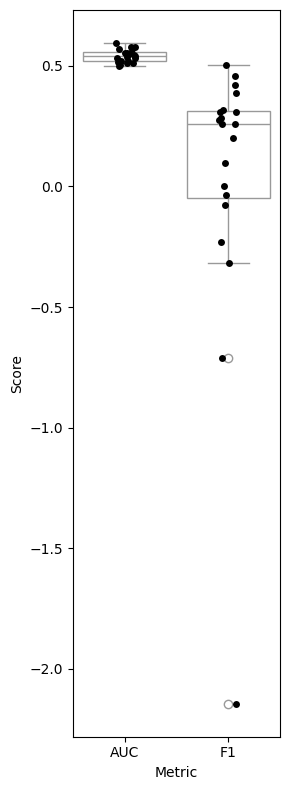

cluster  mean odds ratio  std devs odds ratio
0        1            0.952                0.946
1        2            1.217                0.061
2        3            0.884               11.483
3        4            1.172                0.051
4        5            0.909                2.644

In [109]:
cte_df, cte_p, cte_lr = run_logistic_regression('cte')

0.5485358282820995
-0.2602063905464285
Statistics=26.0, p=0.0019855499267578125


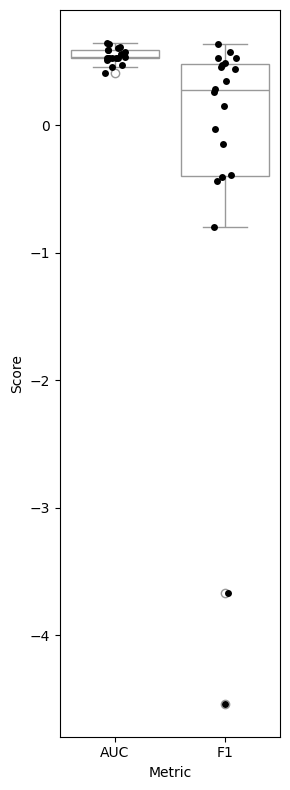

In [108]:
clam_cte_df, clam_cte_p = getClamResults('dino_rhi_lhe_cte_100_s1', kmax=20)

/tmp/ipykernel_14008/4039252981.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])


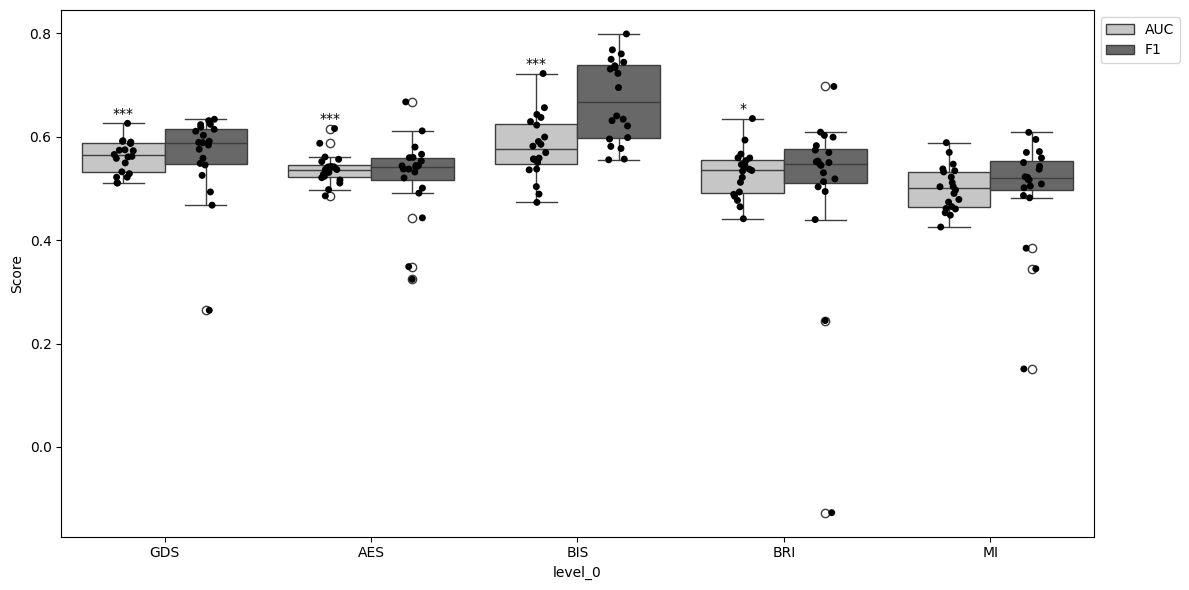

In [84]:
data_frames = [gds_nocte_df, aes_nocte_df, bis_nocte_df, bri_nocte_df, mi_nocte_df]
names = ['gds', 'aes', 'bis', 'bri', 'mi']
pvalue_dict = {'bri': bri_nocte_p, 'aes': aes_nocte_p, 'gds': gds_nocte_p, 'bis': bis_nocte_p, 'mi': mi_nocte_p}
xlabel_dict = {'bri': 'BRI', 'aes': 'AES', 'gds': 'GDS', 'bis': 'BIS', 'mi': 'MI'}

# Combine all DataFrames
all_data = pd.concat(data_frames, keys=names)

# Melt the DataFrame for easier plotting
melted_data = pd.melt(all_data.reset_index(level=0), id_vars=['level_0', 'k'], value_vars=['AUC', 'F1'], var_name='Metric', value_name='Score')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.boxplot(data=melted_data, x='level_0', y='Score', hue='Metric', ax=ax, palette='Grays', legend=True)
sns.stripplot(data=melted_data, x='level_0', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False)

ticks = ax.get_xticks()

# Adding asterisks based on p-values
for i, name in enumerate(names):
    p = pvalue_dict.get(name)
    position = ticks[i] - 0.2
    if p is not None:
        ax.text(position, max(melted_data[(melted_data['Metric'] == 'AUC') & (melted_data['level_0'] == name)]['Score']) + 0.005, p_value_to_asterisks(p), ha='center', va='bottom')

# Customize x labels
ax.set_xticklabels([xlabel_dict.get(n, n) for n in names])

# Adjust legend and show plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

/tmp/ipykernel_14008/3443665970.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


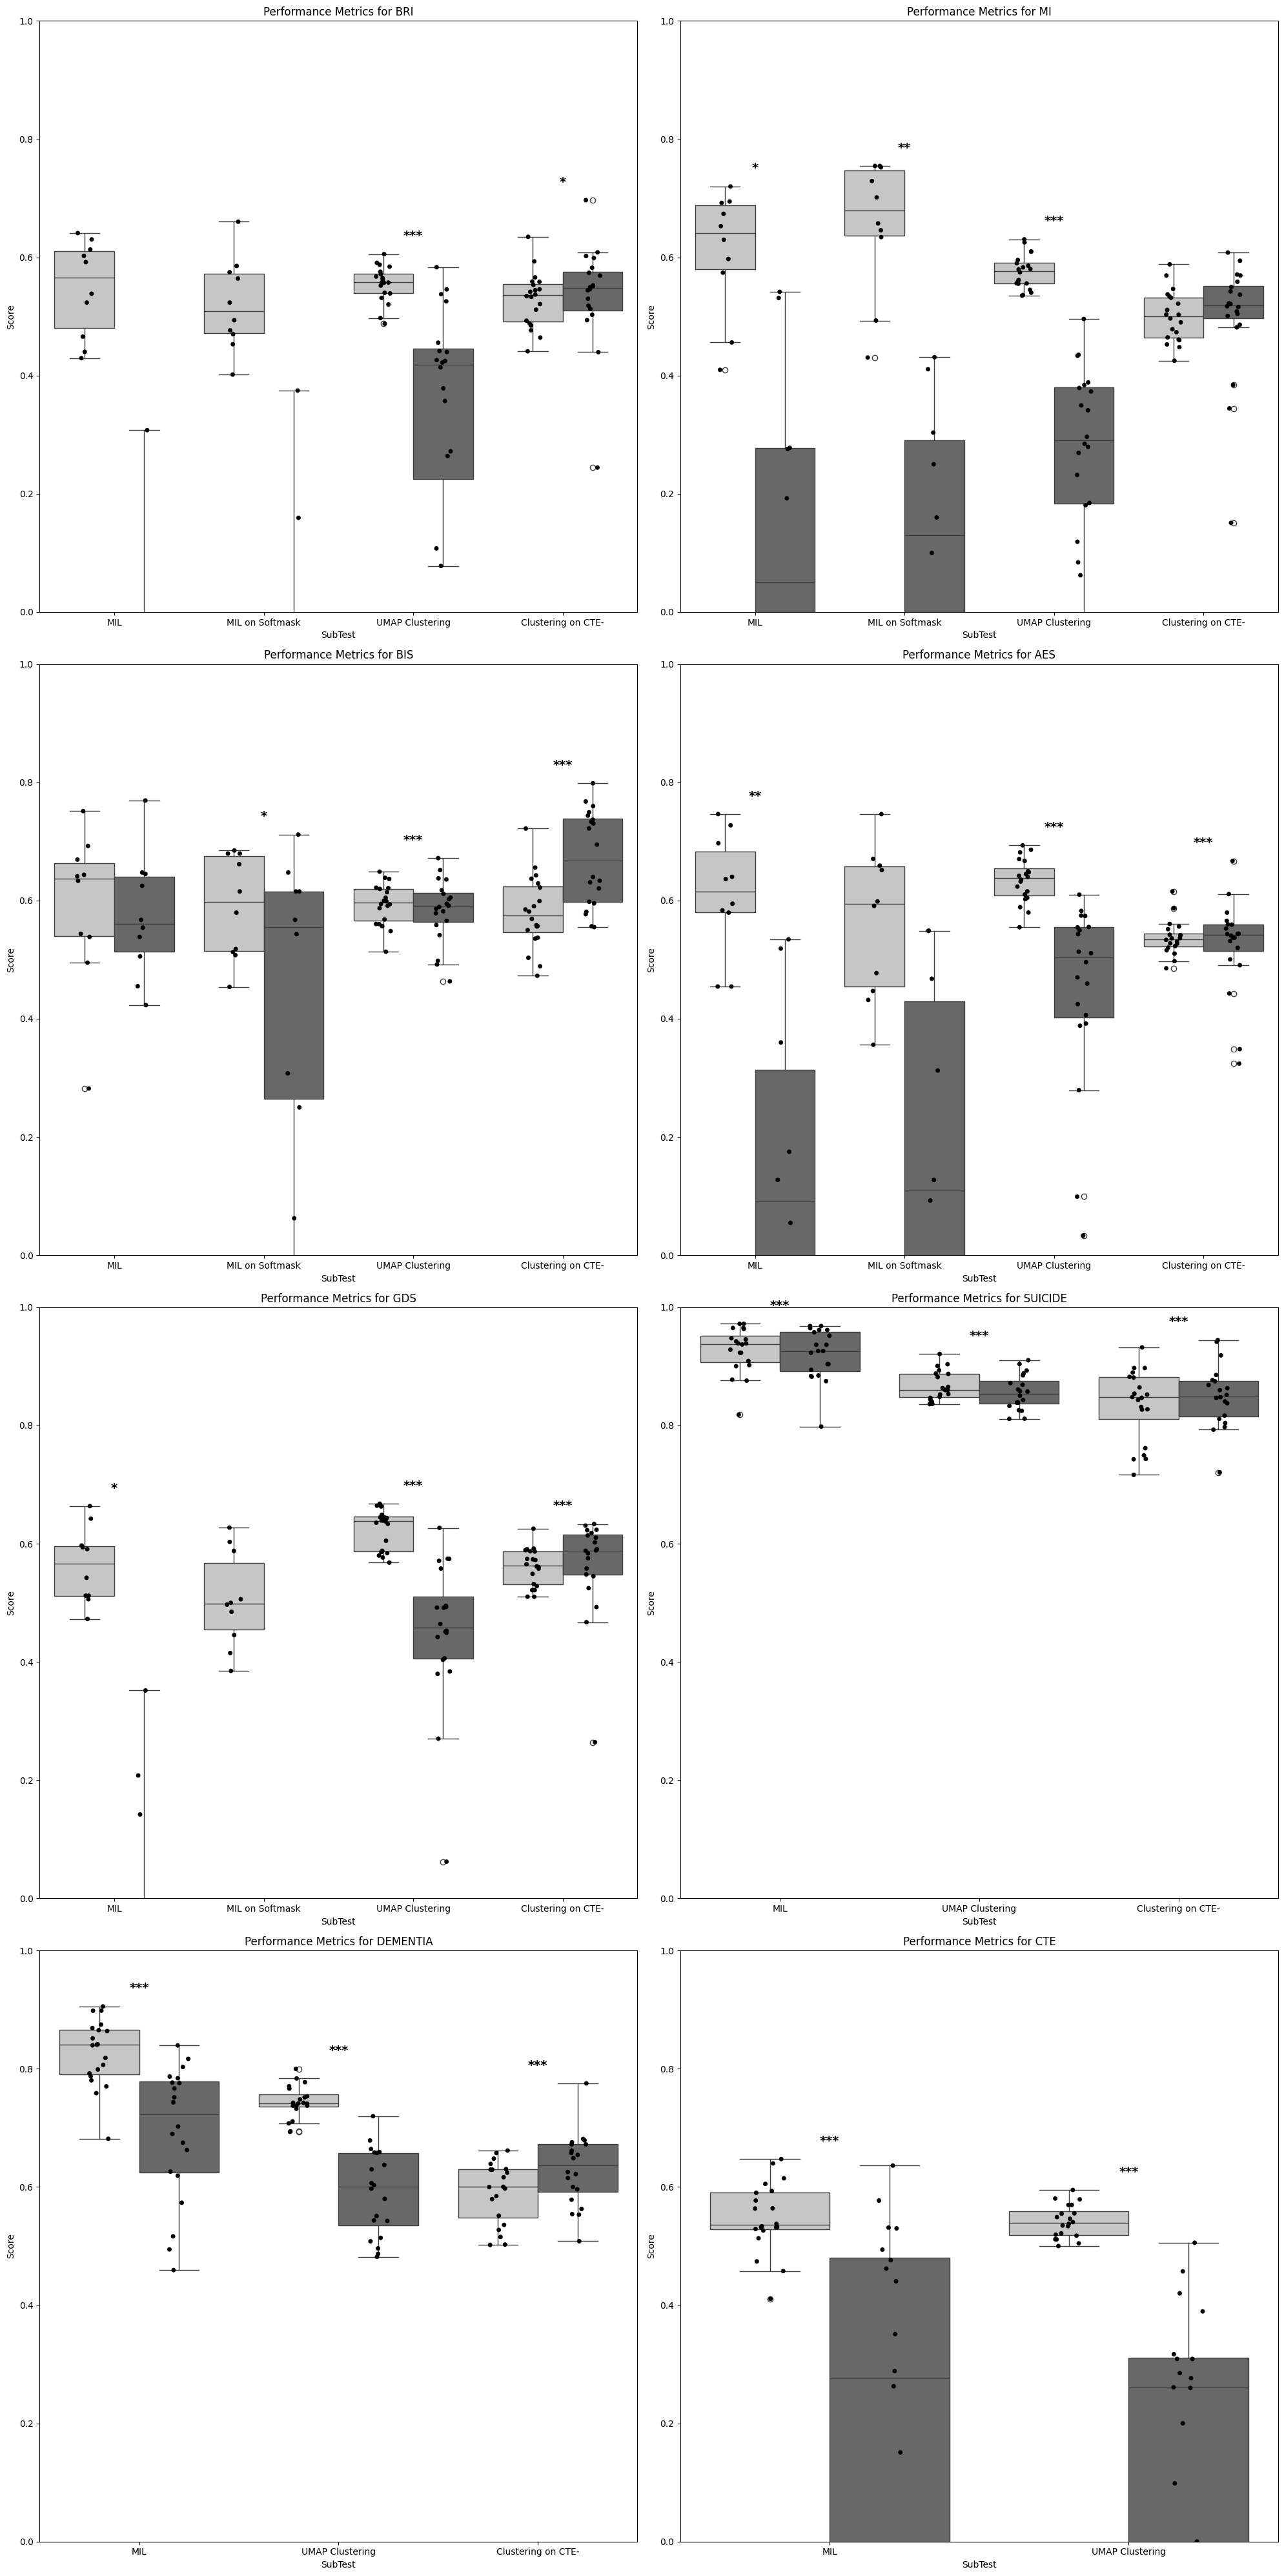

In [134]:
data_frames_dict = {
    'bri': [bri_df, bri_nocte_df, clam_bri_df, no_prior_clam_bri_df],
    'mi': [mi_df, mi_nocte_df, clam_mi_df, no_prior_clam_mi_df],
    'bis': [bis_df, bis_nocte_df, clam_bis_df, no_prior_clam_bis_df],
    'aes': [aes_df, aes_nocte_df, clam_aes_df, no_prior_clam_aes_df],
    'gds': [gds_df, gds_nocte_df, clam_gds_df, no_prior_clam_gds_df], 
    'suicide': [suicide_df, suicide_nocte_df, clam_suicide_df],
    'dementia': [dem_df, dem_nocte_df, clam_dementia_df],
    'cte': [cte_df, clam_cte_df],
}

pvalue_dict = {
    'bri': [bri_p, bri_nocte_p, clam_bri_p, no_prior_clam_bri_p],
    'mi': [mi_p, mi_nocte_p, clam_mi_p, no_prior_clam_mi_p],
    'bis': [bis_p, bis_nocte_p, clam_bis_p, no_prior_clam_bis_p],
    'aes': [aes_p, aes_nocte_p, clam_aes_p, no_prior_clam_aes_p],
    'gds': [gds_p, gds_nocte_p, clam_gds_p, no_prior_clam_gds_p], 
    'suicide': [suicide_p, suicide_nocte_p, clam_suicide_p], 
    'dementia': [dem_p, dem_nocte_p, clam_dementia_p], 
    'cte': [dem_p, clam_dementia_p], 
}

# Custom subtest names and their order
subtest_names = {
    'bis': ['UMAP Clustering', 'Clustering on CTE-', 'MIL on Softmask', 'MIL'],
    'bri': ['UMAP Clustering', 'Clustering on CTE-', 'MIL on Softmask', 'MIL'],
    'aes': ['UMAP Clustering', 'Clustering on CTE-', 'MIL on Softmask', 'MIL'],
    'gds': ['UMAP Clustering', 'Clustering on CTE-', 'MIL on Softmask', 'MIL'],
    'mi': ['UMAP Clustering', 'Clustering on CTE-', 'MIL on Softmask', 'MIL'], 
    'suicide': ['UMAP Clustering', 'Clustering on CTE-', 'MIL'],
    'dementia': ['UMAP Clustering', 'Clustering on CTE-', 'MIL'],
    'cte': ['UMAP Clustering', 'MIL'],
}

# Order for the subtests
subtest_order = ['MIL', 'MIL on Softmask', 'UMAP Clustering', 'Clustering on CTE-']

all_data_list = []
for test, dfs in data_frames_dict.items():
    for i, df in enumerate(dfs):
        df['Test'] = test
        df['SubTest'] = subtest_names[test][i]
        all_data_list.append(df)

all_data = pd.concat(all_data_list)

melted_data = pd.melt(all_data, id_vars=['Test', 'SubTest', 'k'], value_vars=['AUC', 'F1'], var_name='Metric', value_name='Score')

# Create a grid of plots
num_tests = len(data_frames_dict)
fig, axes = plt.subplots(nrows=(num_tests + 1) // 2, ncols=2, figsize=(20, 40), constrained_layout=True)

for ax, test in zip(axes.flatten(), data_frames_dict.keys()):
    test_data = melted_data[melted_data['Test'] == test]
    
    # Determine the correct subtest order and p-values for this test
    if test in ['suicide', 'dementia']:
        subtest_order_test = ['MIL', 'UMAP Clustering', 'Clustering on CTE-']
        p_values_reordered = np.array(pvalue_dict[test])[np.array([2, 0, 1])]
    elif test in ['cte']: 
        subtest_order_test = ['MIL', 'UMAP Clustering']
        p_values_reordered = np.array(pvalue_dict[test])[np.array([1, 0])]
    else:
        subtest_order_test = subtest_order
        p_values_reordered = np.array(pvalue_dict[test])[np.array([3, 2, 0, 1])]
    
    sns.boxplot(data=test_data, x='SubTest', y='Score', hue='Metric', ax=ax, palette='Grays', dodge=True, order=subtest_order_test)
    sns.stripplot(data=test_data, x='SubTest', y='Score', hue='Metric', dodge=True, palette=['black', 'black'], ax=ax, legend=False, order=subtest_order_test)
    ax.get_legend().remove()
    
    # Adding asterisks based on p-values
    for i, (subtest, p) in enumerate(zip(subtest_order_test, p_values_reordered)):
        if p is not None:
            y_max = max(test_data[(test_data['Metric'] == 'AUC') & (test_data['SubTest'] == subtest)]['Score'].max(),
                        test_data[(test_data['Metric'] == 'F1') & (test_data['SubTest'] == subtest)]['Score'].max())
            ax.text(i, y_max + 0.02, p_value_to_asterisks(p), ha='center', va='bottom', fontsize=14, fontweight='bold')

    # Set custom x labels and ticks
    ax.set_xticks(range(len(subtest_order_test)))
    ax.set_xticklabels([xlabel for xlabel in subtest_order_test])

    # Set y-axis limits to 0-1
    ax.set_ylim(0, 1)

    # Set title
    ax.set_title(f'Performance Metrics for {test.upper()}')

# Remove empty subplots
for i in range(num_tests, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()

In [113]:
melted_data.to_pickle('/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/JupyterNotebooks/ParkmanRHI/UMAP/VesselsExtractUMAPwHDBSCAN_out_data.pkl')

In [114]:
joblib.dump(data_frames_dict, '/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/JupyterNotebooks/ParkmanRHI/UMAP/VesselsExtractUMAPwHDBSCAN_out_dfs.pkl') 
joblib.dump(pvalue_dict, '/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/JupyterNotebooks/ParkmanRHI/UMAP/VesselsExtractUMAPwHDBSCAN_out_ps.pkl') 

['/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/JupyterNotebooks/ParkmanRHI/UMAP/VesselsExtractUMAPwHDBSCAN_out_ps.pkl']

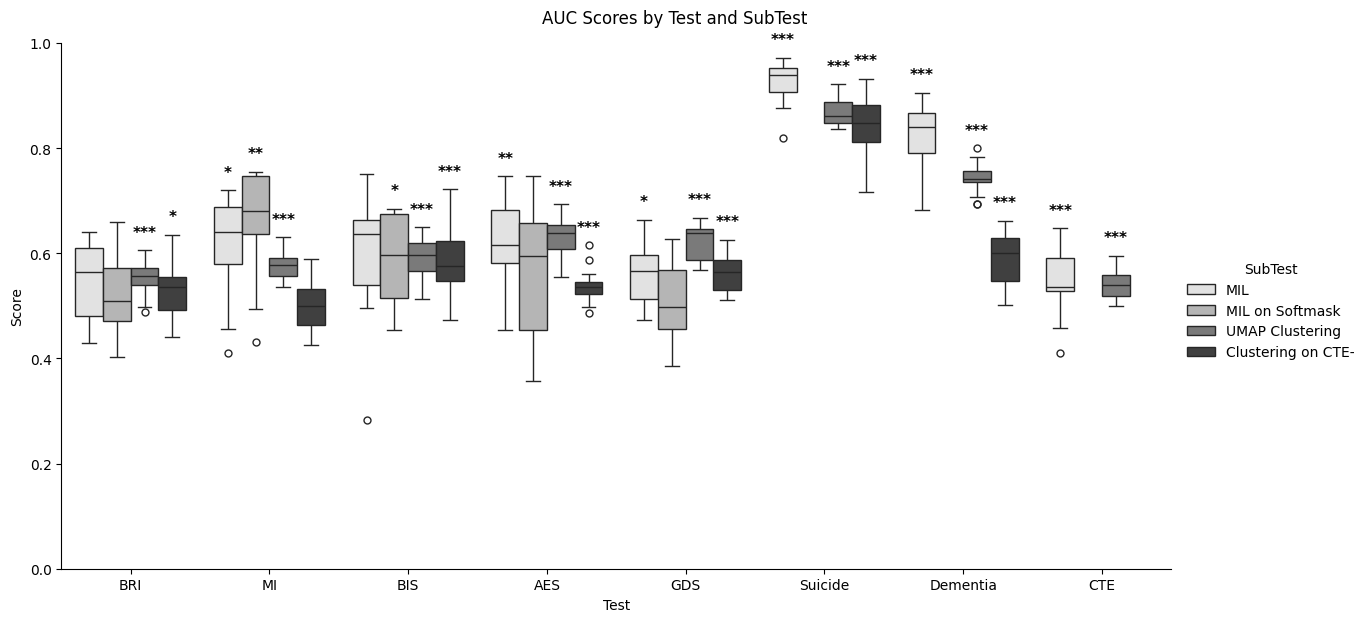

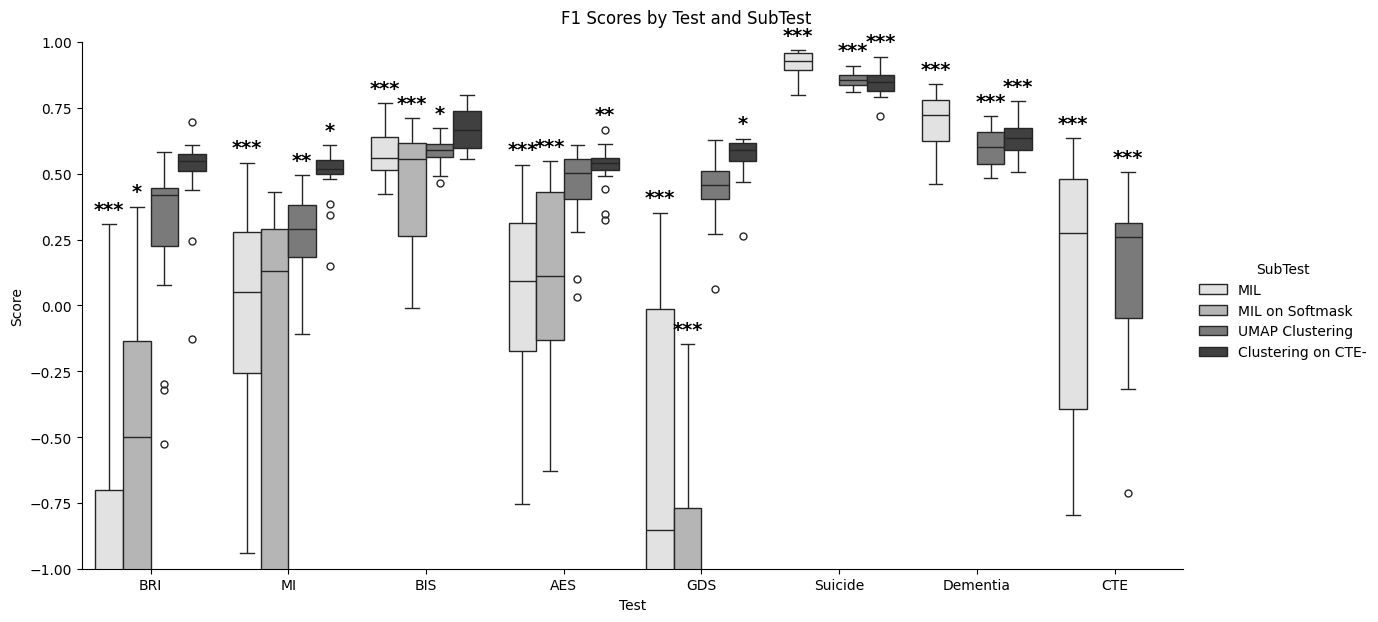

In [179]:
# Separate data for AUC and F1

test_pretty_names = {
    'bri': 'BRI',
    'mi': 'MI',
    'bis': 'BIS',
    'aes': 'AES',
    'gds': 'GDS',
    'suicide': 'Suicide', 
    'dementia': 'Dementia', 
    'cte': 'CTE'
}

sub_melted_data = melted_data.copy()
sub_melted_data['Test'] = sub_melted_data['Test'].map(test_pretty_names)

auc_data = sub_melted_data[sub_melted_data['Metric'] == 'AUC']
f1_data = sub_melted_data[sub_melted_data['Metric'] == 'F1']


# Create the AUC plot
g_auc = sns.catplot(
    data=auc_data,
    x='Test', y='Score', hue='SubTest',
    kind='box', palette='Grays',
    height=6, aspect=2, hue_order=subtest_order
)
g_auc.set(ylim=(0, 1))
g_auc.fig.suptitle('AUC Scores by Test and SubTest', y=1.03)

offsets = [-.3, -.1, .1, .3]

# Adding asterisks based on p-values for AUC
for test, p_values in pvalue_dict.items():
    pretty_test = test_pretty_names[test]
     # Determine the correct subtest order and p-values for this test
    if test in ['suicide', 'dementia']:
        subtest_order_test = ['MIL', 'UMAP Clustering', 'Clustering on CTE-']
        p_values_reordered = np.array(pvalue_dict[test])[np.array([2, 0, 1])]
    elif test in ['cte']: 
        subtest_order_test = ['MIL', 'UMAP Clustering']
        p_values_reordered = np.array(pvalue_dict[test])[np.array([1, 0])]
    else:
        subtest_order_test = subtest_order
        p_values_reordered = np.array(pvalue_dict[test])[np.array([3, 2, 0, 1])]
    for i, p in enumerate(p_values_reordered):
        subtest = subtest_order_test[i]
        if p is not None and 'AUC' in auc_data['Metric'].unique():
            y_max = auc_data[(auc_data['Test'] == pretty_test) & (auc_data['SubTest'] == subtest)]['Score'].max()
            ax = g_auc.ax
            # Find the position of the subtest within the current test group
            positions = ax.get_xticks()
            j = subtest_order.index(subtest)
            offset = offsets[j]
            for pos, label in zip(positions, ax.get_xticklabels()):
                if label.get_text() == pretty_test:
                    ax.text(pos + offset, y_max + 0.02, p_value_to_asterisks(p), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Create the F1 plot
g_f1 = sns.catplot(
    data=f1_data,
    x='Test', y='Score', hue='SubTest',
    kind='box', palette='Grays',
    height=6, aspect=2, hue_order=subtest_order
)
g_f1.set(ylim=(-1, 1))
g_f1.fig.suptitle('F1 Scores by Test and SubTest', y=1.03)

# Adding asterisks based on p-values for F1
for test, p_values in pvalue_dict.items():
    pretty_test = test_pretty_names[test]
    if test in ['suicide', 'dementia']:
        subtest_order_test = ['MIL', 'UMAP Clustering', 'Clustering on CTE-']
        p_values_reordered = np.array(pvalue_dict[test])[np.array([2, 0, 1])]
    elif test in ['cte']: 
        subtest_order_test = ['MIL', 'UMAP Clustering']
        p_values_reordered = np.array(pvalue_dict[test])[np.array([1, 0])]
    else:
        subtest_order_test = subtest_order
        p_values_reordered = np.array(pvalue_dict[test])[np.array([3, 2, 0, 1])]
    for i, p in enumerate(p_values):
        subtest = subtest_order_test[i]
        if p is not None and 'F1' in f1_data['Metric'].unique():
            y_max = f1_data[(f1_data['Test'] == pretty_test) & (f1_data['SubTest'] == subtest)]['Score'].max()
            ax = g_f1.ax
            # Find the position of the subtest within the current test group
            positions = ax.get_xticks()
            j = subtest_order.index(subtest)
            offset = offsets[j]
            for pos, label in zip(positions, ax.get_xticklabels()):
                if label.get_text() == pretty_test:
                    ax.text(pos + offset, y_max + 0.02, p_value_to_asterisks(p), ha='center', va='bottom', fontsize=14, fontweight='bold')

# Show the plots
plt.show()

0.7836990595611285
0.8003598795840177
Statistics=0.0, p=0.001953125


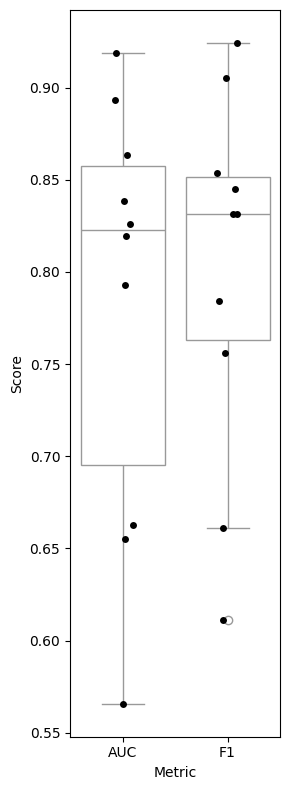

In [203]:
clam_ycte_nop_df, clam_ycte_nop_p = getClamResults('dino_rhi_lhe_youngcte_no_prior_100_s1', kmax=10)

0.792319749216301
0.8109291187739464
Statistics=0.0, p=0.001953125


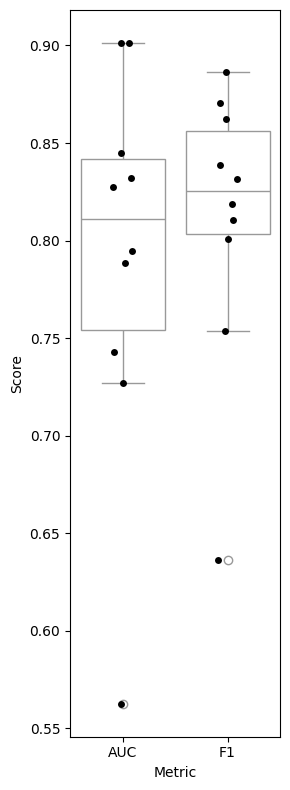

In [27]:
clam_ycte_nop_df, clam_ycte_nop_p = getClamResults('dino_rhi_lhe_youngcte_100_s1', kmax=10)

In [31]:
rhi['under_30_cte'].dropna()

10     1.0
36     0.0
38     1.0
39     1.0
53     1.0
      ... 
691    0.0
697    0.0
703    0.0
709    1.0
711    1.0
Name: under_30_cte, Length: 119, dtype: float64

100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.75s/it]

0.593840579710145
0.49525174101261066
Statistics=15.0, p=0.0002613067626953125


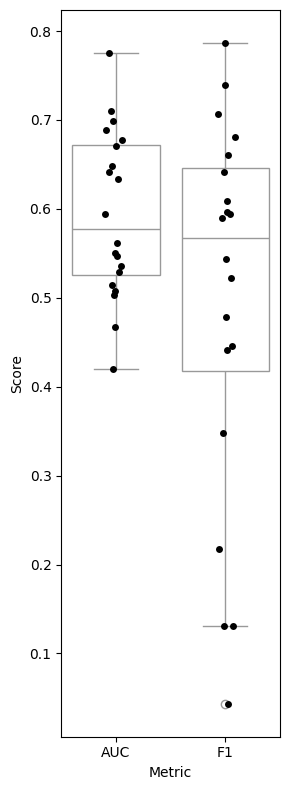

cluster  mean odds ratio  std devs odds ratio
0        1            1.047                3.506
1        2            0.890                0.036
2        3            0.982                8.961
3        4            1.018                1.361
4        5            0.932                0.101

In [32]:
u30cte_df, u30cte_p, u30cte_lr = run_logistic_regression('under_30_cte')

In [35]:
def under_30_bis(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['BIS']

rhi['under_30_bis'] = rhi.apply(under_30_bis, axis=1)
u30bis_df, u30bis_p, u30bis_lr = run_logistic_regression('under_30_bis')

In [37]:
for test in ['mi', 'bri', 'aes', 'gds']: print(f"""def under_30_{test}(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['{test.upper()}']

rhi['under_30_{test}'] = rhi.apply(under_30_{test}, axis=1)
u30{test}_df, u30{test}_p, u30{test}_lr = run_logistic_regression('under_30_{test}')""")

def under_30_mi(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['MI']

rhi['under_30_mi'] = rhi.apply(under_30_mi, axis=1)
u30mi_df, u30mi_p, u30mi_lr = run_logistic_regression('under_30_mi')
def under_30_bri(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['BRI']

rhi['under_30_bri'] = rhi.apply(under_30_bri, axis=1)
u30bri_df, u30bri_p, u30bri_lr = run_logistic_regression('under_30_bri')
def under_30_aes(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['AES']

rhi['under_30_aes'] = rhi.apply(under_30_aes, axis=1)
u30aes_df, u30aes_p, u30aes_lr = run_logistic_regression('under_30_aes')
def under_30_gds(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['GDS']

rhi['under_30_gds'] = rhi.apply(under_30_gds, axis=1)
u30gds_df, u30gds_p, u30gds_lr = run_logistic_regression('under_30_gds')


 30%|█████████████████████▌                                                  | 6/20 [00:22<00:53,  3.83s/it]/tmp/ipykernel_63728/2800883218.py:892: RuntimeWarning: divide by zero encountered in scalar divide
  return (x - pi) / ((1 - pi) * x)
100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.75s/it]

0.492824074074074
-inf
Statistics=101.0, p=0.8983173370361328


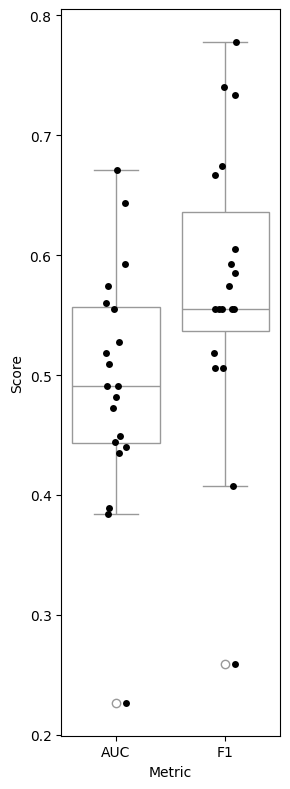

cluster  mean odds ratio  std devs odds ratio
0        1            0.959                0.539
1        2            0.915                0.882
2        3            1.004                4.403
3        4            1.055                0.724
4        5            1.064                0.780

In [36]:
u30bis_df, u30bis_p, u30bis_lr = run_logistic_regression('under_30_bis')

In [40]:
rhi.columns

Index(['subjid', 'Slide_ID', 'Scanner and magnification', 'aestot',
       'OtherContactSport', 'fafe', 'highlev', 'footyrs', 'poshigh', 'hockyrs',
       'socyrs', 'wresyrs', 'boxyrs', 'bryrs', 'divyrs', 'karyrs', 'lacyrs',
       'maryrs', 'mmayrs', 'pwresyrs', 'rugyrs', 'eqyrs', 'ssyrs', 'fhyrs',
       'bistot', 'tbri', 'tmi', 'tgec', 'maxaggsum', 'CDStot', 'gender',
       'race', 'edlevel', 'cod', 'DementiaHx', 'GDStot', 'agedeath', 'CTE',
       'CTEStage', 'nodata', 'cte', 'old', 'Brief TBRI', 'Brief TMI', 'AES',
       'GDS', 'BIS', 'under_30_cte', 'over_30', 'suicide', 'dementia',
       'suicide_nocte', 'dementia_nocte', 'under_30_bis'],
      dtype='object')

100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]

0.5092
0.44844841269841274
Statistics=88.0, p=0.5458755493164062


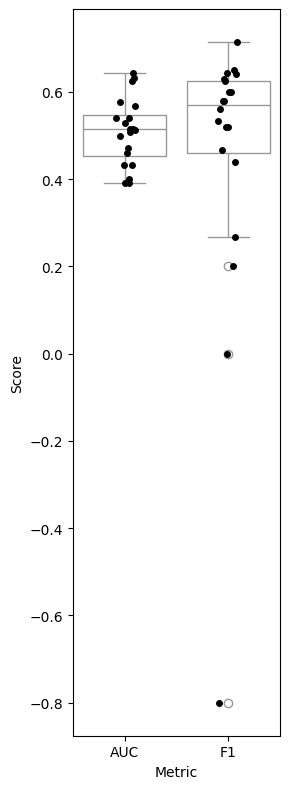

cluster  mean odds ratio  std devs odds ratio
0        1            0.992                0.561
1        2            1.050                0.543
2        3            1.021                1.755
3        4            0.958                1.126
4        5            0.993                0.644

KeyError: 'Brift TBRI'

In [41]:
def under_30_mi(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['Brief TMI']

rhi['under_30_mi'] = rhi.apply(under_30_mi, axis=1)
u30mi_df, u30mi_p, u30mi_lr = run_logistic_regression('under_30_mi')

100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.65s/it]
/sc/arion/work/koenid03/conda/envs/GPUClone/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


0.5299242424242425
0.5474586640211639
Statistics=57.0, p=0.12617579010550847


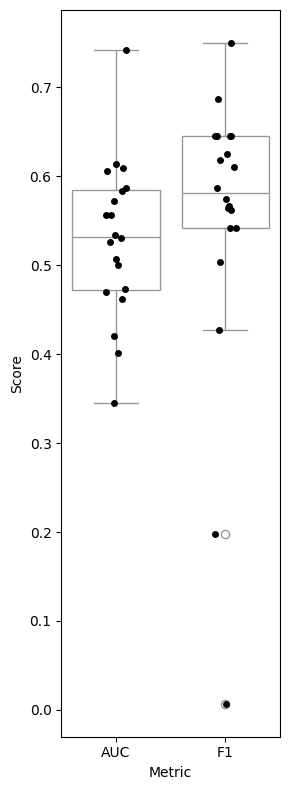

cluster  mean odds ratio  std devs odds ratio
0        1            0.966                3.931
1        2            1.072                0.410
2        3            1.023                1.104
3        4            1.023                1.989
4        5            1.028                0.131

In [42]:
def under_30_bri(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['Brief TBRI']

rhi['under_30_bri'] = rhi.apply(under_30_bri, axis=1)
u30bri_df, u30bri_p, u30bri_lr = run_logistic_regression('under_30_bri')

100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.81s/it]

0.6176136363636364
0.6068721064814814
Statistics=3.0, p=9.5367431640625e-06


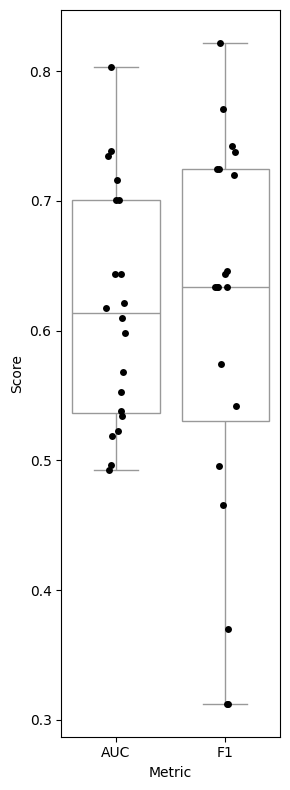

cluster  mean odds ratio  std devs odds ratio
0        1            0.983                0.087
1        2            1.077                1.447
2        3            0.962                6.921
3        4            0.996                8.347
4        5            1.080                3.658

In [43]:
def under_30_aes(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['AES']

rhi['under_30_aes'] = rhi.apply(under_30_aes, axis=1)
u30aes_df, u30aes_p, u30aes_lr = run_logistic_regression('under_30_aes')

100%|███████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.80s/it]

0.5985507246376811
0.5871663843402974
Statistics=3.0, p=9.5367431640625e-06


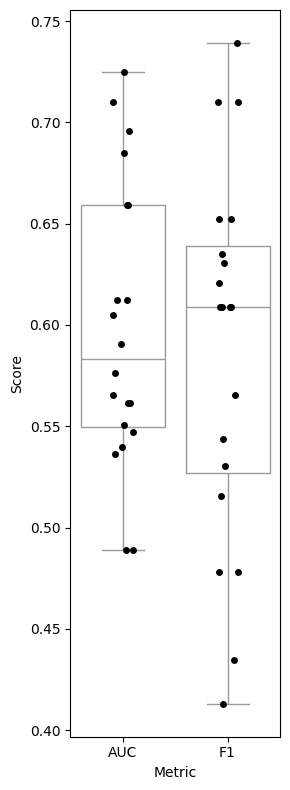

cluster  mean odds ratio  std devs odds ratio
0        1            1.008                0.151
1        2            1.060                1.848
2        3            0.961                9.484
3        4            0.964                6.949
4        5            1.208                1.783

In [44]:
def under_30_gds(row): 
    if row['agedeath'] > 30: 
        return np.nan 
    else: 
        return row['GDS']

rhi['under_30_gds'] = rhi.apply(under_30_gds, axis=1)
u30gds_df, u30gds_p, u30gds_lr = run_logistic_regression('under_30_gds')

In [47]:
np.unique(rhi['under_30_gds'], return_counts=True)

(array([ 0.,  1., nan]), array([ 80,  39, 593]))

In [57]:
for test in ['cte', 'bis', 'bri', 'mi', 'gds', 'aes']: print(f'\'{test}\':{{\'df\': u30{test}_df.to_numpy(), \'p\': u30{test}_p, \'lr\': u30{test}_lr}},')

'cte':{'df': u30cte_df.to_numpy(), 'p': u30cte_p, 'lr': u30cte_lr},
'bis':{'df': u30bis_df.to_numpy(), 'p': u30bis_p, 'lr': u30bis_lr},
'bri':{'df': u30bri_df.to_numpy(), 'p': u30bri_p, 'lr': u30bri_lr},
'mi':{'df': u30mi_df.to_numpy(), 'p': u30mi_p, 'lr': u30mi_lr},
'gds':{'df': u30gds_df.to_numpy(), 'p': u30gds_p, 'lr': u30gds_lr},
'aes':{'df': u30aes_df.to_numpy(), 'p': u30aes_p, 'lr': u30aes_lr},


In [58]:
out_data = {
    'cte':{'df': u30cte_df.to_numpy(), 'p': u30cte_p, 'lr': u30cte_lr},
    'bis':{'df': u30bis_df.to_numpy(), 'p': u30bis_p, 'lr': u30bis_lr},
    'bri':{'df': u30bri_df.to_numpy(), 'p': u30bri_p, 'lr': u30bri_lr},
    'mi':{'df': u30mi_df.to_numpy(), 'p': u30mi_p, 'lr': u30mi_lr},
    'gds':{'df': u30gds_df.to_numpy(), 'p': u30gds_p, 'lr': u30gds_lr},
    'aes':{'df': u30aes_df.to_numpy(), 'p': u30aes_p, 'lr': u30aes_lr}
}
joblib.dump(out_data, '/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/JupyterNotebooks/ParkmanRHI/UMAP/VesselsExtractUMAPwHDBSCAN_out_under_30_all_data.pkl')

['/sc/arion/projects/tauomics/danielk/ARTAG_CLAM/JupyterNotebooks/ParkmanRHI/UMAP/VesselsExtractUMAPwHDBSCAN_out_under_30_all_data.pkl']